In [1]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import gseapy as gp

from lifelines import KaplanMeierFitter as KM
from lifelines import CoxPHFitter as cox
from matplotlib import pyplot as plt
from pandas import DataFrame as df
from scipy import stats
from IPython.display import Image

import matplotlib
import matplotlib.font_manager as fm
from matplotlib.ft2font import FT2Font
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def get_font(*args, **kwargs):
    return FT2Font(*args, **kwargs)

fm.get_font = get_font

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import gc
gc.collect()

562

# Global Path

In [3]:
poseidon_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/'
data_home = poseidon_home + 'data/'
gsea_home = poseidon_home + 'GSEA/'
cmap_home = data_home + 'CMAP2020_Cancer/'
shift_home = poseidon_home + 'shift_ability/'
panel_home = poseidon_home + 'panels/Figure2'

In [4]:
gene_sets = {}
with open(gsea_home + '/gene_sets/NREC_REC_91061.gmt', 'r') as f:
    for lines in f:
        lines = lines.rstrip().split('\t')
        gene_sets[lines[0]] = lines[2:]

In [5]:
ec_color = df(index=gene_sets['NREC_profile'] + gene_sets['REC_profile'], columns=['colors'])
ec_color.loc[gene_sets['NREC_profile'], 'colors'] = 'crimson'
ec_color.loc[gene_sets['REC_profile'], 'colors'] = 'royalblue'

In [6]:
ec_color['colors'].value_counts()

crimson      1190
royalblue     139
Name: colors, dtype: int64

In [7]:
# L1000 gene info
bing_landmark = pd.read_csv(data_home + 'CMAP2020_Cancer/landmark_and_bings_L1000.csv',
                            header=0, index_col=0, sep=',', dtype={'Official NCBI gene symbol': 'str'}, converters={'Official NCBI gene symbol': None})
bing_landmark

Official NCBI gene symbol
Official NCBI gene id                          
5720                                      PSME1
7416                                      VDAC1
55847                                     CISD1
10174                                    SORBS3
25803                                     SPDEF
...                                         ...
5137                                      PDE1C
51233                                    DRICH1
4340                                        MOG
1656                                       DDX6
23620                                     NTSR2

[10174 rows x 1 columns]

In [8]:
sig_info = pd.read_csv(data_home + 'CMAP2020_Cancer/siginfo_beta.txt',
                            header=0, index_col='sig_id', sep='\t')

/home/dyang-server/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,3,4,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
sig_info

bead_batch  nearest_dose  pert_dose  \
sig_id                                                                      
MET001_N8_XH:BRD-U44432129:100:336           b17           NaN      100.0   
ABY001_A549_XH:BRD-K81418486:10:3            b15          10.0       10.0   
ABY001_HT29_XH:BRD-K70511574:2.5:24          b15           2.5        2.5   
LTC002_HME1_3H:BRD-K81418486:10              b18          10.0       10.0   
ABY001_H1975_XH:BRD-A61304759:10:3           b15          10.0       10.0   
...                                          ...           ...        ...   
DOSVAL001_HCC515_24H:BRD-K48853221:10        b18          10.0       10.0   
DOSVAL001_HCC515_24H:BRD-K90382497:10        b18          10.0       10.0   
DOSVAL002_HCC515_24H:BRD-K45785972:20        b19          20.0       20.0   
DOSVAL004_A375_24H:BRD-K28513938:5           b19           4.0        5.0   
DOSVAL004_HCC515_24H:BRD-K88903268:10        b19          10.0       10.0   

                                      pert_dose_unit pert_idose pert_itime  \
sig_id                                                                       
MET001_N8_XH:BRD-U44432129:100:336             ug/ml  100 ug/ml      336 h   
ABY001_A549_XH:BRD-K81418486:10:3                 uM      10 uM        3 h   
ABY001_HT29_XH:BRD-K70511574:2.5:24               uM     2.5 uM       24 h   
LTC002_HME1_3H:BRD-K81418486:10                   uM      10 uM        3 h   
ABY001_H1975_XH:BRD-A61304759:10:3                uM      10 uM        3 h   
...                                              ...        ...        ...   
DOSVAL001_HCC515_24H:BRD-K48853221:10             uM      10 uM       24 h   
DOSVAL001_HCC515_24H:BRD-K90382497:10             uM      10 uM       24 h   
DOSVAL002_HCC515_24H:BRD-K45785972:20             uM      20 uM       24 h   
DOSVAL004_A375_24H:BRD-K28513938:5                uM       4 uM       24 h   
DOSVAL004_HCC515_24H:BRD-K88903268:10             uM      10 uM       24 h   

                                       pert_time pert_time_unit cell_mfc_name  \
sig_id                                                                          
MET001_N8_XH:BRD-U44432129:100:336         336.0              h            N8   
ABY001_A549_XH:BRD-K81418486:10:3            3.0              h          A549   
ABY001_HT29_XH:BRD-K70511574:2.5:24         24.0              h          HT29   
LTC002_HME1_3H:BRD-K81418486:10              3.0              h          HME1   
ABY001_H1975_XH:BRD-A61304759:10:3           3.0              h         H1975   
...                                          ...            ...           ...   
DOSVAL001_HCC515_24H:BRD-K48853221:10       24.0              h        HCC515   
DOSVAL001_HCC515_24H:BRD-K90382497:10       24.0              h        HCC515   
DOSVAL002_HCC515_24H:BRD-K45785972:20       24.0              h        HCC515   
DOSVAL004_A375_24H:BRD-K28513938:5          24.0              h          A375   
DOSVAL004_HCC515_24H:BRD-K88903268:10       24.0              h        HCC515   

                                         pert_mfc_id  ...  cell_iname  \
sig_id                                                ...               
MET001_N8_XH:BRD-U44432129:100:336     BRD-U44432129  ...      NAMEC8   
ABY001_A549_XH:BRD-K81418486:10:3      BRD-K81418486  ...        A549   
ABY001_HT29_XH:BRD-K70511574:2.5:24    BRD-K70511574  ...        HT29   
LTC002_HME1_3H:BRD-K81418486:10        BRD-K81418486  ...        HME1   
ABY001_H1975_XH:BRD-A61304759:10:3     BRD-A61304759  ...       H1975   
...                                              ...  ...         ...   
DOSVAL001_HCC515_24H:BRD-K48853221:10  BRD-K48853221  ...      HCC515   
DOSVAL001_HCC515_24H:BRD-K90382497:10  BRD-K90382497  ...      HCC515   
DOSVAL002_HCC515_24H:BRD-K45785972:20  BRD-K45785972  ...      HCC515   
DOSVAL004_A375_24H:BRD-K28513938:5     BRD-K28513938  ...        A375   
DOSVAL004_HCC515_24H:BRD-K88903268:10  BRD-K88903268  ...      HCC515   

                 

In [10]:
# shRNA perturbations that targeting these genes should be able to inhibit the expression of sig_defc_91061_up
## read original lv5 signature matrix
skcm_trt_sh_original = pd.read_csv(data_home + '/CMAP2020_Cancer/SKCM/CMAP2020_lv5_trt_sh_merged.csv',
                                   header=0, index_col=0, sep=',')
skcm_trt_sh_original.index = skcm_trt_sh_original.index.astype(int)
skcm_trt_sh_original = skcm_trt_sh_original[skcm_trt_sh_original.index.isin(bing_landmark.index)].rename(index=bing_landmark['Official NCBI gene symbol'])

# Read all shRNA results

In [11]:
shRNA_cancer = ['BRCA', 'CRC', 'LIHC', 'LUNG', 'PRAD', 'SKCM'] # shRNA perturbations available

In [12]:
# read the shRNA enrichment results
shRNA_result = {}
for ct in shRNA_cancer:
    shRNA_result[ct] = pd.read_csv(shift_home + ct + '_trt_sh.csv',
                                   sep=',', index_col=0)
    print(ct, shRNA_result[ct].shape)

BRCA (2060, 6)
CRC (1317, 6)
LIHC (1437, 6)
LUNG (2828, 6)
PRAD (3923, 6)
SKCM (2384, 6)


In [13]:
shRNA_result['SKCM']

NREC_profile  REC_profile cmap_name  \
KDA005_A375_96H:TRCN0000000870:-666     -0.342639     0.497316      PLK2   
KDA005_A375_96H:A09                     -0.342639     0.497316      PLK2   
KDA002_A375_96H:H10                     -0.418181     0.418882      FBP1   
TAK001_A375_96H:TRCN0000002004:-666     -0.357131     0.457738    PRKACB   
KDB008_A375_96H:TRCN0000019234:-666     -0.374969     0.434806      PHF2   
...                                           ...          ...       ...   
KDB010_A375_96H:TRCN0000150124:-666      0.318553    -0.375741       MVP   
KDD009_A375_96H:TRCN0000039942:-666      0.283743    -0.413925   PRKAR1A   
KDD001_A375_96H:TRCN0000051864:-666      0.311558    -0.392425     DDAH1   
TAK003_A375_96H:TRCN0000009883:-666      0.298656    -0.435979     EP300   
KDD001_A375_96H:TRCN0000195313:-666      0.374614    -0.397508     MYLK2   

                                     nearest_dose  pert_idose  shift_ability  
KDA005_A375_96H:TRCN0000000870:-666           NaN         NaN       0.839955  
KDA005_A375_96H:A09                           NaN         NaN       0.839955  
KDA002_A375_96H:H10                           NaN         NaN       0.837063  
TAK001_A375_96H:TRCN0000002004:-666           NaN         NaN       0.814869  
KDB008_A375_96H:TRCN0000019234:-666           NaN         NaN       0.809775  
...                                           ...         ...            ...  
KDB010_A375_96H:TRCN0000150124:-666           NaN         NaN      -0.694294  
KDD009_A375_96H:TRCN0000039942:-666           NaN         NaN      -0.697668  
KDD001_A375_96H:TRCN0000051864:-666           NaN         NaN      -0.703983  
TAK003_A375_96H:TRCN0000009883:-666           NaN         NaN      -0.734635  
KDD001_A375_96H:TRCN0000195313:-666           NaN         NaN      -0.772121  

[2384 rows x 6 columns]

## 0. Distribution of shift ability

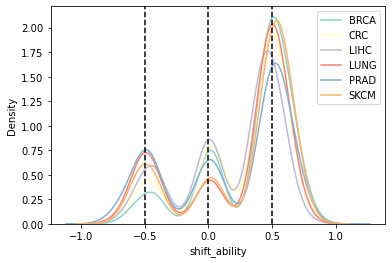

In [14]:
sns.set_palette('Set3')
for ct in shRNA_cancer:
    sns.kdeplot(shRNA_result[ct]['shift_ability'], label=ct)
plt.legend(loc='best')
plt.axvline(x=0.0, ls='--', c='k')
plt.axvline(x=0.5, ls='--', c='k')
plt.axvline(x=-0.5, ls='--', c='k')

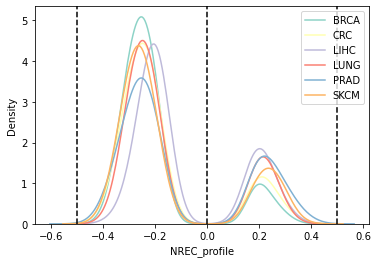

In [15]:
sns.set_palette('Set3')
for ct in shRNA_cancer:
    sns.kdeplot(shRNA_result[ct]['NREC_profile'], label=ct)
plt.legend(loc='best')
plt.axvline(x=0.0, ls='--', c='k')
plt.axvline(x=0.5, ls='--', c='k')
plt.axvline(x=-0.5, ls='--', c='k')

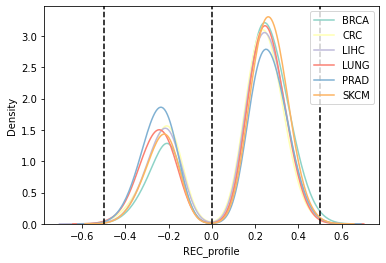

In [16]:
sns.set_palette('Set3')
for ct in shRNA_cancer:
    sns.kdeplot(shRNA_result[ct]['REC_profile'], label=ct)
plt.legend(loc='best')
plt.axvline(x=0.0, ls='--', c='k')
plt.axvline(x=0.5, ls='--', c='k')
plt.axvline(x=-0.5, ls='--', c='k')

In [13]:
# show top shifting shRNAs in each cancer type and cell lines
for ct in shRNA_cancer:
    tmp_shift = shRNA_result[ct]
    tmp_sig = sig_info[sig_info.index.isin(tmp_shift.index)]

    for cl in tmp_sig['cell_mfc_name'].unique():
        tmp_shift_cl = tmp_shift[tmp_shift.index.isin(tmp_sig[tmp_sig['cell_mfc_name'] == cl].index)]
        tmp_shift_cl = tmp_shift_cl.sort_values(by='shift_ability', ascending=False)
        
        # print result
        print(ct, cl)
        print('top shifting to R')
        print(list(tmp_shift_cl[:20]['cmap_name'])) # top 20
        print('top shifting to NR')
        print(list(tmp_shift_cl[-20:]['cmap_name'])) # bottom 20
        print('\n')

BRCA MCF7
top shifting to R
['AKAP13', 'CARD9', 'CARD9', 'FPGS', 'AMIGO3', 'SLK', 'SRSF2', 'TSLP', 'FOSL1', 'NR2F6', 'CLPB', 'CBS', 'CAT', 'WNT5A', 'MYC', 'HPRT1', 'CDK6', 'VDAC1', 'CRKL', 'MYCN']
top shifting to NR
['PLAU', 'MAPKAPK3', 'IL11RA', 'PDK2', 'AHRR', 'ASCC3', 'SGPL1', 'CNNM2', 'CSNK1E', 'JUN', 'ZNF597', 'TNIP1', 'RB1', 'EPHA2', 'MAPK9', 'ZNF595', 'ADCK3', 'VRK1', 'VRK1', 'LZIC']


CRC SW480
top shifting to R
['HECW2', 'JAZF1', 'ULK1', 'MAP3K8', 'MAP3K8', 'CCNE1', 'VHL', 'PSENEN', 'PSENEN', 'STK3', 'CSNK1E', 'SMAD3', 'PCLO', 'VHL', 'MYD88', 'CRY1', 'MAP3K14', 'BCL2L1', 'CRY1', 'KRAS']
top shifting to NR
['PHLPP2', 'DVL3', 'PHLPP2', 'PHLPP2', 'IRAK1', 'ARNTL', 'ARNTL', 'BAX', 'IRAK1', 'SMAD4', 'TRAF3', 'TRAF5', 'LRP6', 'HSP90B1', 'DIABLO', 'TBK1', 'CCND1', 'CCND1', 'TBK1', 'IKBKE']


CRC HT29
top shifting to R
['YES1', 'SV2A', 'HRSP12', 'TARDBP', 'BIRC5', 'MDH2', 'PISD', 'HIST1H2BK', 'SFPQ', 'ZNF217', 'CDK6', 'SFPQ', 'MAPK13', 'AKAP8L', 'IGFBP2', 'RRM1', 'HIST1H2BK', 'EZH2', 

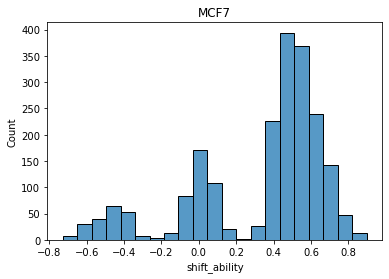

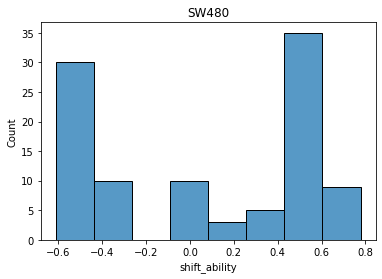

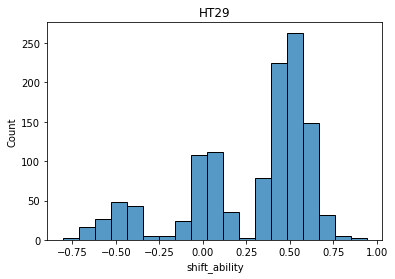

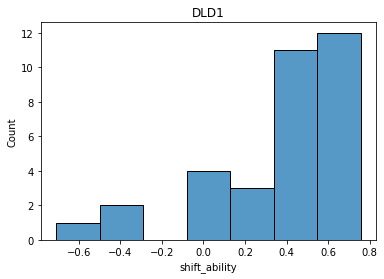

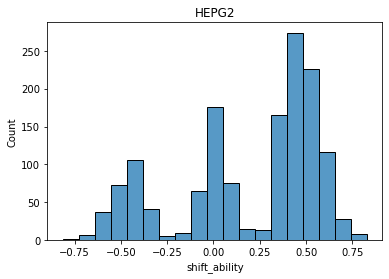

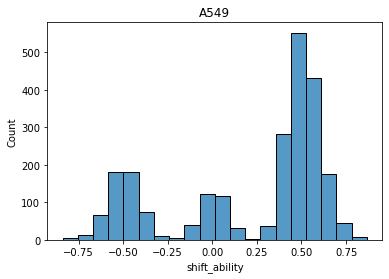

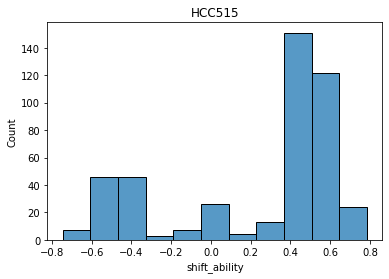

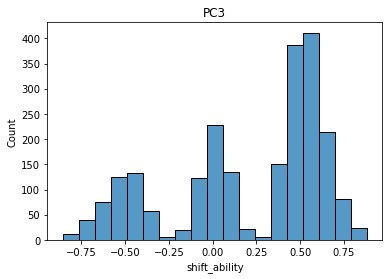

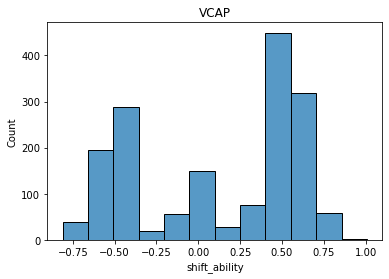

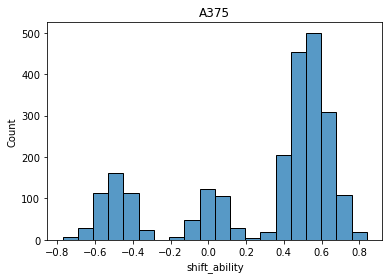

In [19]:
for ct in shRNA_cancer:
    tmp_shift = shRNA_result[ct]
    tmp_sig = sig_info[sig_info.index.isin(tmp_shift.index)]

    for cl in tmp_sig['cell_mfc_name'].unique():
        tmp_shift_cl = tmp_shift[tmp_shift.index.isin(tmp_sig[tmp_sig['cell_mfc_name'] == cl].index)]
        sns.histplot(tmp_shift_cl['shift_ability'])
        plt.title(cl)
        plt.show()

In [37]:
for ct in shRNA_cancer:
    tmp_shift = shRNA_result[ct]
    tmp_sig = sig_info[sig_info.index.isin(tmp_shift.index)]

    for cl in tmp_sig['cell_mfc_name'].unique():
        tmp_shift_cl = tmp_shift[tmp_shift.index.isin(tmp_sig[tmp_sig['cell_mfc_name'] == cl].index)]
        print(cl)
        print(tmp_shift_cl[tmp_shift_cl['shift_ability'] > 0.2]['shift_ability'].std())
        print(tmp_shift_cl[tmp_shift_cl['shift_ability'] < -0.2]['shift_ability'].std())

MCF7
0.10866925757844136
0.09433225178042692
SW480
0.08222524190211576
0.06363017033690654
HT29
0.09579218524688687
0.10991735231685827
DLD1
0.13479426971152236
0.15114623899711363
HEPG2
0.09575363451298023
0.09222209750733473
A549
0.09280020838393613
0.0901552933153842
HCC515
0.09317254195056694
0.08085029650328464
PC3
0.10487499185123006
0.1159991511852901
VCAP
0.10489946792406613
0.0940980187256511
A375
0.09442794752103374
0.08380948902558884


In [13]:
# shifting by cutoff: 0.6
shifting_cutoff = {}
for ct in shRNA_cancer:
    tmp_shift = shRNA_result[ct]
    tmp_sig = sig_info[sig_info.index.isin(tmp_shift.index)]

    for cl in tmp_sig['cell_mfc_name'].unique():
        tmp_shift_cl = tmp_shift[tmp_shift.index.isin(tmp_sig[tmp_sig['cell_mfc_name'] == cl].index)]
        
        shifting_cutoff[cl] = {}
        shifting_cutoff[cl]['R-to-S'] = tmp_shift_cl[tmp_shift_cl['shift_ability'] >= .6]
        shifting_cutoff[cl]['S-to-R'] = tmp_shift_cl[tmp_shift_cl['shift_ability'] <= -.6]

In [14]:
# number of shifting targets
shifting_number = df(index=shifting_cutoff.keys(), columns=['R-to-S', 'S-to-R', 'total_expr'])
for ct in shRNA_cancer:
    tmp_shift = shRNA_result[ct]
    tmp_sig = sig_info[sig_info.index.isin(tmp_shift.index)]

    for cl in tmp_sig['cell_mfc_name'].unique():
        tmp_shift_cl = tmp_shift[tmp_shift.index.isin(tmp_sig[tmp_sig['cell_mfc_name'] == cl].index)]
        
        shifting_number.at[cl, 'total_expr'] = tmp_shift_cl.shape[0]
        shifting_number.at[cl, 'R-to-S'] = shifting_cutoff[cl]['R-to-S'].shape[0]
        shifting_number.at[cl, 'S-to-R'] = shifting_cutoff[cl]['S-to-R'].shape[0]


In [15]:
shifting_number

R-to-S S-to-R total_expr
MCF7      400     21       2060
SW480      11      1        102
HT29      120     23       1182
DLD1        6      1         33
HEPG2      96     24       1437
A549      274     68       2379
HCC515     54      7        449
PC3       338    108       2245
VCAP      246     77       1678
A375      429     43       2384

In [16]:
shifting_cutoff['A375']['R-to-S']['cmap_name'].unique().shape

(364,)

In [17]:
# R-to-S matrix
r2s_matrix = df(columns=shifting_cutoff.keys())
for cl in shifting_cutoff.keys():
    for g in shifting_cutoff[cl]['R-to-S'].index:
        r2s_matrix.at[shifting_cutoff[cl]['R-to-S'].loc[g, 'cmap_name'], cl] = shifting_cutoff[cl]['R-to-S'].loc[g, 'shift_ability']

# S-to-R matrix
s2r_matrix = df(columns=shifting_cutoff.keys())
for cl in shifting_cutoff.keys():
    for g in shifting_cutoff[cl]['S-to-R'].index:
        s2r_matrix.at[shifting_cutoff[cl]['S-to-R'].loc[g, 'cmap_name'], cl] = shifting_cutoff[cl]['S-to-R'].loc[g, 'shift_ability']

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


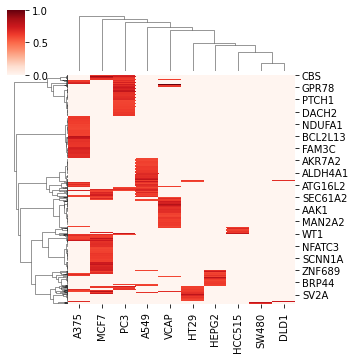

In [43]:
sns.clustermap(r2s_matrix.fillna(0),
               figsize=(5, 5), method='ward',
               cmap='Reds')

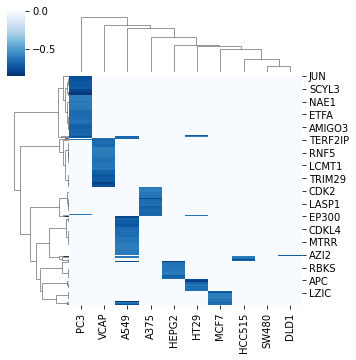

In [44]:
sns.clustermap(s2r_matrix.fillna(0),
               figsize=(5, 5), method='ward',
               cmap='Blues_r')

In [18]:
# overlap between r2s
r2s_matrix_count = np.sign(r2s_matrix.fillna(0))
df(r2s_matrix_count.sum(axis=1)).sort_values(by=0, ascending=False)[:20]

0
AKR1A1  7.0
ABAT    6.0
HPD     4.0
ADCK3   4.0
ZNF517  4.0
KIF11   4.0
YES1    4.0
SFPQ    4.0
HRAS    4.0
GATA1   4.0
XBP1    4.0
IQGAP1  4.0
DCPS    4.0
TGFBR2  4.0
MYC     4.0
PSMB2   4.0
LYN     4.0
BLVRA   3.0
ERBB3   3.0
USP7    3.0

In [19]:
# overlap between s2r
s2r_matrix_count = -np.sign(s2r_matrix.fillna(0))
df(s2r_matrix_count.sum(axis=1)).sort_values(by=0, ascending=False)[:20]

0
SPR      3.0
EP300    3.0
BAD      3.0
TNIP1    2.0
TERF2IP  2.0
ZFP1     2.0
ADCK3    2.0
AURKA    2.0
MAPK9    2.0
EPHA2    2.0
POLR2I   2.0
CRKL     2.0
JUN      2.0
CFLAR    2.0
PRPF6    2.0
DAP      2.0
KRAS     2.0
HSD17B2  2.0
ZNF597   2.0
S1PR3    1.0

In [20]:
# top r2s: A375
shifting_cutoff['A375']['R-to-S']

NREC_profile  REC_profile cmap_name  \
KDA005_A375_96H:TRCN0000000870:-666     -0.342639     0.497316      PLK2   
KDA005_A375_96H:A09                     -0.342639     0.497316      PLK2   
KDA002_A375_96H:H10                     -0.418181     0.418882      FBP1   
TAK001_A375_96H:TRCN0000002004:-666     -0.357131     0.457738    PRKACB   
KDB008_A375_96H:TRCN0000019234:-666     -0.374969     0.434806      PHF2   
...                                           ...          ...       ...   
KDB008_A375_96H:TRCN0000002119:-666     -0.299137     0.301980   PIK3C2B   
KDB008_A375_96H:TRCN0000051815:-666     -0.324560     0.276555    SKIV2L   
KDA002_A375_96H:TRCN0000061801:-666     -0.322936     0.277803     AXIN1   
KDA002_A375_96H:TRCN0000002430:-666     -0.329366     0.271281    CDC25A   
KDC002_A375_96H:TRCN0000017966:-666     -0.296641     0.303543      PBX4   

                                     nearest_dose  pert_idose  shift_ability  
KDA005_A375_96H:TRCN0000000870:-666           NaN         NaN       0.839955  
KDA005_A375_96H:A09                           NaN         NaN       0.839955  
KDA002_A375_96H:H10                           NaN         NaN       0.837063  
TAK001_A375_96H:TRCN0000002004:-666           NaN         NaN       0.814869  
KDB008_A375_96H:TRCN0000019234:-666           NaN         NaN       0.809775  
...                                           ...         ...            ...  
KDB008_A375_96H:TRCN0000002119:-666           NaN         NaN       0.601117  
KDB008_A375_96H:TRCN0000051815:-666           NaN         NaN       0.601115  
KDA002_A375_96H:TRCN0000061801:-666           NaN         NaN       0.600739  
KDA002_A375_96H:TRCN0000002430:-666           NaN         NaN       0.600647  
KDC002_A375_96H:TRCN0000017966:-666           NaN         NaN       0.600184  

[429 rows x 6 columns]

In [48]:
shifting_cutoff['A375']['R-to-S']['cmap_name'].unique()

array(['PLK2', 'FBP1', 'PRKACB', 'PHF2', 'MCM7', 'ZNF551', 'ZMIZ2',
       'ILF2', 'USP1', 'ACSL1', 'PIK3C2B', 'ITPR2', 'INSIG1', 'STK38',
       'AKAP11', 'CCND3', 'NOLC1', 'KRAS', 'ARHGEF6', 'CRKL', 'GNG4',
       'HDAC4', 'ETS1', 'ABAT', 'COL4A5', 'JUN', 'PAX8', 'XBP1', 'HS2ST1',
       'ETFA', 'FAM114A2', 'MTHFD2', 'SUCLG1', 'NFKB2', 'RAF1', 'CERK',
       'DYNLL1', 'FABP6', 'MCM3', 'GNA13', 'KCNK2', 'ME2', 'SENP6',
       'TCEB3', 'PSMB2', 'TLE1', 'FBXO21', 'CSAD', 'FAM3C', 'RARA',
       'ZNF561', 'NPM1', 'LYN', 'ZFP36', 'SOCS2', 'UGCG', 'AP2A2',
       'TGFBR2', 'CAMK2D', 'TESK1', 'DHDDS', 'PLK3', 'AOC3', 'AMDHD2',
       'RHOA', 'ERH', 'ATG7', 'EDN1', 'KIAA0753', 'CTNNAL1', 'PAF1',
       'BLVRA', 'SYNE2', 'POLR3F', 'THAP11', 'MXD4', 'ZNF418', 'PHB',
       'LHPP', 'JAG1', 'FRAT1', 'ASAH1', 'NME1', 'F3', 'SLC39A8', 'STAM2',
       'ATP5F1', 'C2CD2', 'ADCY3', 'IL12B', 'ABCF1', 'PSIP1', 'MYC',
       'PUS7L', 'ALB', 'CHN1', 'GSK3B', 'ESPL1', 'GPR125', 'PTPN1',
       'NGFR', 'PSM

In [33]:
for cl in shifting_cutoff.keys():
    shifting_cutoff[cl]['R-to-S'].to_csv('/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/panels/Figure2/sig_shifting/' + cl + '_R2S_0.6.csv', sep=',')
    shifting_cutoff[cl]['S-to-R'].to_csv('/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/panels/Figure2/sig_shifting/' + cl + '_S2R_n0.6.csv', sep=',')

In [34]:
r2s_matrix.to_csv('/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/panels/Figure2/sig_shifting_matrix/R2S_matrix_score.csv', sep=',')
r2s_matrix_count.to_csv('/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/panels/Figure2/sig_shifting_matrix/R2S_matrix_count.csv', sep=',')

In [35]:
s2r_matrix.to_csv('/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/panels/Figure2/sig_shifting_matrix/S2R_matrix_score.csv', sep=',')
s2r_matrix_count.to_csv('/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/panels/Figure2/sig_shifting_matrix/S2R_matrix_count.csv', sep=',')

In [14]:
# heatmap showing top n shRNAs in each cell line
def visual_top_n(n, cancer_list, shift_result, sig_info):
    top_R_merged = {}
    top_NR_merged = {}

    for ct in cancer_list:
        tmp_shift = shift_result[ct]
        tmp_sig = sig_info[sig_info.index.isin(tmp_shift.index)]

        for cl in tmp_sig['cell_mfc_name'].unique():
            if cl == 'DLD1' or cl == 'SW480': # skip cell lines with too small number shRNA test
                continue
            tmp_shift_cl = tmp_shift[tmp_shift.index.isin(tmp_sig[tmp_sig['cell_mfc_name'] == cl].index)]
            tmp_shift_cl = tmp_shift_cl.sort_values(by='shift_ability', ascending=False)

            tmp_to_R = list(tmp_shift_cl[:n]['cmap_name'])
            tmp_to_NR = list(tmp_shift_cl[-n:]['cmap_name'])

            top_R_merged[cl] = tmp_to_R
            top_NR_merged[cl] = tmp_to_NR
    
    # build a mutual exclusive matrix
    top_R_matrix = df(columns=top_R_merged.keys())
    top_NR_matrix = df(columns=top_NR_merged.keys())
    
    for cl in top_R_merged.keys():
        for g in top_R_merged[cl]:
            top_R_matrix.at[g, cl] = 1

    
    for cl in top_NR_merged.keys():
        for g in top_NR_merged[cl]:
            top_NR_matrix.at[g, cl] = 1

    # visualize
    plt.figure(figsize=(5, 5))
    sns.heatmap(top_R_matrix.fillna(0), square=False, cmap='Reds')
    plt.show()
    
    plt.figure(figsize=(5, 5))
    sns.heatmap(top_NR_matrix.fillna(0), square=False, cmap='Reds')
    plt.show()
    
    return top_R_matrix, top_NR_matrix

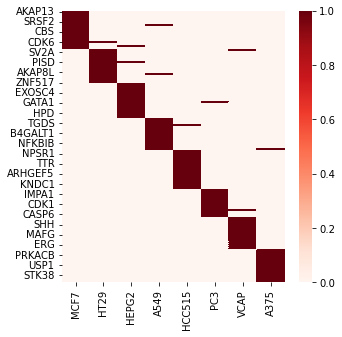

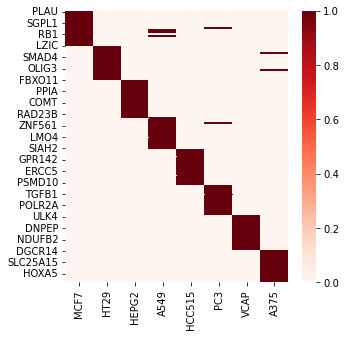

In [15]:
top_R_20, top_NR_20 = visual_top_n(n=20, cancer_list=shRNA_cancer, shift_result=shRNA_result, sig_info=sig_info)

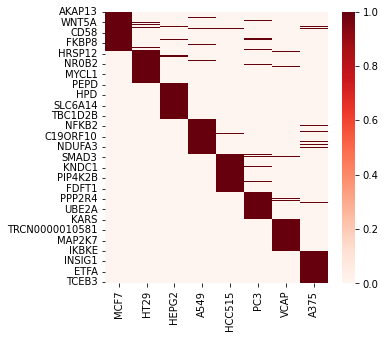

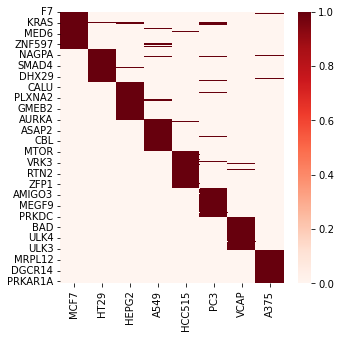

In [16]:
top_R_50, top_NR_50 = visual_top_n(n=50, cancer_list=shRNA_cancer, shift_result=shRNA_result, sig_info=sig_info)

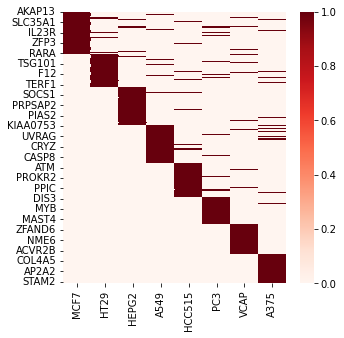

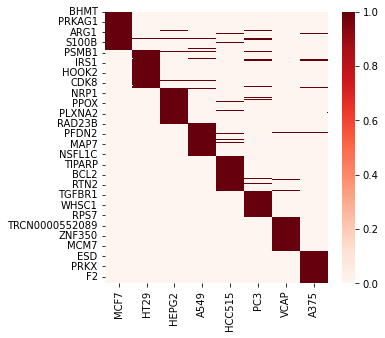

In [17]:
top_R_100, top_NR_100 = visual_top_n(n=100, cancer_list=shRNA_cancer, shift_result=shRNA_result, sig_info=sig_info)

In [18]:
# overlap between R-shifting and NR-shifting
op_top_20 = list(set(top_R_20.index) & set(top_NR_20.index))
print(len(top_R_20.index), len(top_NR_20.index), len(op_top_20))
op_top_50 = list(set(top_R_50.index) & set(top_NR_50.index))
print(len(top_R_50.index), len(top_NR_50.index), len(op_top_50))
op_top_100 = list(set(top_R_100.index) & set(top_NR_100.index))
print(len(top_R_100.index), len(top_NR_100.index), len(op_top_100))

134 143 5
314 328 33
576 614 103


MCF7 1336
SW480 75
HT29 831
DLD1 22
HEPG2 1076
A549 1502
HCC515 360
PC3 1379
VCAP 1107
A375 1556
5756


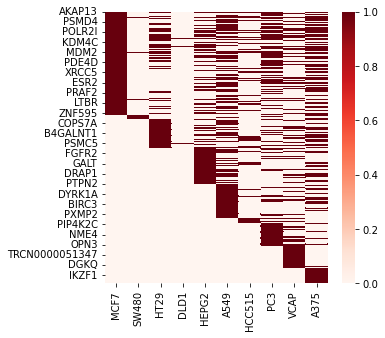

(3488, 10)


In [19]:
# overlap between shRNA targets between cell lines
shRNA_target_merged = {}
for ct in shRNA_cancer:
    tmp_shift = shRNA_result[ct]
    tmp_sig = sig_info[sig_info.index.isin(tmp_shift.index)]

    for cl in tmp_sig['cell_mfc_name'].unique():
        tmp_shift_cl = tmp_shift[tmp_shift.index.isin(tmp_sig[tmp_sig['cell_mfc_name'] == cl].index)]
        shRNA_target_merged[cl] = list(tmp_shift_cl['cmap_name'].unique())
        print(cl, len(shRNA_target_merged[cl]))

shRNA_target_matrix = df(columns=shRNA_target_merged.keys())

re_count = 0
for cl in shRNA_target_merged.keys():
    for g in shRNA_target_merged[cl]:
        if g in shRNA_target_matrix.index:
            re_count += 1
            shRNA_target_matrix.at[g, cl] = 1
        else:
            shRNA_target_matrix.at[g, cl] = 1

print(re_count)
# visualize
plt.figure(figsize=(5, 5))
sns.heatmap(shRNA_target_matrix.fillna(0), square=False, cmap='Reds', vmin=0, vmax=1)
plt.show()
print(shRNA_target_matrix.shape)

## 1. Functional annotation of top shifting shRNAs

### 1. shRNAs who have shift ability in multiple cell lines

In [20]:
# use top 100 as example
top_R_100_multi = df(top_R_100.sum(axis=1)).sort_values(by=0, ascending=False)[:20]
top_R_100_multi

0
ABAT     5.0
GATA1    4.0
MYC      3.0
FASLG    3.0
IL23R    3.0
SFPQ     3.0
SLC35A1  3.0
GALC     3.0
CRKL     3.0
ZNF768   3.0
PHACTR1  3.0
AKR1A1   3.0
PROCR    3.0
PHKG2    3.0
MTHFD2   3.0
HPD      3.0
ME2      3.0
MYBL2    2.0
RARA     2.0
XBP1     2.0

In [21]:
top_NR_100_multi = df(top_NR_100.sum(axis=1)).sort_values(by=0, ascending=False)[:20]
top_NR_100_multi

0
KRAS    5.0
JUN     4.0
POLR2I  4.0
PLAT    3.0
STK33   3.0
PABPC1  3.0
BAD     3.0
SPR     3.0
PKN1    3.0
IL4R    3.0
EP300   3.0
CRKL    3.0
CFLAR   3.0
CSK     3.0
CASP3   3.0
ZFP1    2.0
NUP62   2.0
PPIA    2.0
GSS     2.0
BID     2.0

### 2. Pathway enrichment in top shifting shRNAs

In [ ]:
gp_R_100.res2d[:20]

In [ ]:
gp_NR_100 = gp.enrichr(gene_list=list(top_NR_100.index), gene_sets=['MSigDB_Hallmark_2020'])

In [ ]:
gp_NR_100.res2d[:20]

In [84]:
# run enr for top shifting in each cell line
enr_R2S = []
enr_S2R = []


for cl in shifting_cutoff.keys():
    tmp_cl = shifting_cutoff[cl]

    # enr
    if tmp_cl['R-to-S'].shape[0] > 10:
        tmp_R2S_enr = gp.enrichr(gene_list=list(tmp_cl['R-to-S']['cmap_name'].unique()), gene_sets=gsea_home + 'gene_sets/h.all.v7.5.1.symbols.gmt').res2d.set_index('Term')
        enr_R2S.append(df(tmp_R2S_enr['Adjusted P-value']).rename(columns={'Adjusted P-value' :cl}))
    if tmp_cl['S-to-R'].shape[0] > 10:
        tmp_S2R_enr = gp.enrichr(gene_list=list(tmp_cl['S-to-R']['cmap_name'].unique()), gene_sets=gsea_home + 'gene_sets/h.all.v7.5.1.symbols.gmt').res2d.set_index('Term')
        enr_S2R.append(df(tmp_S2R_enr['Adjusted P-value']).rename(columns={'Adjusted P-value' :cl}))
    

2023-02-09 22:17:08,911 Warning: No enrich terms using library CUSTOM140308489935424 when cutoff = 0.05
2023-02-09 22:17:10,192 Warning: No enrich terms using library CUSTOM140308480727680 when cutoff = 0.05


In [85]:
enr_R2S_fdr = pd.concat(enr_R2S, axis=1).fillna(1)
enr_R2S_fdr

MCF7     SW480      HT29  \
HALLMARK_ADIPOGENESIS                       0.000917  1.000000  0.047273   
HALLMARK_ALLOGRAFT_REJECTION                0.006102  1.000000  0.047273   
HALLMARK_ANDROGEN_RESPONSE                  0.004640  1.000000  0.135177   
HALLMARK_ANGIOGENESIS                       0.513390  1.000000  1.000000   
HALLMARK_APICAL_JUNCTION                    0.015214  1.000000  0.628426   
HALLMARK_APICAL_SURFACE                     0.014244  1.000000  1.000000   
HALLMARK_APOPTOSIS                          0.000215  1.000000  0.228624   
HALLMARK_BILE_ACID_METABOLISM               0.064561  1.000000  0.155281   
HALLMARK_CHOLESTEROL_HOMEOSTASIS            0.056751  1.000000  0.003426   
HALLMARK_COAGULATION                        0.498017  1.000000  0.204377   
HALLMARK_COMPLEMENT                         0.000917  1.000000  0.285488   
HALLMARK_DNA_REPAIR                         0.003534  1.000000  0.532743   
HALLMARK_E2F_TARGETS                        0.000917  0.090241  0.003426   
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION  0.002372  1.000000  0.285488   
HALLMARK_ESTROGEN_RESPONSE_EARLY            0.006190  1.000000  0.003426   
HALLMARK_ESTROGEN_RESPONSE_LATE             0.014818  1.000000  0.014368   
HALLMARK_FATTY_ACID_METABOLISM              0.168318  1.000000  0.095979   
HALLMARK_G2M_CHECKPOINT                     0.033760  1.000000  0.014368   
HALLMARK_GLYCOLYSIS                         0.000917  1.000000  0.047273   
HALLMARK_HEDGEHOG_SIGNALING                 0.168032  1.000000  0.211369   
HALLMARK_HEME_METABOLISM                    0.014244  1.000000  1.000000   
HALLMARK_HYPOXIA                            0.014818  0.090241  0.047273   
HALLMARK_IL2_STAT5_SIGNALING                0.006190  0.029824  0.133009   
HALLMARK_IL6_JAK_STAT3_SIGNALING            0.504252  0.080773  0.376135   
HALLMARK_INFLAMMATORY_RESPONSE              0.000026  1.000000  0.133009   
HALLMARK_INTERFERON_ALPHA_RESPONSE          0.531140  1.000000  0.133009   
HALLMARK_INTERFERON_GAMMA_RESPONSE          0.168032  1.000000  0.133009   
HALLMARK_KRAS_SIGNALING_DN                  0.969396  1.000000  0.133009   
HALLMARK_KRAS_SIGNALING_UP                  0.316643  1.000000  0.133009   
HALLMARK_MITOTIC_SPINDLE                    0.168032  1.000000  0.285488   
HALLMARK_MTORC1_SIGNALING                   0.002372  1.000000  0.047273   
HALLMARK_MYC_TARGETS_V1                     0.000006  1.000000  0.002326   
HALLMARK_MYC_TARGETS_V2                     0.316643  1.000000  0.081477   
HALLMARK_MYOGENESIS                         0.695515  1.000000  0.133009   
HALLMARK_NOTCH_SIGNALING                    0.028797  0.052485  1.000000   
HALLMARK_OXIDATIVE_PHOSPHORYLATION          0.000917  1.000000  0.285488   
HALLMARK_P53_PATHWAY                        0.002372  1.000000  0.014368   
HALLMARK_PEROXISOME                         0.016978  1.000000  0.422348   
HALLMARK_PI3K_AKT_MTOR_SIGNALING            0.000002  1.000000  0.144190   
HALLMARK_PROTEIN_SECRETION                  0.004100  1.000000  0.133009   
HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY    0.017307  1.000000  1.000000   
HALLMARK_SPERMATOGENESIS                    0.695515  1.000000  0.198926   
HALLMARK_TGF_BETA_SIGNALING                 0.001334  1.000000  0.003208   
HALLMARK_TNFA_SIGNALING_VIA_NFKB            0.000026  0.090241  0.003426   
HALLMARK_UNFOLDED_PROTEIN_RESPONSE          0.062281  1.000000  0.047273   
HALLMARK_UV_RESPONSE_DN                     0.056751  1.000000  0.207333   
HALLMARK_UV_RESPONSE_UP                     0.000003  0.090241  0.226236   
HALLMARK_WNT_BETA_CATENIN_SIGNALING         0.013119  0.052485  0.047273   
HALLMARK_XENOBIOTIC_METABOLISM              0.000917  1.000000  0.047273   
HALLMARK_PANCREAS_BETA_CELLS                1.000000  1.000000  1.000000   

                                               HEPG2          A549    HCC515  \
HALLMARK_ADIPOGENESIS                       0.070751  2.301200e-02  1.000000   
HALLMARK_AL

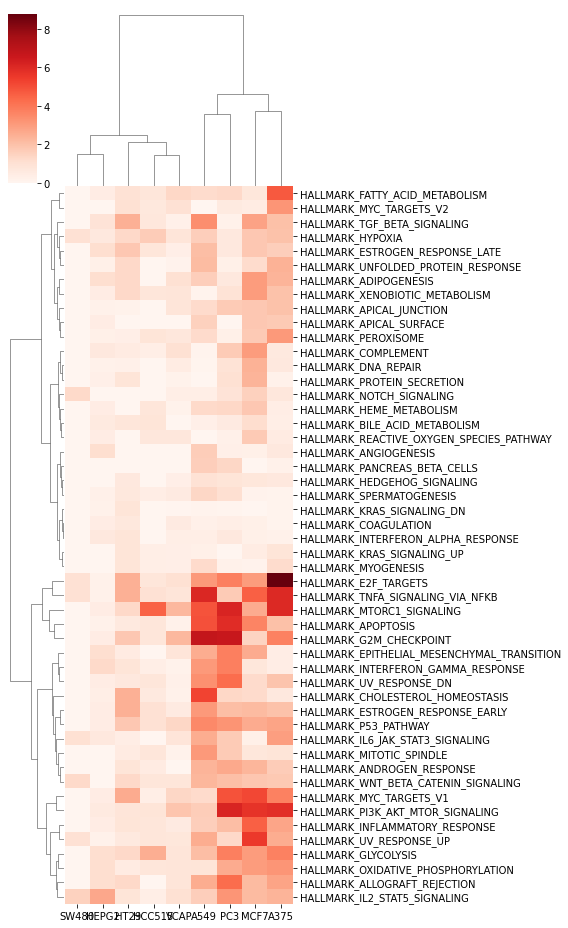

In [86]:
sns.clustermap(-np.log10(enr_R2S_fdr), cmap='Reds', 
               figsize=(8, 13), method='ward')

In [87]:
enr_S2R_fdr = pd.concat(enr_S2R, axis=1).fillna(1)
enr_S2R_fdr

MCF7      HT29     HEPG2  \
HALLMARK_APOPTOSIS                          0.189601  0.189601  1.000000   
HALLMARK_COAGULATION                        0.189601  1.000000  1.000000   
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION  0.189601  1.000000  0.223978   
HALLMARK_HYPOXIA                            0.077582  1.000000  0.223978   
HALLMARK_IL6_JAK_STAT3_SIGNALING            0.189601  1.000000  1.000000   
HALLMARK_KRAS_SIGNALING_DN                  0.189601  1.000000  0.223978   
HALLMARK_KRAS_SIGNALING_UP                  0.189601  1.000000  0.223978   
HALLMARK_MYOGENESIS                         0.189601  1.000000  1.000000   
HALLMARK_P53_PATHWAY                        0.000591  1.000000  0.223978   
HALLMARK_PI3K_AKT_MTOR_SIGNALING            0.189601  1.000000  1.000000   
HALLMARK_TNFA_SIGNALING_VIA_NFKB            0.007308  1.000000  0.223978   
HALLMARK_WNT_BETA_CATENIN_SIGNALING         0.140478  1.000000  1.000000   
HALLMARK_XENOBIOTIC_METABOLISM              0.189601  1.000000  0.009541   
HALLMARK_APICAL_JUNCTION                    1.000000  0.189601  0.223978   
HALLMARK_GLYCOLYSIS                         1.000000  0.189601  0.009541   
HALLMARK_MITOTIC_SPINDLE                    1.000000  0.107421  0.223978   
HALLMARK_TGF_BETA_SIGNALING                 1.000000  0.165732  1.000000   
HALLMARK_UV_RESPONSE_UP                     1.000000  0.189601  0.223978   
HALLMARK_BILE_ACID_METABOLISM               1.000000  1.000000  0.223978   
HALLMARK_COMPLEMENT                         1.000000  1.000000  0.074385   
HALLMARK_E2F_TARGETS                        1.000000  1.000000  0.074385   
HALLMARK_G2M_CHECKPOINT                     1.000000  1.000000  0.009541   
HALLMARK_INTERFERON_GAMMA_RESPONSE          1.000000  1.000000  0.223978   
HALLMARK_MTORC1_SIGNALING                   1.000000  1.000000  0.074385   
HALLMARK_MYC_TARGETS_V1                     1.000000  1.000000  0.009541   
HALLMARK_OXIDATIVE_PHOSPHORYLATION          1.000000  1.000000  0.223978   
HALLMARK_SPERMATOGENESIS                    1.000000  1.000000  0.223978   
HALLMARK_ADIPOGENESIS                       1.000000  1.000000  1.000000   
HALLMARK_ANDROGEN_RESPONSE                  1.000000  1.000000  1.000000   
HALLMARK_ANGIOGENESIS                       1.000000  1.000000  1.000000   
HALLMARK_DNA_REPAIR                         1.000000  1.000000  1.000000   
HALLMARK_ESTROGEN_RESPONSE_EARLY            1.000000  1.000000  1.000000   
HALLMARK_ESTROGEN_RESPONSE_LATE             1.000000  1.000000  1.000000   
HALLMARK_FATTY_ACID_METABOLISM              1.000000  1.000000  1.000000   
HALLMARK_HEDGEHOG_SIGNALING                 1.000000  1.000000  1.000000   
HALLMARK_HEME_METABOLISM                    1.000000  1.000000  1.000000   
HALLMARK_IL2_STAT5_SIGNALING                1.000000  1.000000  1.000000   
HALLMARK_INFLAMMATORY_RESPONSE              1.000000  1.000000  1.000000   
HALLMARK_INTERFERON_ALPHA_RESPONSE          1.000000  1.000000  1.000000   
HALLMARK_NOTCH_SIGNALING                    1.000000  1.000000  1.000000   
HALLMARK_PEROXISOME                         1.000000  1.000000  1.000000   
HALLMARK_UV_RESPONSE_DN                     1.000000  1.000000  1.000000   
HALLMARK_ALLOGRAFT_REJECTION                1.000000  1.000000  1.000000   
HALLMARK_MYC_TARGETS_V2                     1.000000  1.000000  1.000000   
HALLMARK_PROTEIN_SECRETION                  1.000000  1.000000  1.000000   
HALLMARK_UNFOLDED_PROTEIN_RESPONSE          1.000000  1.000000  1.000000   
HALLMARK_PANCREAS_BETA_CELLS                1.000000  1.000000  1.000000   
HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY    1.000000  1.000000  1.000000   

                                                A549       PC3      VCAP  \
HALLMARK_APOPTOSIS                          0.024647  0.124041  0.288536   
HALLMARK_COAGULATION                        0.476864  0.589998  1.000000   
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION  1.000000  0.052438  0.137436   
HALLMARK_HYPOXIA   

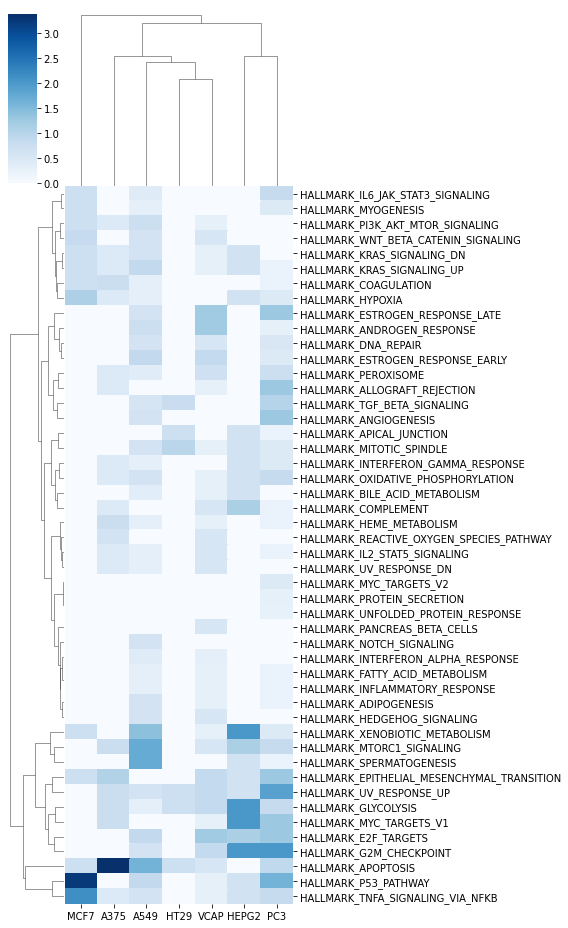

In [88]:
sns.clustermap(-np.log10(enr_S2R_fdr), cmap='Blues', 
               figsize=(8, 13), method='ward')

In [6]:
# GSE91061 original expression
expr_91061 = pd.read_csv(data_home + 'GSE91061/GSE91061_BMS038109Sample.hg19KnownGene.fpkm.csv',
                          index_col=0, header=0, sep=',')

expr_91061 = expr_91061[expr_91061.index.isin(bing_landmark.index)]
expr_91061 = expr_91061.rename(index=bing_landmark['Official NCBI gene symbol'])

# overlap with the L1000 space
expr_91061 = expr_91061[expr_91061.index.isin(bing_landmark['Official NCBI gene symbol'])]

# read clinical information
info_91061 = pd.read_csv(data_home + 'GSE91061/GSE91061_patient_info.csv',
                          index_col=0, header=0, sep=',').T
print(expr_91061.shape, info_91061.shape)

(10158, 109) (109, 2)


In [7]:
# get the paired sample list
timepoint_91061 = df(columns=['Pre', 'On', 'response'])
for p in info_91061.index:
    tmp_cat = p.split('_')[1]
    tmp_p = p.split('_')[0]
    timepoint_91061.at[tmp_p, tmp_cat] = p
    timepoint_91061.at[tmp_p, 'response'] = info_91061.loc[p, 'response'].split(': ')[1]

# get the patients with paired samples
paired_91061 = timepoint_91061.dropna(axis=0, how='any')

print(timepoint_91061.shape, paired_91061.shape)

(65, 3) (43, 3)


In [8]:
response_lut = {'PD': 'crimson', 'SD': 'royalblue', 'PRCR': 'cornflowerblue', 'UNK': 'grey'}
patient_color = df(index=info_91061.index, columns=['response', 'response_color', 'time', 'time_color'])
for p in paired_91061.index:
    patient_color.at[paired_91061.loc[p, 'Pre'], 'time'] = 'Pre'
    patient_color.at[paired_91061.loc[p, 'On'], 'time'] = 'On'
    patient_color.at[paired_91061.loc[p, 'Pre'], 'time_color'] = 'violet'
    patient_color.at[paired_91061.loc[p, 'On'], 'time_color'] = 'gold'
    patient_color.at[paired_91061.loc[p, 'Pre'], 'response'] = paired_91061.loc[p, 'response']
    patient_color.at[paired_91061.loc[p, 'On'], 'response'] = paired_91061.loc[p, 'response']
    patient_color.at[paired_91061.loc[p, 'Pre'], 'response_color'] = response_lut[paired_91061.loc[p, 'response']]
    patient_color.at[paired_91061.loc[p, 'On'], 'response_color'] = response_lut[paired_91061.loc[p, 'response']]
patient_color = patient_color.dropna(axis=0, how='any')

In [9]:
# add color for paired_91061
for p in paired_91061.index:
    paired_91061.at[p, 'response_color'] = response_lut[paired_91061.loc[p, 'response']]

paired_91061['response'].value_counts()

/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


PD      18
SD      15
PRCR     9
UNK      1
Name: response, dtype: int64

In [10]:
log2exp2_91061 = np.log2(expr_91061 + 1) # log2FPKM

# collapse duplicates
log2exp2_91061 = log2exp2_91061.groupby(level=0).mean()

log2exp2_91061 = log2exp2_91061[log2exp2_91061 > 0.].dropna(axis=0, how='all').fillna(0.)
print(log2exp2_91061.shape)

(10157, 109)


In [11]:
# differential between N and NR in On-treatment - Pre-treatment
log2exp2_91061_fc = df(index=log2exp2_91061.index, columns=paired_91061.index)
for p in log2exp2_91061_fc.columns:
    log2exp2_91061_fc[p] = log2exp2_91061[paired_91061.loc[p, 'On']] - log2exp2_91061[paired_91061.loc[p, 'Pre']]

In [12]:
patient_color

response  response_color time time_color
Pt1_Pre_AD101148-6         PD         crimson  Pre     violet
Pt1_On_AD174047-6          PD         crimson   On       gold
Pt2_Pre_AD101150-6         SD       royalblue  Pre     violet
Pt2_On_AD174046-6          SD       royalblue   On       gold
Pt23_On_AD486568-8        UNK            grey   On       gold
...                       ...             ...  ...        ...
Pt44_On_AD167376-6       PRCR  cornflowerblue   On       gold
Pt106_Pre_AD502250-5       PD         crimson  Pre     violet
Pt106_On_AD513626-6        PD         crimson   On       gold
Pt34_On_AD485757-6       PRCR  cornflowerblue   On       gold
Pt34_Pre_AD466985-6      PRCR  cornflowerblue  Pre     violet

[86 rows x 4 columns]

In [13]:
# PAK4 expression
pak4_expr = df(log2exp2_91061.loc['PAK4', :])
pak4_expr['response'] = patient_color['response']
pak4_expr['time'] = patient_color['time']

<AxesSubplot:xlabel='response', ylabel='PAK4'>

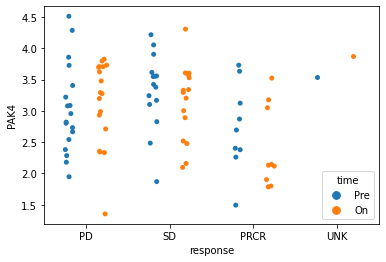

In [20]:
sns.stripplot(x='response', y='PAK4', hue='time', dodge=True, data=pak4_expr)

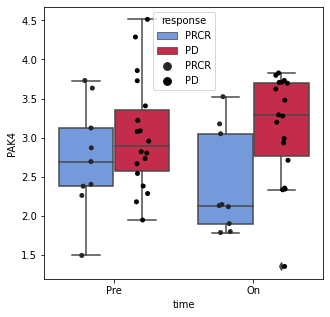

In [24]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='time', y='PAK4',
            hue='response', palette=response_lut, hue_order=['PRCR', 'PD'],
            data=pak4_expr)
sns.stripplot(x='time', y='PAK4', hue_order=['PRCR', 'PD'],
            hue='response', color='k', dodge=True,
            data=pak4_expr)
fig = plt.gcf()
fig.savefig(poseidon_home + 'panels/Figure5/GSE91061_merged_PAK4.pdf', transparent=True)

In [23]:
# SMAD3 expression
smad3_expr = df(log2exp2_91061.loc['SMAD3', :])
smad3_expr['response'] = patient_color['response']
smad3_expr['time'] = patient_color['time']

<AxesSubplot:xlabel='time', ylabel='SMAD3'>

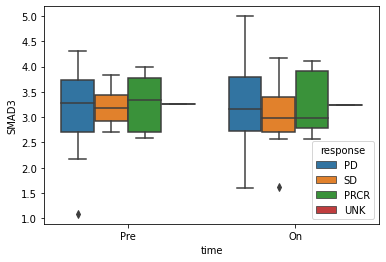

In [25]:
sns.boxplot(x='time', y='SMAD3', hue='response', data=smad3_expr)

In [26]:
smad3_expr_fc = df(log2exp2_91061_fc.loc['SMAD3', :])
smad3_expr_fc['response'] = paired_91061['response']

In [35]:
smad3_expr_fc['response_merged'] = 'UNK'
for p in smad3_expr_fc.index:
    if smad3_expr_fc.loc[p, 'response'] == 'PD':
        smad3_expr_fc.at[p, 'response_merged'] = 'Resistant'
    elif smad3_expr_fc.loc[p, 'response'] == 'SD' or smad3_expr_fc.loc[p, 'response'] == 'PRCR':
        smad3_expr_fc.at[p, 'response_merged'] = 'Sensitive'

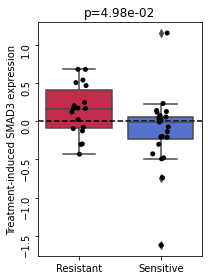

In [53]:
plt.figure(figsize=(3, 4))
sns.boxplot(x='response_merged', y='SMAD3', data=smad3_expr_fc, order=['Resistant', 'Sensitive'],
            palette={'Resistant': 'crimson',
                     'Sensitive': 'royalblue',
                     'UNK': 'white'})
sns.stripplot(x='response_merged', y='SMAD3', jitter=True,
              order=['Resistant', 'Sensitive'], data=smad3_expr_fc, color='k')

t, p = stats.ttest_ind(smad3_expr_fc[smad3_expr_fc['response_merged'] == 'Resistant']['SMAD3'],
                       smad3_expr_fc[smad3_expr_fc['response_merged'] == 'Sensitive']['SMAD3'],)
plt.xlabel('')
plt.ylabel('Treatment-induced SMAD3 expression')
plt.yticks(rotation=90)
plt.axhline(y=0., ls='--', c='k')
plt.title('p=' + '{:.2e}'.format(p))
plt.tight_layout()
fig = plt.gcf()
fig.savefig(poseidon_home + 'panels/FigS3/SMAD3_expression.pdf', transparent=True)

In [30]:
paired_91061

Pre                   On response  response_color
Pt1      Pt1_Pre_AD101148-6    Pt1_On_AD174047-6       PD         crimson
Pt2      Pt2_Pre_AD101150-6    Pt2_On_AD174046-6       SD       royalblue
Pt23    Pt23_Pre_AD313075-5   Pt23_On_AD486568-8      UNK            grey
Pt82    Pt82_Pre_AD823914-8   Pt82_On_AD125218-6       SD       royalblue
Pt49    Pt49_Pre_AD667851-6   Pt49_On_AD681976-5     PRCR  cornflowerblue
Pt85    Pt85_Pre_AD486329-5  Pt85_On_AE070989-10       PD         crimson
Pt89    Pt89_Pre_AE070951-5   Pt89_On_AE070987-5       SD       royalblue
Pt101  Pt101_Pre_AD486328-5  Pt101_On_AD681975-5     PRCR  cornflowerblue
Pt47    Pt47_Pre_AD506073-6   Pt47_On_AD530367-6       PD         crimson
Pt52    Pt52_Pre_AD506075-6   Pt52_On_AD530365-6       PD         crimson
Pt67    Pt67_Pre_AD506074-6   Pt67_On_AD530366-6       SD       royalblue
Pt94    Pt94_Pre_AD732850-6   Pt94_On_AE373242-6     PRCR  cornflowerblue
Pt77    Pt77_Pre_AD733591-7   Pt77_On_AD733629-8       SD       royalblue
Pt79    Pt79_Pre_AD733587-5   Pt79_On_AD733628-6       SD       royalblue
Pt84    Pt84_Pre_AD486532-5   Pt84_On_AD495199-6       PD         crimson
Pt98    Pt98_Pre_AD733586-8   Pt98_On_AE086717-6       SD       royalblue
Pt62    Pt62_Pre_AD608303-5   Pt62_On_AD635728-5       PD         crimson
Pt65    Pt65_Pre_AD793919-6   Pt65_On_AD796996-5       SD       royalblue
Pt78    Pt78_Pre_AD467018-5   Pt78_On_AE148748-6       PD         crimson
Pt92    Pt92_Pre_AE134060-5   Pt92_On_AE148750-5       SD       royalblue
Pt103  Pt103_Pre_AE134058-2  Pt103_On_AE134059-6       PD         crimson
Pt3      Pt3_Pre_E9024733-3    Pt3_On_E9047638-6     PRCR  cornflowerblue
Pt4      Pt4_Pre_E9021023-6    Pt4_On_E9047643-7       SD       royalblue
Pt5      Pt5_Pre_E9021022-6    Pt5_On_E9047635-6       PD         crimson
Pt9      Pt9_Pre_E9021024-6    Pt9_On_E9047644-7       PD         crimson
Pt10    Pt10_Pre_E9047565-6   Pt10_On_E9047632-6       SD       royalblue
Pt17    Pt17_Pre_E9047563-6   Pt17_On_E9261162-5       PD         crimson
Pt18    Pt18_Pre_E9024732-6   Pt18_On_E9261163-5     PRCR  cornflowerblue
Pt38    Pt38_Pre_E9200719-6   Pt38_On_E9414881-5       SD       royalblue
Pt48    Pt48_Pre_E9047561-7   Pt48_On_E9047631-6     PRCR  cornflowerblue
Pt36    Pt36_Pre_AD467095-6   Pt36_On_AD495182-6       SD       royalblue
Pt37    Pt37_Pre_AD502452-5   Pt37_On_AD495183-5       SD       royalblue
Pt46    Pt46_Pre_AD467096-6   Pt46_On_AD781834-6       PD         crimson
Pt27    Pt27_Pre_AD453873-5   Pt27_On_AD467934-5       PD         crimson
Pt30    Pt30_Pre_AD497503-5   Pt30_On_AD505620-6     PRCR  cornflowerblue
Pt31    Pt31_Pre_AD453872-5   Pt31_On_AD467932-6       PD         crimson
Pt8      Pt8_Pre_AD153354-6    Pt8_On_AD167380-7       PD         crimson
Pt11    Pt11_Pre_AD153352-6   Pt11_On_AD314068-6       PD         crimson
Pt26    Pt26_Pre_AD467789-6   Pt26_On_AD467915-5       SD       royalblue
Pt28    Pt28_Pre_AD297619-6   Pt28_On_AD167375-7       PD         crimson
Pt44    Pt44_Pre_AD467790-6   Pt44_On_AD167376-6     PRCR  cornflowerblue
Pt106  Pt106_Pre_AD502250-5  Pt106_On_AD513626-6       PD         crimson
Pt34    Pt34_Pre_AD466985-6   Pt34_On_AD485757-6     PRCR  cornflowerblue

In [96]:
op_91061_gene = log2exp2_91061_fc[log2exp2_91061_fc.index.isin(skcm_trt_sh_original.index)]
op_skcm_trt_sh = skcm_trt_sh_original[skcm_trt_sh_original.index.isin(op_91061_gene.index)]

In [100]:
# correlated with each other
corr_patient_cell = df(index=op_91061_gene.columns, columns=op_skcm_trt_sh.columns)
for c in op_skcm_trt_sh.columns:
    for p in op_91061_gene.columns:
        corr_patient_cell.at[p, c] = stats.spearmanr(op_skcm_trt_sh[c], op_91061_gene[p], nan_policy='omit')[0]

In [104]:
corr_patient_cell = corr_patient_cell.astype(float)

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


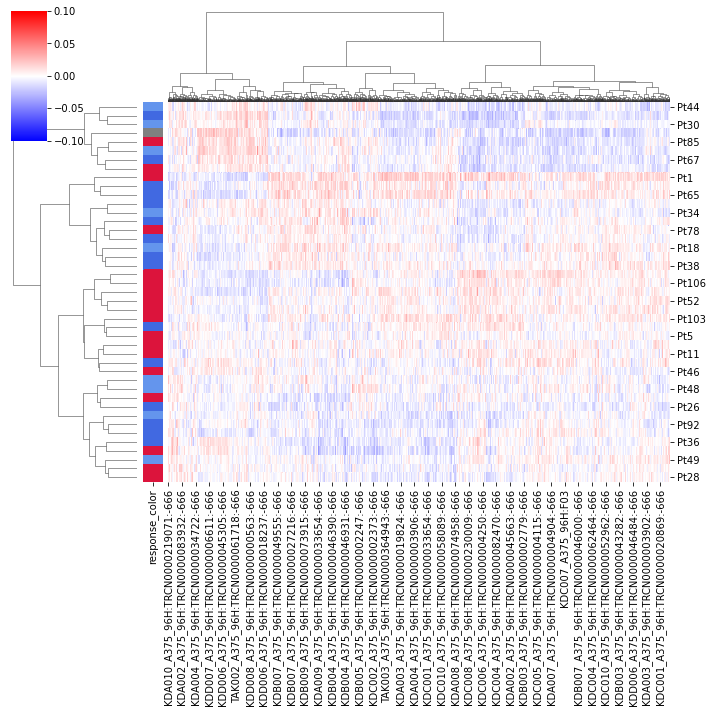

In [111]:
sns.clustermap(corr_patient_cell,
               row_colors=paired_91061['response_color'],
               vmin=-.1, vmax=.1, cmap='bwr', method='ward')

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


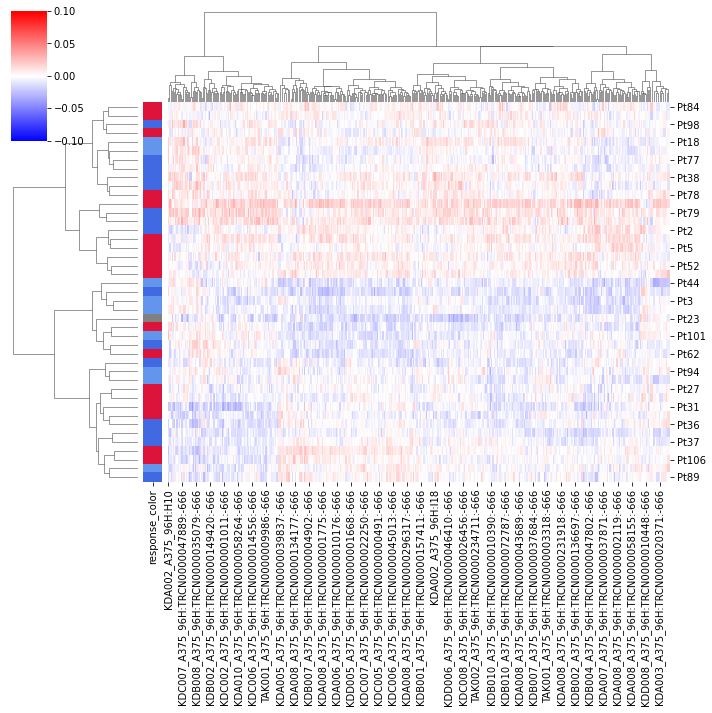

In [113]:
sns.clustermap(corr_patient_cell[shifting_cutoff['A375']['R-to-S'].index],
               row_colors=paired_91061['response_color'],
               vmin=-.1, vmax=.1, cmap='bwr', method='ward')

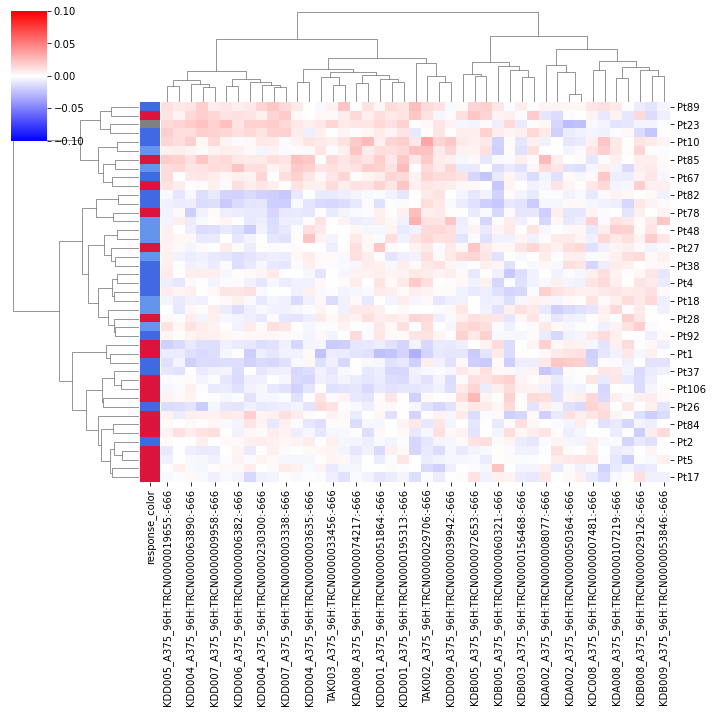

In [114]:
sns.clustermap(corr_patient_cell[shifting_cutoff['A375']['S-to-R'].index],
               row_colors=paired_91061['response_color'],
               vmin=-.1, vmax=.1, cmap='bwr', method='ward')

In [116]:
shifting_cutoff['A375']['R-to-S']

NREC_profile  REC_profile cmap_name  \
KDA005_A375_96H:TRCN0000000870:-666     -0.342639     0.497316      PLK2   
KDA005_A375_96H:A09                     -0.342639     0.497316      PLK2   
KDA002_A375_96H:H10                     -0.418181     0.418882      FBP1   
TAK001_A375_96H:TRCN0000002004:-666     -0.357131     0.457738    PRKACB   
KDB008_A375_96H:TRCN0000019234:-666     -0.374969     0.434806      PHF2   
...                                           ...          ...       ...   
KDB008_A375_96H:TRCN0000002119:-666     -0.299137     0.301980   PIK3C2B   
KDB008_A375_96H:TRCN0000051815:-666     -0.324560     0.276555    SKIV2L   
KDA002_A375_96H:TRCN0000061801:-666     -0.322936     0.277803     AXIN1   
KDA002_A375_96H:TRCN0000002430:-666     -0.329366     0.271281    CDC25A   
KDC002_A375_96H:TRCN0000017966:-666     -0.296641     0.303543      PBX4   

                                     nearest_dose  pert_idose  shift_ability  
KDA005_A375_96H:TRCN0000000870:-666           NaN         NaN       0.839955  
KDA005_A375_96H:A09                           NaN         NaN       0.839955  
KDA002_A375_96H:H10                           NaN         NaN       0.837063  
TAK001_A375_96H:TRCN0000002004:-666           NaN         NaN       0.814869  
KDB008_A375_96H:TRCN0000019234:-666           NaN         NaN       0.809775  
...                                           ...         ...            ...  
KDB008_A375_96H:TRCN0000002119:-666           NaN         NaN       0.601117  
KDB008_A375_96H:TRCN0000051815:-666           NaN         NaN       0.601115  
KDA002_A375_96H:TRCN0000061801:-666           NaN         NaN       0.600739  
KDA002_A375_96H:TRCN0000002430:-666           NaN         NaN       0.600647  
KDC002_A375_96H:TRCN0000017966:-666           NaN         NaN       0.600184  

[429 rows x 6 columns]

In [117]:
# dichotomize
op_skcm_dich = op_skcm_trt_sh.copy()
op_skcm_dich = op_skcm_dich[op_skcm_dich <= 1].fillna(1)
op_skcm_dich = op_skcm_dich[op_skcm_dich >= -1].fillna(-1)
op_skcm_dich = op_skcm_dich[(op_skcm_dich == 1)|(op_skcm_dich == -1)].fillna(0)

In [118]:
op_skcm_dich

DER001_A375_96H:TRCN0000002228:-666  \
rid                                            
ADA                                      0.0   
CDH2                                     1.0   
AKT3                                     0.0   
MED6                                     0.0   
NAALAD2                                 -1.0   
...                                      ...   
CDH1                                     0.0   
SLC12A6                                 -1.0   
PTBP3                                    0.0   
DGCR2                                   -1.0   
SCO2                                     0.0   

         DER001_A375_96H:TRCN0000017935:-666  \
rid                                            
ADA                                      1.0   
CDH2                                    -1.0   
AKT3                                     0.0   
MED6                                     0.0   
NAALAD2                                  0.0   
...                                      ...   
CDH1                                     1.0   
SLC12A6                                  0.0   
PTBP3                                    0.0   
DGCR2                                    1.0   
SCO2                                    -1.0   

         DER001_A375_96H:TRCN0000027180:-666  \
rid                                            
ADA                                      1.0   
CDH2                                    -1.0   
AKT3                                    -1.0   
MED6                                     0.0   
NAALAD2                                  1.0   
...                                      ...   
CDH1                                     0.0   
SLC12A6                                  1.0   
PTBP3                                    0.0   
DGCR2                                    1.0   
SCO2                                     0.0   

         DER001_A375_96H:TRCN0000049185:-666  \
rid                                            
ADA                                      1.0   
CDH2                                    -1.0   
AKT3                                     0.0   
MED6                                     0.0   
NAALAD2                                  1.0   
...                                      ...   
CDH1                                     1.0   
SLC12A6                                  0.0   
PTBP3                                    0.0   
DGCR2                                    1.0   
SCO2                                     0.0   

         DER001_A375_96H:TRCN0000051206:-666  \
rid                                            
ADA                                      0.0   
CDH2                                     0.0   
AKT3                                     0.0   
MED6                                     0.0   
NAALAD2                                  0.0   
...                                      ...   
CDH1                                     1.0   
SLC12A6                                  0.0   
PTBP3                                    0.0   
DGCR2                                    0.0   
SCO2                                     0.0   

         DER001_A375_96H:TRCN0000052077:-666  \
rid                                            
ADA                                      0.0   
CDH2                                    -1.0   
AKT3                                     0.0   
MED6                                     0.0   
NAALAD2                                  0.0   
...                                      ...   
CDH1                                     1.0   
SLC12A6                                  0.0   
PTBP3                                    0.0   
DGCR2                                    1.0   
SCO2                                     1.0   

         DER001_A375_96H:TRCN0000116501:-666  \
rid                                            
ADA                                      1.0   
CDH2                                     0.0   
AKT3                                     0.0   
MED6               

In [131]:
# consensus response
con_nr_expr = op_91061_gene[paired_91061[paired_91061['response'] == 'PD'].index].mean(axis=1)
con_r_expr = op_91061_gene[paired_91061[paired_91061['response'] != 'PD'].index].mean(axis=1)
con_merged = df(columns=['PD1_NR', 'PD1_R'])
con_merged['PD1_NR'] = con_nr_expr
con_merged['PD1_R'] = con_r_expr

<AxesSubplot:xlabel='PD1_NR', ylabel='PD1_R'>

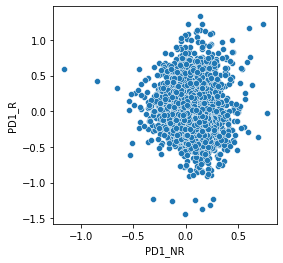

In [132]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x='PD1_NR', y='PD1_R', data=con_merged)

In [133]:
tmp_con_merged = con_merged.copy()
tmp_con_merged['r2s_shift'] = op_skcm_dich[shifting_cutoff['A375']['R-to-S'].index[0]]
tmp_con_merged['s2r_shift'] = op_skcm_dich[shifting_cutoff['A375']['S-to-R'].index[-1]]

In [135]:
tmp_con_merged['R-NR'] = tmp_con_merged['PD1_R'] - tmp_con_merged['PD1_NR']

In [151]:
for g in tmp_con_merged.index:
    if tmp_con_merged.loc[g, 'PD1_NR'] < 0:
        tmp_con_merged.at[g, 'PD1_NR_dich'] = -1
    elif tmp_con_merged.loc[g, 'PD1_NR'] > 0:
        tmp_con_merged.at[g, 'PD1_NR_dich'] = 1
    else:
        tmp_con_merged.at[g, 'PD1_NR_dich'] = 0
        
    if tmp_con_merged.loc[g, 'PD1_R'] < 0:
        tmp_con_merged.at[g, 'PD1_R_dich'] = -1
    elif tmp_con_merged.loc[g, 'PD1_R'] > 0:
        tmp_con_merged.at[g, 'PD1_R_dich'] = 1
    else:
        tmp_con_merged.at[g, 'PD1_R_dich'] = 0

In [152]:
tmp_con_merged

PD1_NR     PD1_R  r2s_shift  s2r_shift      R-NR  PD1_NR_dich  \
A2M     0.340822  0.372463        0.0       -1.0  0.031641          1.0   
A4GALT -0.019403  0.265979        1.0        0.0  0.285382         -1.0   
AAAS    0.102213 -0.138435        0.0       -1.0 -0.240649          1.0   
AACS    0.159473 -0.215346       -1.0        0.0 -0.374819          1.0   
AADAC   0.283644  0.204869        0.0        0.0 -0.078776          1.0   
...          ...       ...        ...        ...       ...          ...   
ZWINT   0.008575 -0.331573        0.0        1.0 -0.340148          1.0   
ZXDC    0.130400 -0.006601        1.0        0.0 -0.137001          1.0   
ZYX     0.053053  0.204133       -1.0        0.0  0.151080          1.0   
ZZEF1   0.100430  0.012153        0.0        0.0 -0.088277          1.0   
ZZZ3    0.125497 -0.144224        0.0        0.0 -0.269721          1.0   

        PD1_R_dich  
A2M            1.0  
A4GALT         1.0  
AAAS          -1.0  
AACS          -1.0  
AADAC          1.0  
...            ...  
ZWINT         -1.0  
ZXDC          -1.0  
ZYX            1.0  
ZZEF1          1.0  
ZZZ3          -1.0  

[10157 rows x 7 columns]

<Figure size 288x288 with 0 Axes>

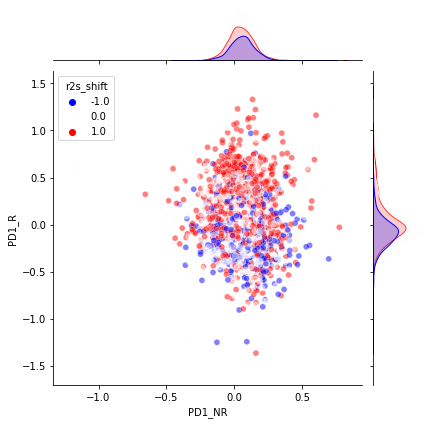

In [181]:
plt.figure(figsize=(4, 4))
sns.jointplot(x='PD1_NR', y='PD1_R', hue='r2s_shift', data=tmp_con_merged, palette='bwr', alpha=.5)


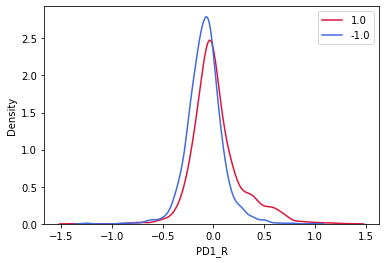

In [177]:
tmp_color = {1: 'crimson', -1: 'royalblue'}
for k in tmp_con_merged['r2s_shift'].unique():
    if k != 0:
        sns.kdeplot(x='PD1_R', data=tmp_con_merged[tmp_con_merged['r2s_shift'] == k],
                    label=k, c=tmp_color[k])
plt.legend()
plt.show()

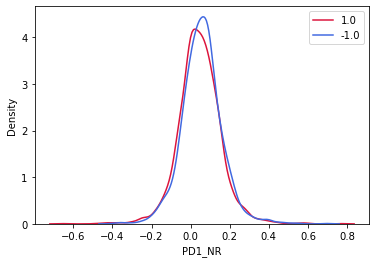

In [176]:
tmp_color = {1: 'crimson', -1: 'royalblue'}
for k in tmp_con_merged['r2s_shift'].unique():
    if k != 0:
        sns.kdeplot(x='PD1_NR', data=tmp_con_merged[tmp_con_merged['r2s_shift'] == k],
                    label=k, c=tmp_color[k])
plt.legend()
plt.show()

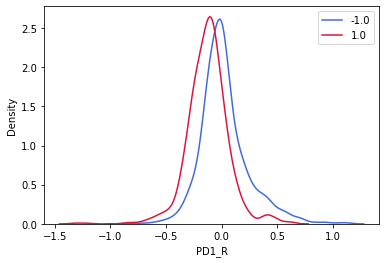

In [171]:
tmp_color = {1: 'crimson', -1: 'royalblue'}
for k in tmp_con_merged['s2r_shift'].unique():
    if k != 0:
        sns.kdeplot(x='PD1_R', data=tmp_con_merged[tmp_con_merged['s2r_shift'] == k], label=k, c=tmp_color[k])
plt.legend()
plt.show()

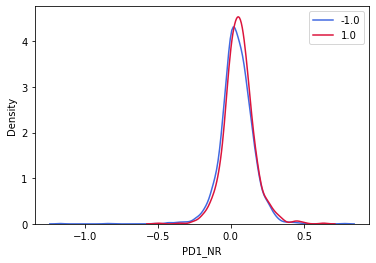

In [172]:
tmp_color = {1: 'crimson', -1: 'royalblue'}
for k in tmp_con_merged['s2r_shift'].unique():
    if k != 0:
        sns.kdeplot(x='PD1_NR', data=tmp_con_merged[tmp_con_merged['s2r_shift'] == k], label=k, c=tmp_color[k])
plt.legend()
plt.show()

<AxesSubplot:>

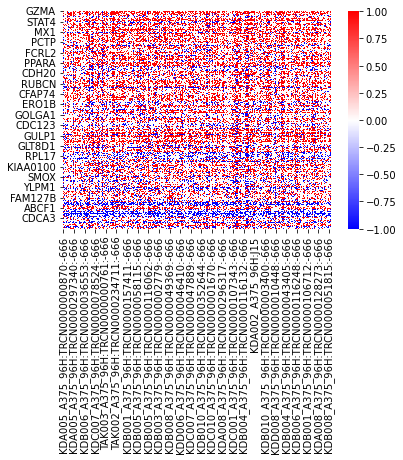

In [156]:
# heatmap, sorted by consensus response
tmp_r2s = op_skcm_dich[shifting_cutoff['A375']['R-to-S'].index]
tmp_order = tmp_con_merged.sort_values(by='PD1_R', ascending=False)
sns.heatmap(tmp_r2s.loc[tmp_order.index, :], cmap='bwr')

<AxesSubplot:>

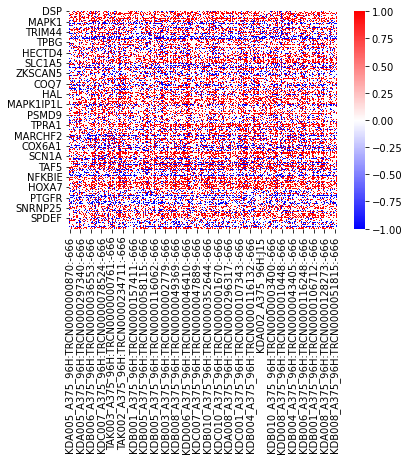

In [157]:
# heatmap, sorted by consensus response
tmp_r2s = op_skcm_dich[shifting_cutoff['A375']['R-to-S'].index]
tmp_order = tmp_con_merged.sort_values(by='PD1_NR', ascending=False)
sns.heatmap(tmp_r2s.loc[tmp_order.index, :], cmap='bwr')

<AxesSubplot:>

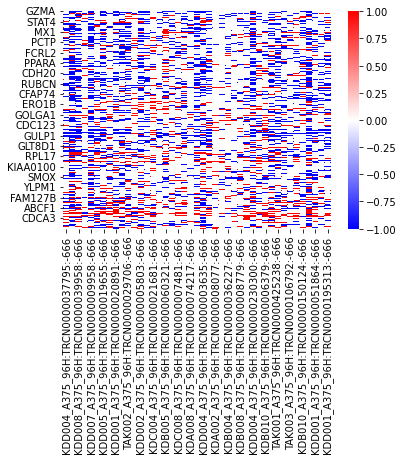

In [158]:
# heatmap, sorted by consensus response
tmp_r2s = op_skcm_dich[shifting_cutoff['A375']['S-to-R'].index]
tmp_order = tmp_con_merged.sort_values(by='PD1_R', ascending=False)
sns.heatmap(tmp_r2s.loc[tmp_order.index, :], cmap='bwr')

<AxesSubplot:>

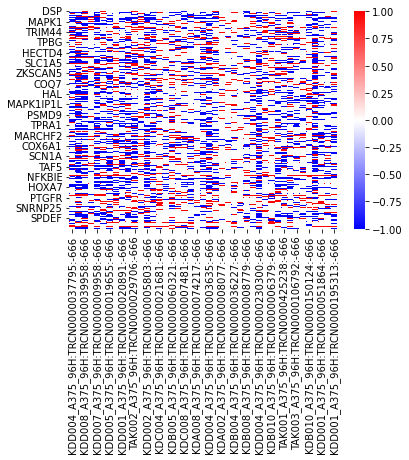

In [159]:
# heatmap, sorted by consensus response
tmp_r2s = op_skcm_dich[shifting_cutoff['A375']['S-to-R'].index]
tmp_order = tmp_con_merged.sort_values(by='PD1_NR', ascending=False)
sns.heatmap(tmp_r2s.loc[tmp_order.index, :], cmap='bwr')

<Figure size 288x288 with 0 Axes>

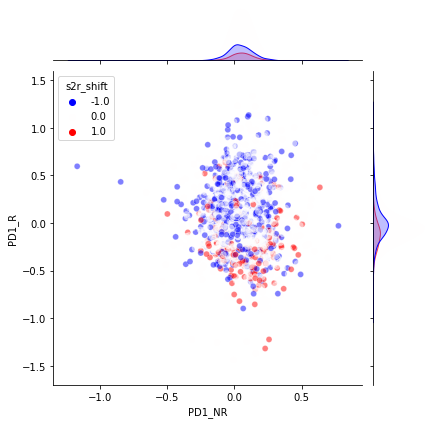

In [144]:
plt.figure(figsize=(4, 4))
sns.jointplot(x='PD1_NR', y='PD1_R', hue='s2r_shift', data=tmp_con_merged, palette='bwr', alpha=.5)

In [ ]:
enr_R_or = pd.concat(enr_R_100_or, axis=1).fillna(0)
enr_NR_or = pd.concat(enr_NR_100_or, axis=1).fillna(0)

In [157]:
enr_R_fdr.to_csv(poseidon_home + 'results/shRNA_top_pathway/enr_Rshifting_FDR.csv', sep=',')
enr_NR_fdr.to_csv(poseidon_home + 'results/shRNA_top_pathway/enr_NRshifting_FDR.csv', sep=',')
enr_R_or.to_csv(poseidon_home + 'results/shRNA_top_pathway/enr_Rshifting_OR.csv', sep=',')
enr_NR_or.to_csv(poseidon_home + 'results/shRNA_top_pathway/enr_NRshifting_OR.csv', sep=',')

In [23]:
# visualization
sns.clustermap(-np.log10(enr_R_fdr), figsize=(5, 13), cmap='Reds',
               method='ward', vmax=5, vmin=0)

NameError: name 'enr_R_fdr' is not defined

In [24]:
# visualization
sns.clustermap(-np.log10(enr_NR_fdr), figsize=(5, 13), cmap='Reds',
               method='ward', vmax=5, vmin=0)

NameError: name 'enr_NR_fdr' is not defined

Text(0.5, 1.0, 'A375')

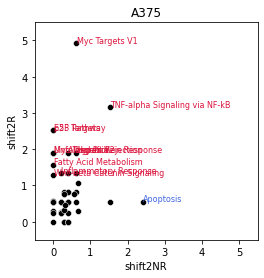

In [195]:
plt.figure(figsize=(4, 4))
tmp_merge = df(-np.log10(enr_NR_fdr['A375'])).rename(columns={'A375': 'shift2NR'})
tmp_merge['shift2R'] = -np.log10(enr_R_fdr['A375'])
sns.scatterplot(x='shift2NR', y='shift2R', data=tmp_merge, color='k')
for g in tmp_merge[(tmp_merge['shift2R'] - tmp_merge['shift2NR']) > 1].index:
    plt.text(x=tmp_merge.loc[g, 'shift2NR'] + 0.01, y=tmp_merge.loc[g, 'shift2R'] + 0.01, s=g, fontsize=8, c='crimson')
for g in tmp_merge[(tmp_merge['shift2NR'] - tmp_merge['shift2R']) > 1].index:
    plt.text(x=tmp_merge.loc[g, 'shift2NR'] + 0.01, y=tmp_merge.loc[g, 'shift2R'] + 0.01, s=g, fontsize=8, c='royalblue')
plt.xlim(-.5, 5.5)
plt.ylim(-.5, 5.5)
plt.title('A375')

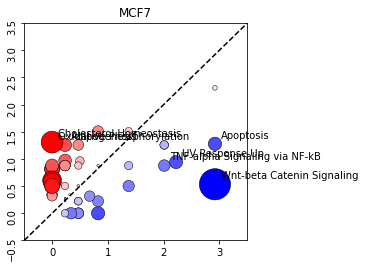

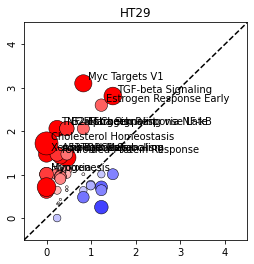

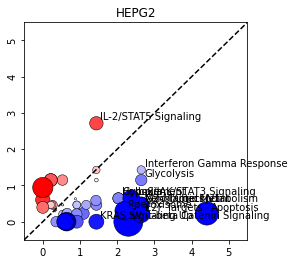

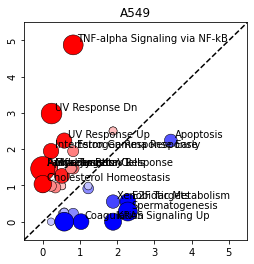

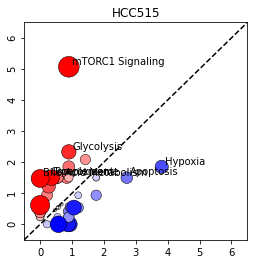

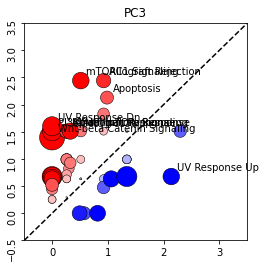

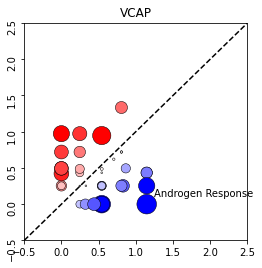

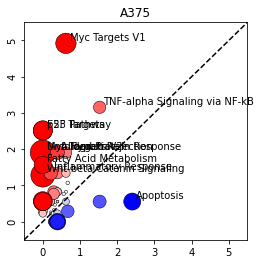

In [238]:
for cl in enr_R_fdr.columns:
    f, ax = plt.subplots(figsize=(4, 4))
    tmp_merge = df(-np.log10(enr_NR_fdr[cl])).rename(columns={cl: 'shift2NR'})
    tmp_merge['shift2R'] = -np.log10(enr_R_fdr[cl])
    
    # add odds ratio difference
    tmp_merge['or_diff'] = enr_R_or[cl] - enr_NR_or[cl]
    ax.scatter(
        x=tmp_merge['shift2NR'], y=tmp_merge['shift2R'],
        s=abs(tmp_merge['or_diff']) * 50, linewidths=0.5, edgecolors='k',
        c=tmp_merge['or_diff'], cmap=plt.cm.bwr, vmin=-5, vmax=5)
    
    # sns.scatterplot(x='shift2NR', y='shift2R', data=tmp_merge, color='k')

    for g in tmp_merge[(tmp_merge['shift2R'] - tmp_merge['shift2NR']) > 1].index:
        plt.text(x=tmp_merge.loc[g, 'shift2NR'] + 0.1, y=tmp_merge.loc[g, 'shift2R'] + 0.1, s=g, fontsize=10, c='k')
    for g in tmp_merge[(tmp_merge['shift2NR'] - tmp_merge['shift2R']) > 1].index:
        plt.text(x=tmp_merge.loc[g, 'shift2NR'] + 0.1, y=tmp_merge.loc[g, 'shift2R'] + 0.1, s=g, fontsize=10, c='k')
    plt.xlim(-.5,  np.ceil(max(tmp_merge['shift2NR'].max(), tmp_merge['shift2R'].max())) + 0.5)
    plt.ylim(-.5,  np.ceil(max(tmp_merge['shift2NR'].max(), tmp_merge['shift2R'].max())) + 0.5)
    ax.axline((1, 1), slope=1, ls='--', c='k')
    plt.yticks(rotation=90)
    plt.title(cl)
    fig = plt.gcf()
    fig.savefig(poseidon_home + 'results/shRNA_top_pathway/pathway_bubble/' + cl + '.png', dpi=300, transparent=True)
    fig.savefig(poseidon_home + 'results/shRNA_top_pathway/pathway_bubble/' + cl + '.pdf', transparent=True)
    plt.show()

# Top cases

In [28]:
# A375
a375_r2s = shifting_cutoff['A375']['R-to-S']

a375_r2s_sig = skcm_trt_sh_original[a375_r2s.index]

NameError: name 'skcm_trt_sh_original' is not defined

In [670]:
a375_r2s_sig

KDA005_A375_96H:TRCN0000000870:-666  KDA005_A375_96H:A09  \
rid                                                                 
ADA                                 -0.40430             -0.40430   
CDH2                                 2.16700              2.16700   
AKT3                                -1.14035             -1.14035   
MED6                                -0.11910             -0.11910   
NAALAD2                              0.38565              0.38565   
...                                      ...                  ...   
CDH1                                 0.11820              0.11820   
SLC12A6                              1.56905              1.56905   
PTBP3                                3.07005              3.07005   
DGCR2                               -0.75200             -0.75200   
SCO2                                -1.29775             -1.29775   

         KDA002_A375_96H:H10  TAK001_A375_96H:TRCN0000002004:-666  \
rid                                                                 
ADA                 0.512263                             1.064743   
CDH2               -0.715375                            -1.102879   
AKT3               -0.413017                            -0.525234   
MED6                0.451995                             0.299774   
NAALAD2            -0.147660                             1.635719   
...                      ...                                  ...   
CDH1               -0.473046                            -0.022701   
SLC12A6             0.902238                             0.427581   
PTBP3               0.225524                            -0.113568   
DGCR2              -0.618710                             0.594465   
SCO2               -0.709277                             1.098249   

         KDB008_A375_96H:TRCN0000019234:-666  \
rid                                            
ADA                                -0.368419   
CDH2                               -2.317622   
AKT3                               -1.518128   
MED6                                0.102677   
NAALAD2                            -0.226251   
...                                      ...   
CDH1                                1.154689   
SLC12A6                             1.304987   
PTBP3                              -2.198517   
DGCR2                               0.416891   
SCO2                                2.329270   

         KDA002_A375_96H:TRCN0000050034:-666  \
rid                                            
ADA                                 1.268123   
CDH2                               -0.625956   
AKT3                               -0.326429   
MED6                                0.833575   
NAALAD2                             0.319530   
...                                      ...   
CDH1                               -0.359113   
SLC12A6                             0.821705   
PTBP3                               0.813130   
DGCR2                              -0.990353   
SCO2                               -0.561010   

         KDC003_A375_96H:TRCN0000019719:-666  \
rid                                            
ADA                                -0.412149   
CDH2                               -0.827986   
AKT3                               -0.920037   
MED6                                0.080211   
NAALAD2                            -1.059583   
...                                      ...   
CDH1                                0.842674   
SLC12A6                             0.384881   
PTBP3                              -1.089404   
DGCR2                               0.387179   
SCO2                                1.497845   

         KDC006_A375_96H:TRCN0000015207:-666  \
rid                                            
ADA                                -0.283901   
CDH2                               -1.436530   
AKT3                               -0.264825   
MED6                               -1.712055   
NAALAD2                             2.388328   
..

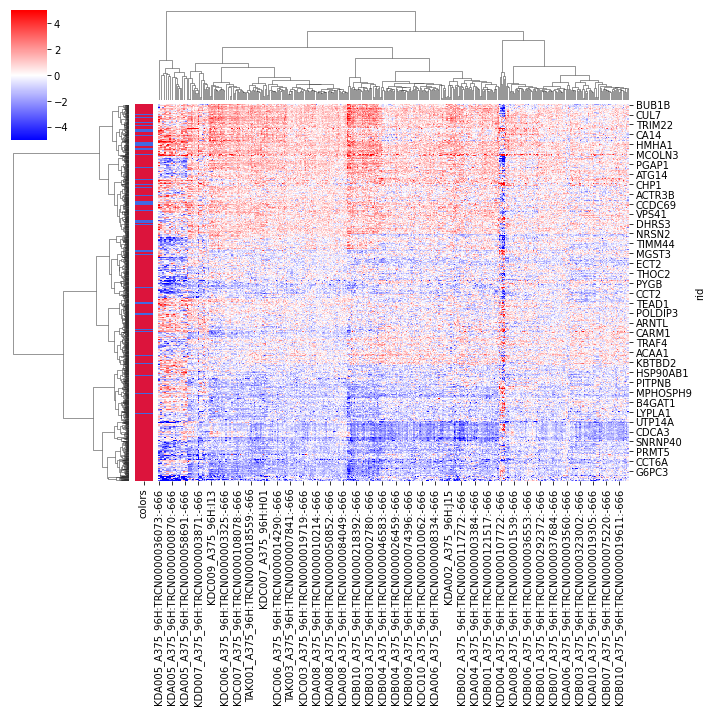

In [206]:
sns.clustermap(a375_r2s_sig[a375_r2s_sig.index.isin(ec_color.index)],
               method='ward', cmap='bwr', row_colors=ec_color,
               vmin=-5, vmax=5)

In [232]:
# sort average expression
tmp_order = df(a375_r2s_sig[a375_r2s_sig.index.isin(ec_color.index)].mean(axis=1)).sort_values(by=0, ascending=False)
tmp_order

0
rid            
ID2    1.714241
PTK2B  1.701531
TBX2   1.642483
GNAI1  1.528546
IKZF1  1.495578
...         ...
TPI1  -1.972924
UBE2C -2.019724
TKT   -2.180358
CDC20 -3.269958
LDHB  -3.946694

[1329 rows x 1 columns]

In [231]:
# sort average expression
tmp_order_all = df(a375_r2s_sig.mean(axis=1)).sort_values(by=0, ascending=False)
tmp_order_all

0
rid               
EPCAM     2.590267
SERPINA1  2.562785
VAV3      2.231615
FGFR3     2.214426
TF        2.166349
...            ...
TKT      -2.180358
UBE2S    -2.389192
COTL1    -2.794730
CDC20    -3.269958
LDHB     -3.946694

[10174 rows x 1 columns]

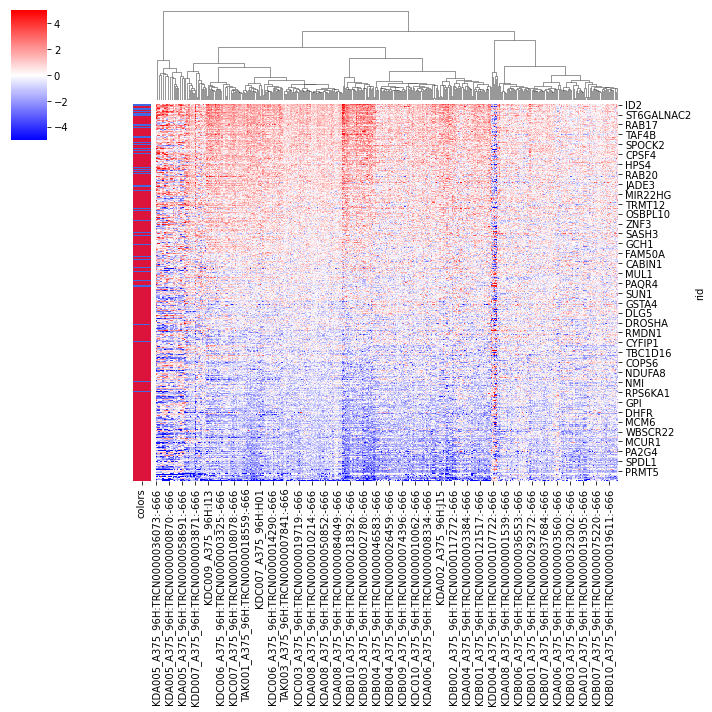

In [214]:
sns.clustermap(a375_r2s_sig.loc[tmp_order.index, :],
               row_cluster=False, row_colors=ec_color,
               method='ward', cmap='bwr',
               vmin=-5, vmax=5)

In [220]:
# shRNA knockdown efficiency
a375_r2s_kd = df(index=a375_r2s.index, columns=['cmap_name', 'gene_expr'])
a375_r2s_kd['cmap_name'] = a375_r2s['cmap_name']

for s in a375_r2s_kd.index:
    if a375_r2s_kd.loc[s, 'cmap_name'] in a375_r2s_sig.index:
        a375_r2s_kd.at[s, 'gene_expr'] = a375_r2s_sig.loc[a375_r2s_kd.loc[s, 'cmap_name'], s]
a375_r2s_kd = a375_r2s_kd.dropna(axis=0, how='any')
print(a375_r2s_kd.shape)

(375, 2)


In [238]:
a375_r2s_kd['shift_ability'] = a375_r2s['shift_ability']
a375_r2s_kd = a375_r2s_kd.sort_values(by='shift_ability', ascending=False)

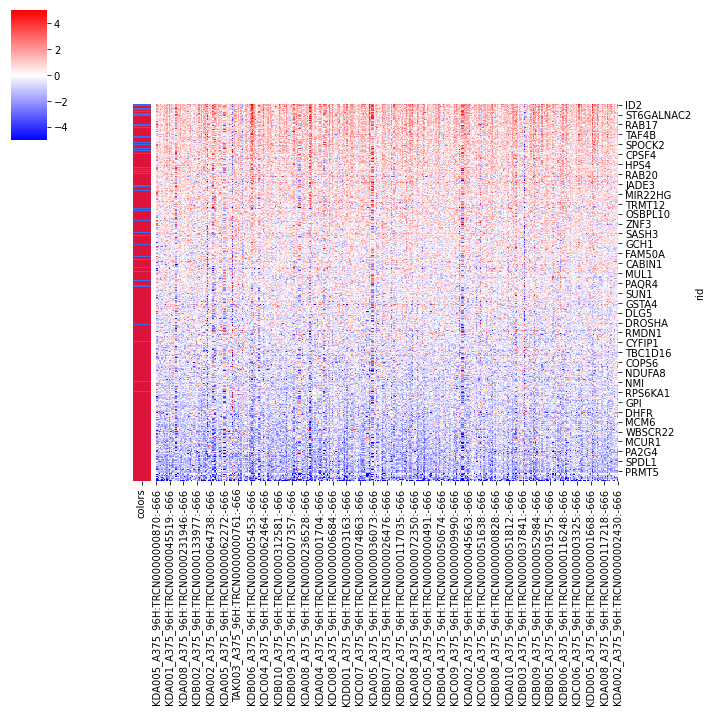

In [260]:
sns.clustermap(a375_r2s_sig.loc[tmp_order.index, a375_r2s_kd.sort_values(by='shift_ability', ascending=False).index],
               row_cluster=False, row_colors=ec_color,
               col_cluster=False,
               method='ward', cmap='bwr',
               vmin=-5, vmax=5)
fig = plt.gcf()
fig.savefig(panel_home + '/heatmap/RS_space_A375_sorted.png', dpi=300, transparent=True)

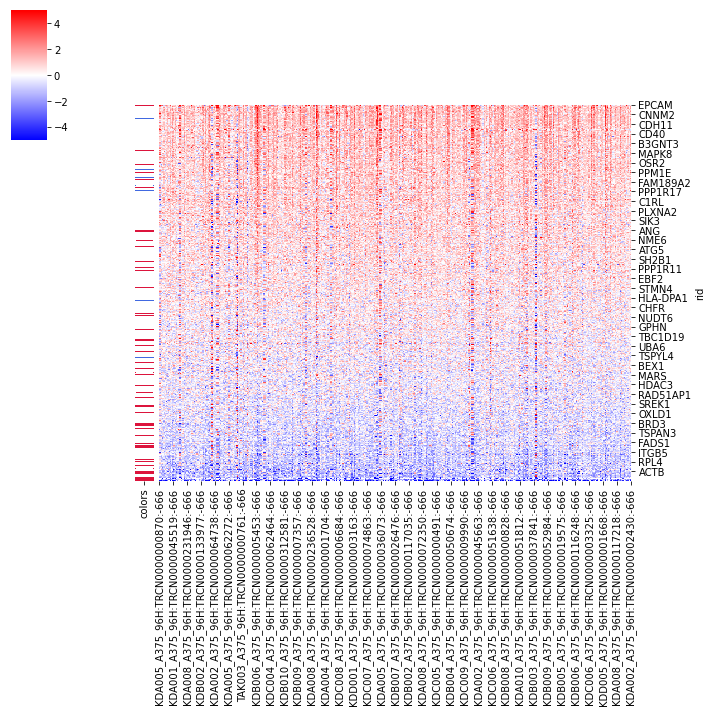

In [261]:
sns.clustermap(a375_r2s_sig.loc[tmp_order_all.index, a375_r2s_kd.sort_values(by='shift_ability', ascending=False).index],
               row_cluster=False, row_colors=ec_color,
               col_cluster=False,
               method='ward', cmap='bwr',
               vmin=-5, vmax=5)
fig = plt.gcf()
fig.savefig(panel_home + '/heatmap/whole_space_A375_sorted.png', dpi=300, transparent=True)

<AxesSubplot:xlabel='gene_expr', ylabel='shift_ability'>

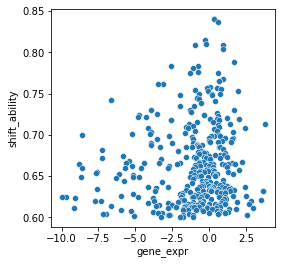

In [246]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x='gene_expr', y='shift_ability', data=a375_r2s_kd)

In [257]:
stats.pearsonr(a375_r2s_kd['gene_expr'], a375_r2s_kd['shift_ability'])

(0.11750968814621626, 0.022854470978596095)

([<matplotlib.axis.XTick at 0x7f9bde0e4280>], [Text(0, 0, '')])

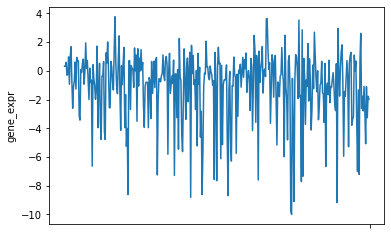

In [250]:
sns.lineplot(x=a375_r2s_kd.index, y='gene_expr', data=a375_r2s_kd)
plt.xticks('')

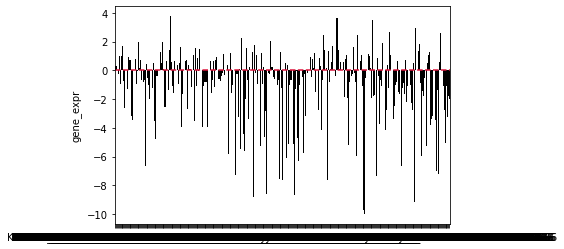

In [262]:
sns.barplot(x=a375_r2s_kd.index, y='gene_expr', data=a375_r2s_kd, color='k')
plt.axhline(y=0., ls='--', c='crimson')
fig = plt.gcf()
fig.savefig(panel_home + '/heatmap/shKD_A375_sorted.png', dpi=300, transparent=True)

In [273]:
a375_r2s_kd['gene_profile'] = 'unclassified'
for g in a375_r2s_kd.index:
    tmp_g = a375_r2s_kd.loc[g, 'cmap_name']
    if tmp_g in gene_sets['NREC_profile']:
        a375_r2s_kd.at[g, 'gene_profile'] = 'R_sig'
    elif tmp_g in gene_sets['REC_profile']:
        a375_r2s_kd.at[g, 'gene_profile'] = 'S_sig'

In [274]:
a375_r2s_kd['gene_profile'].value_counts()

unclassified    303
R_sig            61
S_sig            11
Name: gene_profile, dtype: int64

In [278]:
a375_r2s_kd[:50]

cmap_name  gene_expr  shift_ability  \
KDA005_A375_96H:TRCN0000000870:-666      PLK2     0.3216       0.839955   
KDA005_A375_96H:A09                      PLK2     0.3216       0.839955   
KDA002_A375_96H:H10                      FBP1   0.591233       0.837063   
TAK001_A375_96H:TRCN0000002004:-666    PRKACB  -0.303243       0.814869   
KDB008_A375_96H:TRCN0000019234:-666      PHF2  -0.218916       0.809775   
KDA002_A375_96H:TRCN0000050034:-666      FBP1   0.973148       0.809121   
KDC003_A375_96H:TRCN0000019719:-666      MCM7  -0.931999       0.809040   
KDC006_A375_96H:TRCN0000015207:-666    ZNF551   0.979616       0.803646   
KDA005_A375_96H:TRCN0000108199:-666     ZMIZ2     1.6847       0.788046   
KDC006_A375_96H:TRCN0000014556:-666      ILF2  -0.738915       0.783887   
KDB005_A375_96H:TRCN0000004045:-666      USP1    -2.6029       0.782776   
KDA001_A375_96H:TRCN0000045519:-666     ACSL1    -1.0923       0.780489   
KDA008_A375_96H:TRCN0000002119:-666   PIK3C2B  -0.713358       0.775799   
KDC010_A375_96H:TRCN0000061283:-666     ITPR2   0.617264       0.774829   
KDB003_A375_96H:TRCN0000323002:-666    INSIG1   -1.26641       0.774567   
KDA008_A375_96H:TRCN0000196524:-666     STK38   0.936887       0.767943   
KDA005_A375_96H:H02                    AKAP11    0.69705       0.765405   
KDA005_A375_96H:TRCN0000297340:-666    AKAP11    0.69705       0.765405   
TAK003_A375_96H:TRCN0000003829:-666     CCND3   -3.14365       0.762089   
KDB008_A375_96H:TRCN0000061970:-666     NOLC1   -3.43188       0.761332   
KDB010_A375_96H:TRCN0000033261:-666      KRAS   0.083859       0.757580   
KDC004_A375_96H:TRCN0000007400:-666   ARHGEF6  -0.110648       0.756723   
KDA008_A375_96H:TRCN0000231946:-666      CRKL   0.517047       0.756473   
KDC008_A375_96H:TRCN0000008805:-666      GNG4   0.817076       0.755996   
KDB005_A375_96H:TRCN0000004829:-666     HDAC4  -0.928401       0.753772   
KDA008_A375_96H:TRCN0000231918:-666      ETS1 -0.0354281       0.753489   
KDA002_A375_96H:TRCN0000034926:-666      ABAT     1.9486       0.752621   
KDB004_A375_96H:TRCN0000082833:-666    COL4A5    0.18129       0.749630   
KDB005_A375_96H:TRCN0000039589:-666       JUN   0.730466       0.749012   
KDB010_A375_96H:TRCN0000021278:-666      PAX8  -0.645556       0.748959   
KDB005_A375_96H:TRCN0000019808:-666      XBP1   -1.99441       0.748786   
KDB003_A375_96H:TRCN0000034937:-666    HS2ST1   0.189618       0.747962   
KDB005_A375_96H:TRCN0000064415:-666      ETFA  -0.811397       0.744922   
KDB002_A375_96H:TRCN0000133977:-666  FAM114A2  -0.644239       0.743159   
KDB006_A375_96H:TRCN0000036553:-666    MTHFD2   -6.64225       0.742719   
KDB004_A375_96H:TRCN0000048510:-666    SUCLG1   0.427527       0.740558   
KDC004_A375_96H:TRCN0000006512:-666     NFKB2  -0.552041       0.738924   
KDA010_A375_96H:M17                      RAF1   -0.99965       0.734611   
KDB007_A375_96H:TRCN0000037684:-666      CERK   -1.97453       0.734546   
KDC006_A375_96H:TRCN0000062214:-666    DYNLL1    -1.2651       0.730358   
KDC004_A375_96H:TRCN0000059724:-666     FABP6     1.7278       0.730220   
KDA009_A375_96H:TRCN0000019575:-666      MCM3    -3.9563       0.729721   
KDD004_A375_96H:TRCN0000036884:-666     GNA13   -1.24043       0.727265   
KDC008_A375_96H:TRCN0000043726:-666     KCNK2   0.522348       0.725865   
KDA002_A375_96H:TRCN0000064738:-666       ME2   -3.52596       0.725694   
KDB006_A375_96H:TRCN0000004105:-666     SENP6   -4.78282       0.724217   
KDA005_A375_96H:TRCN0000342903:-666     TCEB3    -0.3681       0.723811   
KDA005_A375_96H:M16                     TCEB3    -0.3681       0.723811   
KDA004_A375_96H:TRCN0000003907:-666     PSMB2    0.64345       0.722618   
KDA008_A375_96H:TRCN0000019595:-666      TLE1   -4.25058       0.721980   

                                     gene_profile  
KDA005_A375_96H:TRCN0000000870:-666  unclassified  
KDA005_A375_96H:A09                  unclassified  
KDA002_A375_96H:H10                         S_sig  
TA

In [284]:
a375_r2s['cmap_name'].value_counts()[:60]

JUN         4
CALR        4
CRKL        3
ME2         3
BLVRA       3
TGFBR2      3
RAF1        3
MCM3        3
FOXO4       2
MAP2K6      2
MYC         2
WDR61       2
NOLC1       2
TNFSF4      2
STK33       2
ACAA1       2
MAD2L1BP    2
TYMS        2
TCEB3       2
RIPK3       2
DROSHA      2
BRCA1       2
ABAT        2
AKAP11      2
MTHFD1      2
FBP1        2
GATA3       2
PTPN1       2
NKX2-3      2
RIT1        2
STK38       2
LHX2        2
ORMDL3      2
ERBB3       2
AKR1A1      2
IDH3B       2
MAP4K3      2
RRP12       2
NR2C2       2
PIK3C2B     2
JAG1        2
HS2ST1      2
GSK3B       2
NPM1        2
GFPT1       2
NDFIP1      2
ATG7        2
IRS1        2
F3          2
PAX8        2
PLK2        2
HRAS        2
NR2C1       2
AES         2
RARA        2
KDELR3      1
CD79B       1
SUCLG1      1
TRIB1       1
IL10RB      1
Name: cmap_name, dtype: int64

In [269]:
a375_r2s_ave

shift_ability
cmap_name               
PLK2            0.839955
FBP1            0.823092
PRKACB          0.814869
PHF2            0.809775
MCM7            0.809040
...                  ...
CD70            0.602338
SKIV2L          0.601115
AXIN1           0.600739
CDC25A          0.600647
PBX4            0.600184

[364 rows x 1 columns]

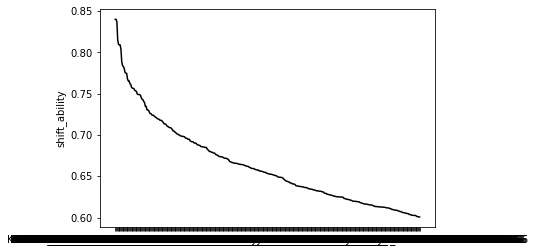

In [264]:
sns.lineplot(x=a375_r2s_kd.index, y='shift_ability', data=a375_r2s_kd, color='k')
fig = plt.gcf()
fig.savefig(panel_home + '/heatmap/shift_A375_sorted.png', dpi=300, transparent=True)

In [192]:
# sort
a375_r2s_ave = df(a375_r2s.groupby('cmap_name').mean()['shift_ability'])
a375_r2s_ave = a375_r2s_ave.sort_values(by='shift_ability', ascending=False)
a375_r2s_ave.head()

shift_ability
cmap_name               
PLK2            0.839955
FBP1            0.823092
PRKACB          0.814869
PHF2            0.809775
MCM7            0.809040

In [193]:
case_PLK2 = a375_r2s[a375_r2s['cmap_name'] == 'PLK2']
case_PLK2

NREC_profile  REC_profile cmap_name  \
KDA005_A375_96H:TRCN0000000870:-666     -0.342639     0.497316      PLK2   
KDA005_A375_96H:A09                     -0.342639     0.497316      PLK2   

                                     nearest_dose  pert_idose  shift_ability  
KDA005_A375_96H:TRCN0000000870:-666           NaN         NaN       0.839955  
KDA005_A375_96H:A09                           NaN         NaN       0.839955

In [198]:
case_PLK2_sig = df(a375_r2s_sig['KDA005_A375_96H:A09'])
case_PLK2_sig['gene_profile'] = 'unclassified'
case_PLK2_sig.at[gene_sets['NREC_profile'], 'gene_profile'] = 'R_sig'
case_PLK2_sig.at[gene_sets['REC_profile'], 'gene_profile'] = 'S_sig'

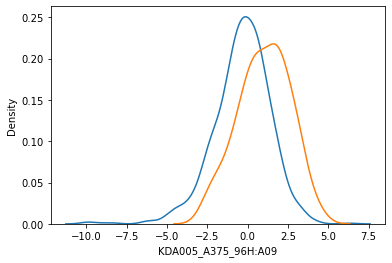

In [201]:
for i in ['R_sig', 'S_sig']:
    sns.kdeplot(case_PLK2_sig[case_PLK2_sig['gene_profile'] == i]['KDA005_A375_96H:A09'], label='i')

In [285]:
# A375
a375_s2r = shifting_cutoff['A375']['S-to-R']

a375_s2r_sig = skcm_trt_sh_original[a375_s2r.index]

In [286]:
# sort average expression
tmp_order_s2r = df(a375_s2r_sig[a375_s2r_sig.index.isin(ec_color.index)].mean(axis=1)).sort_values(by=0, ascending=False)
tmp_order_s2r

0
rid               
DKC1      1.345992
ZNF330    1.330931
NOLC1     1.283521
PRMT5     1.255645
CHEK2     1.251297
...            ...
RTN2     -1.221852
ROBO1    -1.249729
KIAA0196 -1.424463
CORO1A   -1.632966
SLC6A8   -1.912083

[1329 rows x 1 columns]

In [287]:
# shRNA knockdown efficiency
a375_s2r_kd = df(index=a375_s2r.index, columns=['cmap_name', 'gene_expr'])
a375_s2r_kd['cmap_name'] = a375_s2r['cmap_name']

for s in a375_s2r_kd.index:
    if a375_s2r_kd.loc[s, 'cmap_name'] in a375_s2r_sig.index:
        a375_s2r_kd.at[s, 'gene_expr'] = a375_s2r_sig.loc[a375_s2r_kd.loc[s, 'cmap_name'], s]
a375_s2r_kd = a375_s2r_kd.dropna(axis=0, how='any')
print(a375_s2r_kd.shape)

(37, 2)


In [308]:
a375_s2r_kd['shift_ability'] = a375_s2r['shift_ability']
a375_s2r_kd = a375_s2r_kd.sort_values(by='shift_ability', ascending=True)

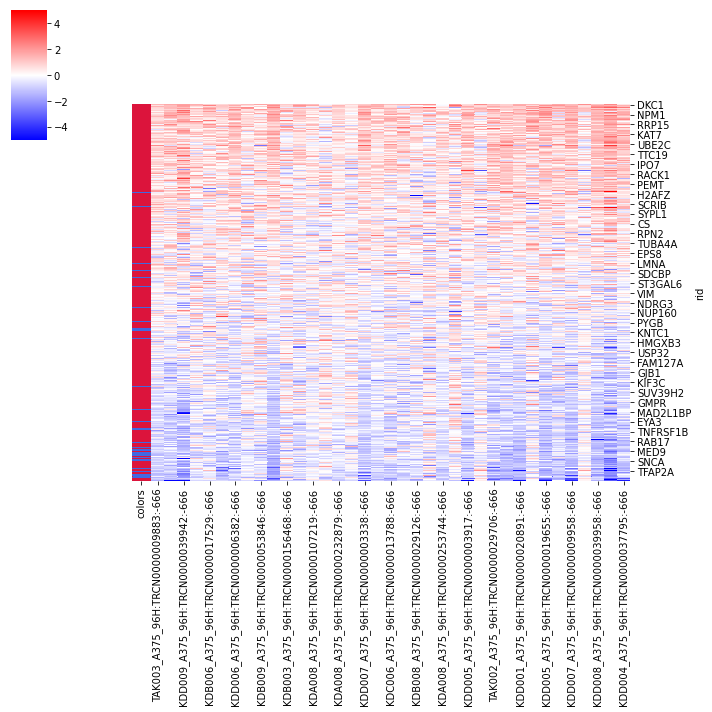

In [309]:
sns.clustermap(a375_s2r_sig.loc[tmp_order_s2r.index, a375_s2r_kd.sort_values(by='shift_ability', ascending=True).index],
               row_cluster=False, row_colors=ec_color,
               col_cluster=False,
               method='ward', cmap='bwr',
               vmin=-5, vmax=5)
fig = plt.gcf()
fig.savefig(panel_home + '/heatmap/s2r_RS_space_A375_sorted.png', dpi=300, transparent=True)

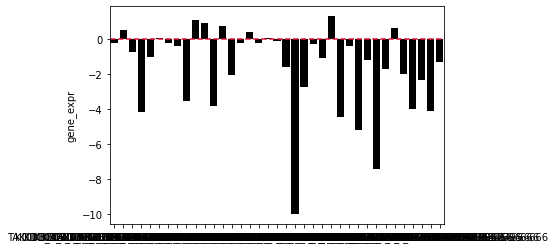

In [310]:
sns.barplot(x=a375_s2r_kd.index, y='gene_expr', data=a375_s2r_kd, color='k')
plt.axhline(y=0., ls='--', c='crimson')
fig = plt.gcf()
fig.savefig(panel_home + '/heatmap/s2r_shKD_A375_sorted.png', dpi=300, transparent=True)

In [312]:
a375_s2r_kd['gene_profile'] = 'unclassified'
for g in a375_s2r_kd.index:
    tmp_g = a375_s2r_kd.loc[g, 'cmap_name']
    if tmp_g in gene_sets['NREC_profile']:
        a375_s2r_kd.at[g, 'gene_profile'] = 'R_sig'
    elif tmp_g in gene_sets['REC_profile']:
        a375_s2r_kd.at[g, 'gene_profile'] = 'S_sig'

In [313]:
a375_s2r_kd

cmap_name  gene_expr  shift_ability  \
TAK003_A375_96H:TRCN0000009883:-666     EP300  -0.212253      -0.734635   
KDD001_A375_96H:TRCN0000051864:-666     DDAH1   0.523233      -0.703983   
KDD009_A375_96H:TRCN0000039942:-666   PRKAR1A     -0.699      -0.697668   
KDB010_A375_96H:TRCN0000150124:-666       MVP    -4.1753      -0.694294   
KDB006_A375_96H:TRCN0000017529:-666     HOXA5   -1.02852      -0.693064   
TAK001_A375_96H:TRCN0000425238:-666     VEGFC   0.109216      -0.678533   
KDD006_A375_96H:TRCN0000006382:-666      CRKL  -0.192061      -0.678023   
KDB010_A375_96H:TRCN0000006379:-666      CRKL  -0.392109      -0.673042   
KDB009_A375_96H:TRCN0000053846:-666      DSG2   -3.52185      -0.672555   
KDD004_A375_96H:TRCN0000230300:-666  SLC25A15    1.11845      -0.672292   
KDB003_A375_96H:TRCN0000156468:-666   TNFAIP1   0.949563      -0.670873   
KDB008_A375_96H:TRCN0000008779:-666    DNAJB6   -3.83871      -0.668502   
KDA008_A375_96H:TRCN0000107219:-666       DAP   0.741498      -0.665074   
KDB004_A375_96H:TRCN0000036227:-666      GLRX   -2.03692      -0.664413   
KDA008_A375_96H:TRCN0000232879:-666    RNF123  -0.175812      -0.661368   
KDA002_A375_96H:TRCN0000008077:-666    ADRA2C   0.421337      -0.658646   
KDD007_A375_96H:TRCN0000003338:-666      MMP1  -0.203262      -0.647471   
KDA008_A375_96H:TRCN0000074217:-666     LASP1  0.0614028      -0.647010   
KDC006_A375_96H:TRCN0000013788:-666    ARID3A  -0.101136      -0.641765   
KDC008_A375_96H:TRCN0000007481:-666      HSF1    -1.5646      -0.638582   
KDB008_A375_96H:TRCN0000029126:-666     VDAC1        -10      -0.627659   
KDB005_A375_96H:TRCN0000060321:-666     ABCB6      -2.73      -0.627496   
KDA008_A375_96H:TRCN0000253744:-666     OTUD3  -0.288786      -0.626852   
KDC004_A375_96H:TRCN0000021681:-666   POU2AF1   -1.03813      -0.626611   
KDD005_A375_96H:TRCN0000003917:-666     PSMB5    1.32288      -0.624483   
KDA002_A375_96H:M06                      PNKP   -4.44526      -0.619231   
TAK002_A375_96H:TRCN0000029706:-666      BLNK  -0.387785      -0.619165   
TAK003_A375_96H:TRCN0000033456:-666       BAD   -5.18294      -0.615691   
KDD001_A375_96H:TRCN0000020891:-666    GTF2F2   -1.15585      -0.612336   
KDB005_A375_96H:TRCN0000072653:-666    MRPL12   -7.39536      -0.609977   
KDD005_A375_96H:TRCN0000019655:-666     NR5A2    -1.6877      -0.608364   
KDD004_A375_96H:TRCN0000047848:-666      RHOB    0.67185      -0.606307   
KDD007_A375_96H:TRCN0000009958:-666     DAPK3   -1.96074      -0.606117   
KDA002_A375_96H:TRCN0000050364:-666      PNKP   -3.98582      -0.606087   
KDD008_A375_96H:TRCN0000039958:-666      CDK2   -2.30255      -0.604070   
KDD005_A375_96H:TRCN0000033456:-666       BAD   -4.07322      -0.602355   
KDD004_A375_96H:TRCN0000037795:-666    PIK3C3   -1.28784      -0.600492   

                                     gene_profile  
TAK003_A375_96H:TRCN0000009883:-666  unclassified  
KDD001_A375_96H:TRCN0000051864:-666  unclassified  
KDD009_A375_96H:TRCN0000039942:-666         R_sig  
KDB010_A375_96H:TRCN0000150124:-666  unclassified  
KDB006_A375_96H:TRCN0000017529:-666  unclassified  
TAK001_A375_96H:TRCN0000425238:-666  unclassified  
KDD006_A375_96H:TRCN0000006382:-666         R_sig  
KDB010_A375_96H:TRCN0000006379:-666         R_sig  
KDB009_A375_96H:TRCN0000053846:-666  unclassified  
KDD004_A375_96H:TRCN0000230300:-666  unclassified  
KDB003_A375_96H:TRCN0000156468:-666  unclassified  
KDB008_A375_96H:TRCN0000008779:-666  unclassified  
KDA008_A375_96H:TRCN0000107219:-666  unclassified  
KDB004_A375_96H:TRCN0000036227:-666         S_sig  
KDA008_A375_96H:TRCN0000232879:-666  unclassified  
KDA002_A375_96H:TRCN0000008077:-666  unclassified  
KDD007_A375_96H:TRCN0000003338:-666  unclassified  
KDA008_A375_96H:TRCN0000074217:-666  unclassified  
KDC006_A375_96H:TRCN0000013788:-666  unclassified  
KDC008_A375_96H:TRCN0000007481:-666         R_sig  
KDB008_A375_96H:TRCN0000029126:-666         R_sig  
KDB005_A375_96H:TRCN0000060321:-666      

# signature matrix

In [316]:
tmp = shRNA_result['SKCM']
a375_shift = tmp[tmp.index.isin(sig_info[sig_info['cell_iname'] == 'A375'].index)]

In [317]:
a375_shift

NREC_profile  REC_profile cmap_name  \
KDA005_A375_96H:TRCN0000000870:-666     -0.342639     0.497316      PLK2   
KDA005_A375_96H:A09                     -0.342639     0.497316      PLK2   
KDA002_A375_96H:H10                     -0.418181     0.418882      FBP1   
TAK001_A375_96H:TRCN0000002004:-666     -0.357131     0.457738    PRKACB   
KDB008_A375_96H:TRCN0000019234:-666     -0.374969     0.434806      PHF2   
...                                           ...          ...       ...   
KDB010_A375_96H:TRCN0000150124:-666      0.318553    -0.375741       MVP   
KDD009_A375_96H:TRCN0000039942:-666      0.283743    -0.413925   PRKAR1A   
KDD001_A375_96H:TRCN0000051864:-666      0.311558    -0.392425     DDAH1   
TAK003_A375_96H:TRCN0000009883:-666      0.298656    -0.435979     EP300   
KDD001_A375_96H:TRCN0000195313:-666      0.374614    -0.397508     MYLK2   

                                     nearest_dose  pert_idose  shift_ability  
KDA005_A375_96H:TRCN0000000870:-666           NaN         NaN       0.839955  
KDA005_A375_96H:A09                           NaN         NaN       0.839955  
KDA002_A375_96H:H10                           NaN         NaN       0.837063  
TAK001_A375_96H:TRCN0000002004:-666           NaN         NaN       0.814869  
KDB008_A375_96H:TRCN0000019234:-666           NaN         NaN       0.809775  
...                                           ...         ...            ...  
KDB010_A375_96H:TRCN0000150124:-666           NaN         NaN      -0.694294  
KDD009_A375_96H:TRCN0000039942:-666           NaN         NaN      -0.697668  
KDD001_A375_96H:TRCN0000051864:-666           NaN         NaN      -0.703983  
TAK003_A375_96H:TRCN0000009883:-666           NaN         NaN      -0.734635  
KDD001_A375_96H:TRCN0000195313:-666           NaN         NaN      -0.772121  

[2384 rows x 6 columns]

In [318]:
# signature target
a375_r_sig = a375_shift[a375_shift['cmap_name'].isin(gene_sets['NREC_profile'])]
a375_s_sig = a375_shift[a375_shift['cmap_name'].isin(gene_sets['REC_profile'])]

In [319]:
a375_r_sig.shape

(336, 6)

In [320]:
a375_s_sig.shape

(42, 6)

In [321]:
a375_r_sig_lv5 = skcm_trt_sh_original[a375_r_sig.index]
a375_s_sig_lv5 = skcm_trt_sh_original[a375_s_sig.index]

In [324]:
# shRNA knockdown efficiency
a375_r_sig_kd = df(index=a375_r_sig.index, columns=['cmap_name', 'gene_expr'])
a375_r_sig_kd['cmap_name'] = a375_r_sig['cmap_name']

for s in a375_r_sig_kd.index:
    if a375_r_sig_kd.loc[s, 'cmap_name'] in a375_r_sig_lv5.index:
        a375_r_sig_kd.at[s, 'gene_expr'] = a375_r_sig_lv5.loc[a375_r_sig_kd.loc[s, 'cmap_name'], s]
a375_r_sig_kd = a375_r_sig_kd.dropna(axis=0, how='any')
print(a375_r_sig_kd.shape)

(336, 2)


In [325]:
# shRNA knockdown efficiency
a375_s_sig_kd = df(index=a375_s_sig.index, columns=['cmap_name', 'gene_expr'])
a375_s_sig_kd['cmap_name'] = a375_s_sig['cmap_name']

for s in a375_s_sig_kd.index:
    if a375_s_sig_kd.loc[s, 'cmap_name'] in a375_s_sig_lv5.index:
        a375_s_sig_kd.at[s, 'gene_expr'] = a375_s_sig_lv5.loc[a375_s_sig_kd.loc[s, 'cmap_name'], s]
a375_s_sig_kd = a375_s_sig_kd.dropna(axis=0, how='any')
print(a375_s_sig_kd.shape)

(42, 2)


In [349]:
a375_s_sig_kd['shift_ability'] = a375_s_sig['shift_ability']
a375_s_sig_kd = a375_s_sig_kd.sort_values(by='shift_ability', ascending=True)
a375_r_sig_kd['shift_ability'] = a375_r_sig['shift_ability']
a375_r_sig_kd = a375_r_sig_kd.sort_values(by='shift_ability', ascending=False)

In [350]:
# sort average expression only use selected sig
tmp_order_r = df(a375_r_sig_lv5[a375_r_sig_lv5.index.isin(ec_color.index)][a375_r_sig_kd[a375_r_sig_kd['shift_ability'] >= .5].index].mean(axis=1)).sort_values(by=0, ascending=False)
# sort average expression only use selected sig
tmp_order_s = df(a375_s_sig_lv5[a375_s_sig_lv5.index.isin(ec_color.index)][a375_s_sig_kd[a375_s_sig_kd['shift_ability'] <= -.5].index].mean(axis=1)).sort_values(by=0, ascending=False)

In [351]:
tmp_order_r

0
rid            
ID2    1.671836
PTK2B  1.528131
TRIB1  1.353371
CDH3   1.340897
TBX2   1.339792
...         ...
TPI1  -1.819073
TKT   -1.855435
UBE2C -1.938111
CDC20 -2.925000
LDHB  -3.571522

[1329 rows x 1 columns]

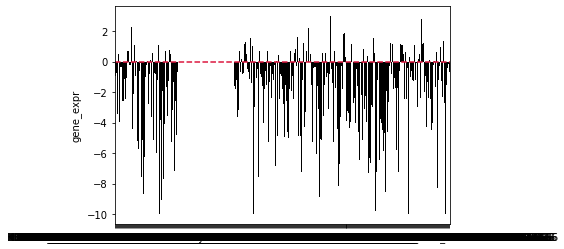

In [365]:
sns.barplot(x=a375_r_sig_kd.index, y='gene_expr', data=a375_r_sig_kd, color='k')
plt.axhline(y=0., ls='--', c='crimson')
fig = plt.gcf()
fig.savefig(panel_home + '/heatmap/r_sig_shKD_A375_sorted.pdf', dpi=300, transparent=True)

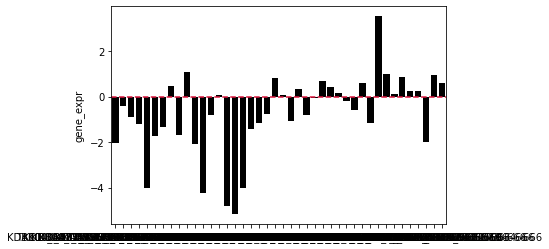

In [366]:
sns.barplot(x=a375_s_sig_kd.index, y='gene_expr', data=a375_s_sig_kd, color='k')
plt.axhline(y=0., ls='--', c='crimson')
fig = plt.gcf()
fig.savefig(panel_home + '/heatmap/s_sig_shKD_A375_sorted.pdf', dpi=300, transparent=True)

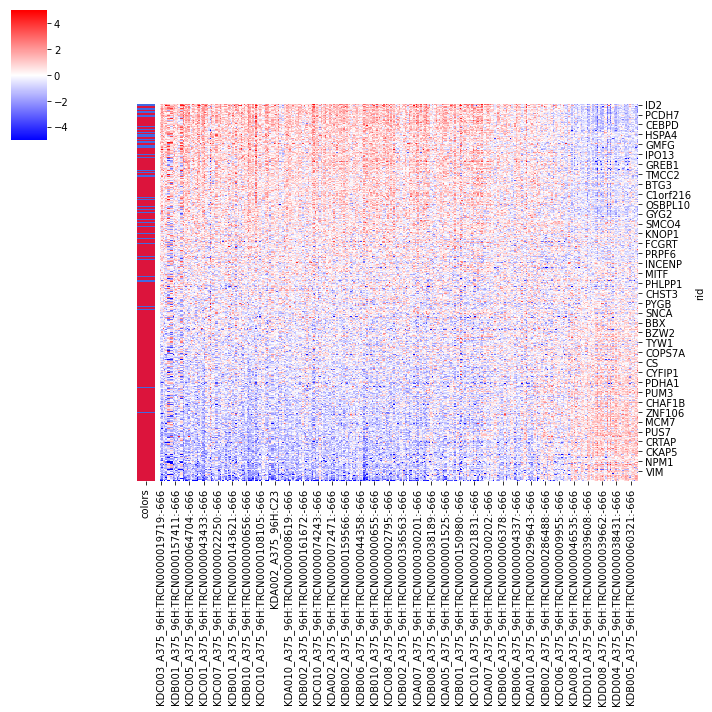

In [368]:
sns.clustermap(a375_r_sig_lv5.loc[tmp_order_r.index, a375_r_sig_kd.sort_values(by='shift_ability', ascending=False).index],
               row_cluster=False, row_colors=ec_color,
               col_cluster=False,
               method='ward', cmap='bwr',
               vmin=-5, vmax=5)
fig = plt.gcf()
fig.savefig(panel_home + '/heatmap/R_sig_RS_space_A375_sorted.png', dpi=300, transparent=True)

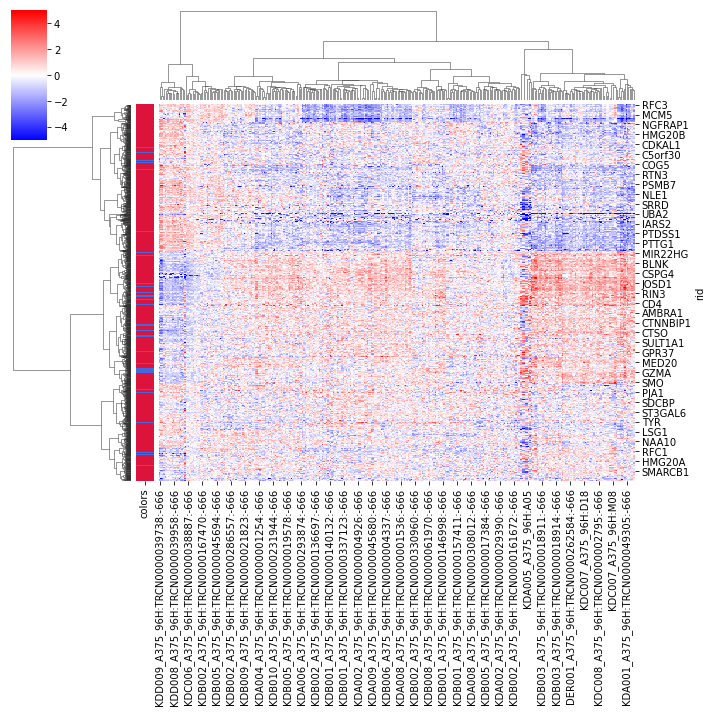

In [335]:
sns.clustermap(a375_r_sig_lv5.loc[tmp_order_r.index, :],
               row_colors=ec_color,
               method='ward', cmap='bwr', vmin=-5, vmax=5)

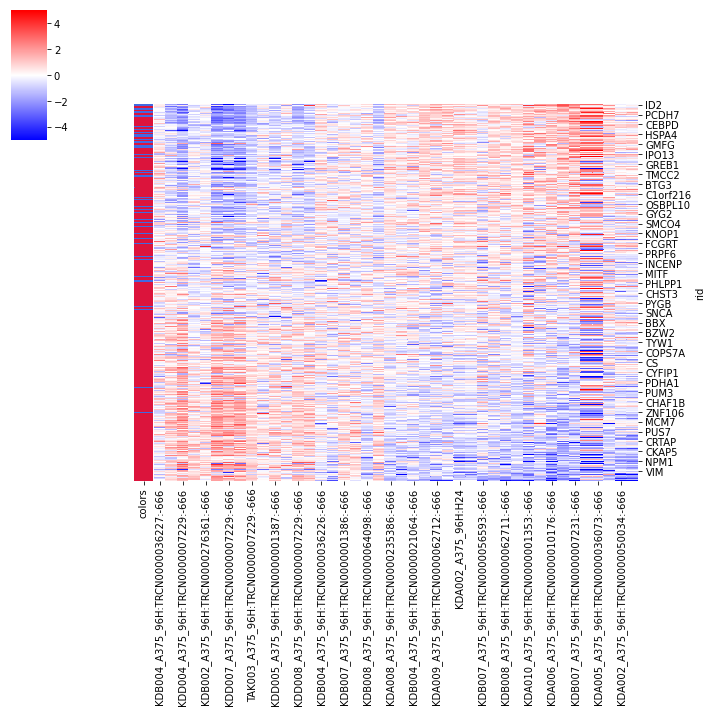

In [369]:
sns.clustermap(a375_s_sig_lv5.loc[tmp_order_r.index, a375_s_sig_kd.sort_values(by='shift_ability', ascending=True).index],
               row_cluster=False, row_colors=ec_color,
               col_cluster=False,
               method='ward', cmap='bwr',
               vmin=-5, vmax=5)
fig = plt.gcf()
fig.savefig(panel_home + '/heatmap/S_sig_RS_space_A375_sorted.pdf', dpi=300, transparent=True)

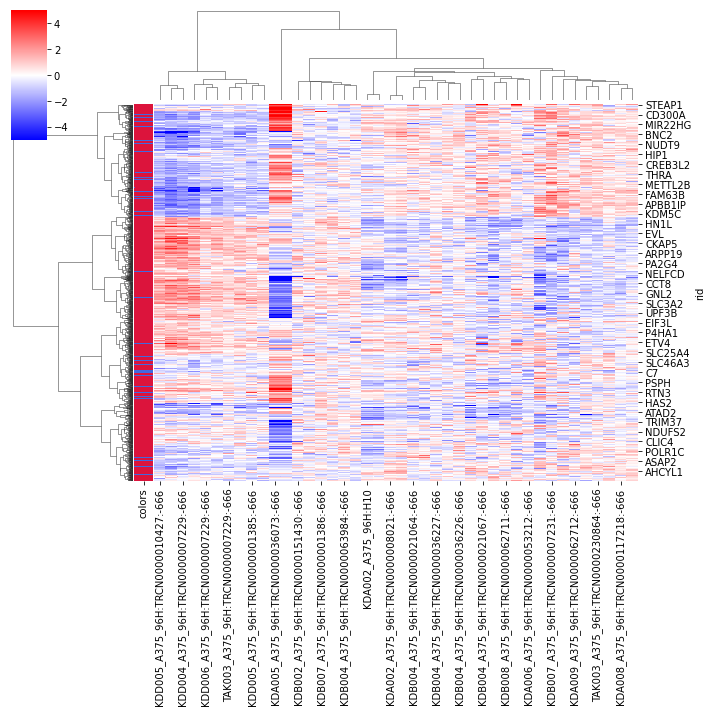

In [332]:
sns.clustermap(a375_s_sig_lv5.loc[tmp_order_s.index, :],
               row_colors=ec_color,
               method='ward', cmap='bwr', vmin=-5, vmax=5)

In [361]:
# cluster within signature classes
sig_class_order = []
for g in gene_sets.keys():
    tmp_g = gene_sets[g]
    tmp_r = a375_r_sig_lv5[a375_r_sig_lv5.index.isin(tmp_g)]
    print(g)
    c = sns.clustermap(tmp_r,
                       row_colors=ec_color,
                       method='ward', cmap='bwr', vmin=-5, vmax=5)
    sig_class_order.extend([tmp_r.index[i] for i in c.dendrogram_row.reordered_ind])
    plt.close()


NREC_profile
REC_profile


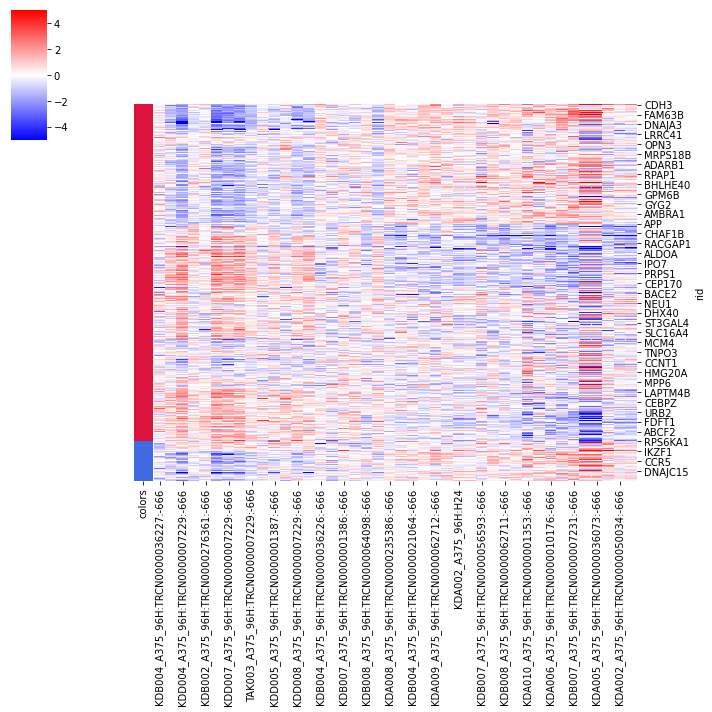

In [362]:
sns.clustermap(a375_s_sig_lv5.loc[sig_class_order, a375_s_sig_kd.sort_values(by='shift_ability', ascending=True).index],
               row_cluster=False, row_colors=ec_color,
               col_cluster=False,
               method='ward', cmap='bwr',
               vmin=-5, vmax=5)

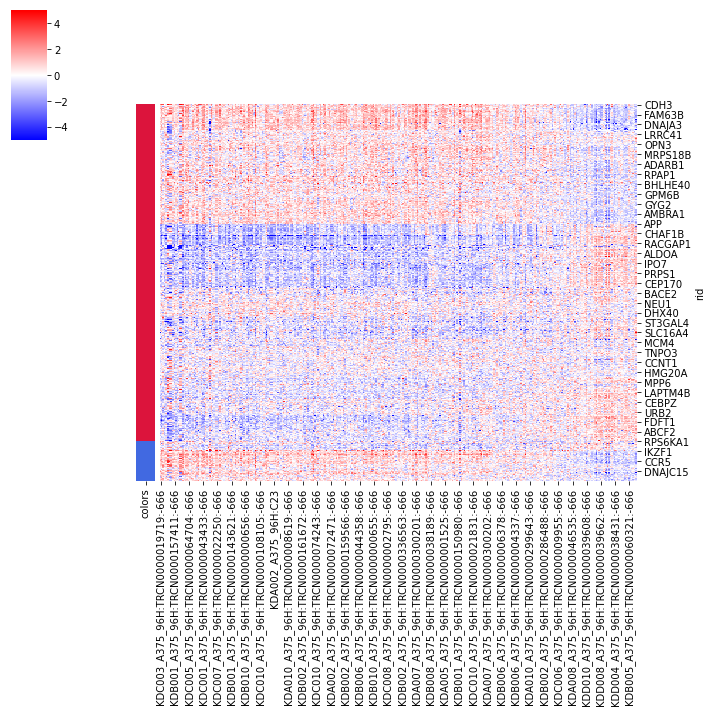

In [364]:
sns.clustermap(a375_r_sig_lv5.loc[sig_class_order, a375_r_sig_kd.sort_values(by='shift_ability', ascending=False).index],
               row_cluster=False, row_colors=ec_color,
               col_cluster=False,
               method='ward', cmap='bwr',
               vmin=-5, vmax=5)

# ES Heatmap

In [14]:
# signature targeting
r_sig_targeting = {}
s_sig_targeting = {}
for ct in shRNA_cancer:
    tmp_shift = shRNA_result[ct]
    tmp_sig = sig_info[sig_info.index.isin(tmp_shift.index)]

    for cl in tmp_sig['cell_mfc_name'].unique():
        tmp_shift_cl = tmp_shift[tmp_shift.index.isin(tmp_sig[tmp_sig['cell_mfc_name'] == cl].index)]
        r_sig_targeting[cl] = tmp_shift_cl[tmp_shift_cl['cmap_name'].isin(gene_sets['NREC_profile'])]
        s_sig_targeting[cl] = tmp_shift_cl[tmp_shift_cl['cmap_name'].isin(gene_sets['REC_profile'])]

In [15]:
r_sig_targeting.keys()

dict_keys(['MCF7', 'SW480', 'HT29', 'DLD1', 'HEPG2', 'A549', 'HCC515', 'PC3', 'VCAP', 'A375'])

MCF7


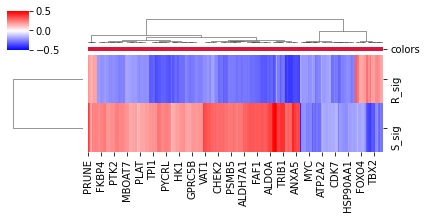

SW480


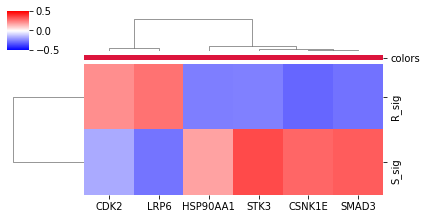

HT29


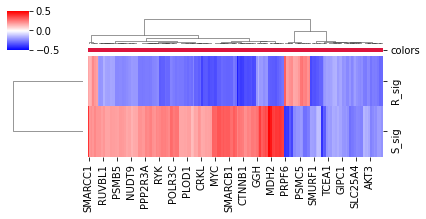

DLD1


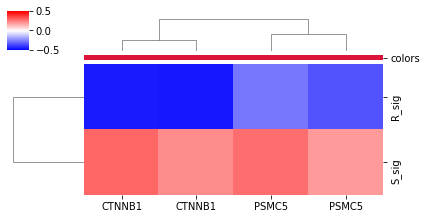

HEPG2


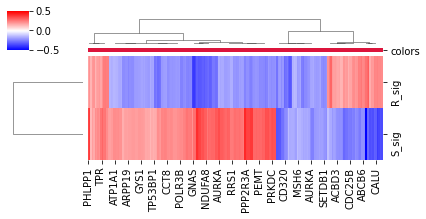

A549


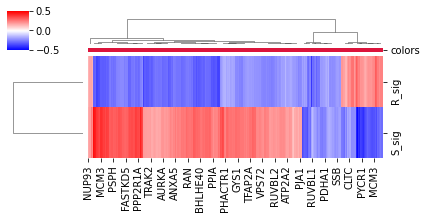

HCC515


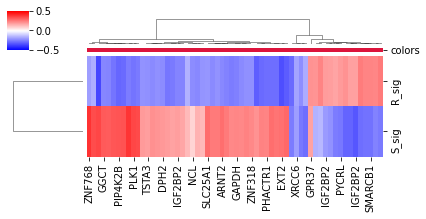

PC3


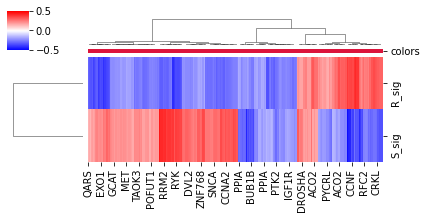

VCAP


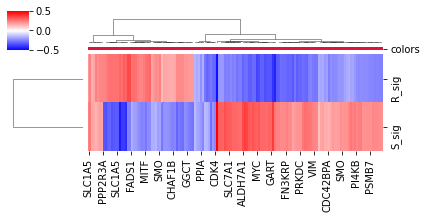

A375


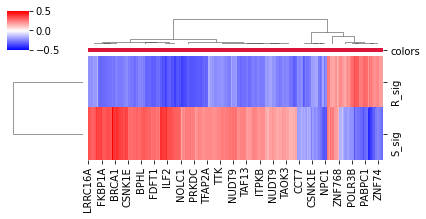

In [31]:
for cl in r_sig_targeting.keys():
    print(cl)
    tmp_es = df(columns=['R_sig', 'S_sig'])
    tmp_es['R_sig'] = r_sig_targeting[cl]['NREC_profile']
    tmp_es['S_sig'] = r_sig_targeting[cl]['REC_profile']
    tmp_es = tmp_es.rename(index=r_sig_targeting[cl]['cmap_name'])
    tmp_es = tmp_es.T
    sns.clustermap(tmp_es, col_colors=ec_color, figsize=(6, 3),
                   method='ward', cmap='bwr', vmin=-.5, vmax=.5)
    plt.show()

MCF7


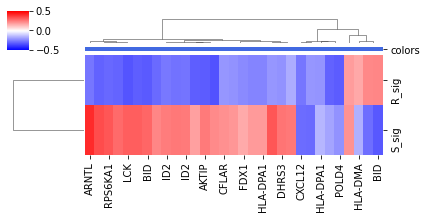

SW480


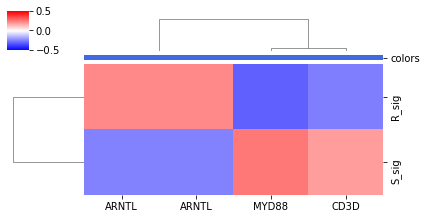

HT29


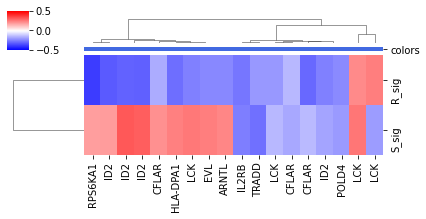

DLD1
HEPG2


/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:709: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, max_dependent_coord * 1.05)


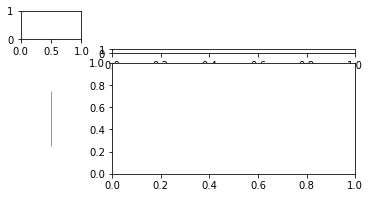

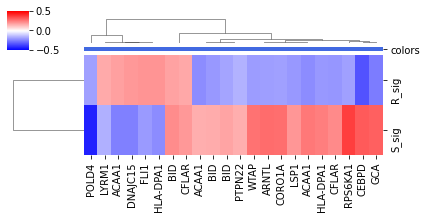

A549


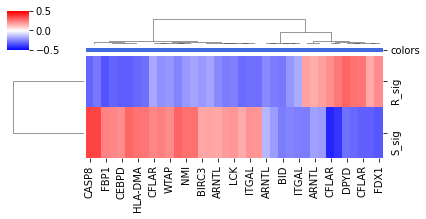

HCC515


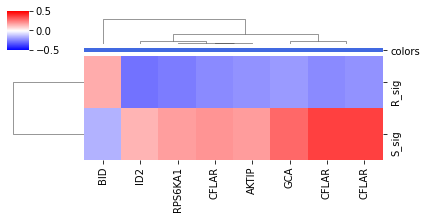

PC3


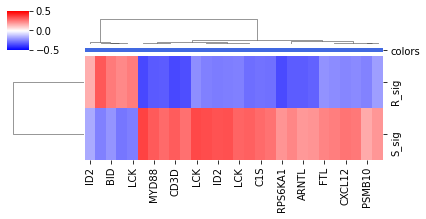

VCAP


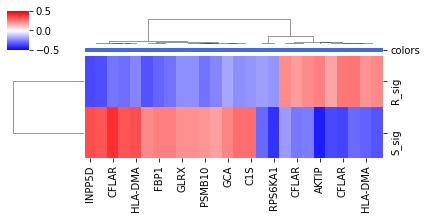

A375


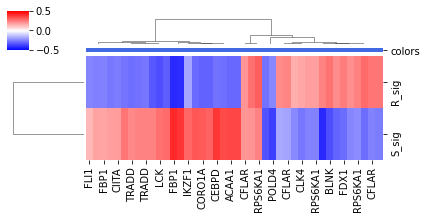

In [32]:
for cl in s_sig_targeting.keys():
    print(cl)
    tmp_es = df(columns=['R_sig', 'S_sig'])
    tmp_es['R_sig'] = s_sig_targeting[cl]['NREC_profile']
    tmp_es['S_sig'] = s_sig_targeting[cl]['REC_profile']
    tmp_es = tmp_es.rename(index=s_sig_targeting[cl]['cmap_name'])
    tmp_es = tmp_es.T
    try:
        sns.clustermap(tmp_es, col_colors=ec_color, figsize=(6, 3),
                       method='ward', cmap='bwr', vmin=-.5, vmax=.5)
        plt.show()
    except ValueError:
        pass

In [16]:
# shRNA KD efficiency
for ct in shRNA_cancer:
    tmp_lv5 = pd.read_csv(data_home + '/CMAP2020_Cancer/' + ct + '/CMAP2020_lv5_trt_sh_merged.csv',
                          header=0, index_col=0, sep=',')
    
    tmp_lv5.index = tmp_lv5.index.astype(int)
    tmp_lv5 = tmp_lv5[tmp_lv5.index.isin(bing_landmark.index)].rename(index=bing_landmark['Official NCBI gene symbol'])
    
    tmp_shift = shRNA_result[ct]
    tmp_sig = sig_info[sig_info.index.isin(tmp_shift.index)]

    for cl in tmp_sig['cell_mfc_name'].unique():
        if cl in r_sig_targeting.keys():
            tmp_r = r_sig_targeting[cl]
            tmp_s = s_sig_targeting[cl]
            
            for sig in tmp_r.index:
                if tmp_r.loc[sig, 'cmap_name'] in tmp_lv5.index:
                    r_sig_targeting[cl].at[sig, 'sh_z_score'] = tmp_lv5.loc[tmp_r.loc[sig, 'cmap_name'], sig]
            
            for sig in tmp_s.index:
                if tmp_s.loc[sig, 'cmap_name'] in tmp_lv5.index:
                    s_sig_targeting[cl].at[sig, 'sh_z_score'] = tmp_lv5.loc[tmp_s.loc[sig, 'cmap_name'], sig]
        print(cl + ' finished...')
    

MCF7 finished...
SW480 finished...
HT29 finished...
DLD1 finished...
HEPG2 finished...
A549 finished...
HCC515 finished...
PC3 finished...
VCAP finished...
A375 finished...


/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [17]:
# shRNA knockdown efficiency
r_sig_targeting['A375']

NREC_profile  REC_profile cmap_name  \
KDC003_A375_96H:TRCN0000019719:-666     -0.382115     0.426925      MCM7   
KDC006_A375_96H:TRCN0000014556:-666     -0.359206     0.424681      ILF2   
KDB008_A375_96H:TRCN0000061970:-666     -0.255152     0.506180     NOLC1   
KDA008_A375_96H:TRCN0000231946:-666     -0.380305     0.376168      CRKL   
KDA009_A375_96H:TRCN0000019575:-666     -0.343769     0.385953      MCM3   
...                                           ...          ...       ...   
KDB008_A375_96H:TRCN0000029126:-666      0.246009    -0.381650     VDAC1   
KDC008_A375_96H:TRCN0000007481:-666      0.261275    -0.377307      HSF1   
KDB010_A375_96H:TRCN0000006379:-666      0.310196    -0.362846      CRKL   
KDD006_A375_96H:TRCN0000006382:-666      0.351001    -0.327021      CRKL   
KDD009_A375_96H:TRCN0000039942:-666      0.283743    -0.413925   PRKAR1A   

                                     nearest_dose  pert_idose  shift_ability  \
KDC003_A375_96H:TRCN0000019719:-666           NaN         NaN       0.809040   
KDC006_A375_96H:TRCN0000014556:-666           NaN         NaN       0.783887   
KDB008_A375_96H:TRCN0000061970:-666           NaN         NaN       0.761332   
KDA008_A375_96H:TRCN0000231946:-666           NaN         NaN       0.756473   
KDA009_A375_96H:TRCN0000019575:-666           NaN         NaN       0.729721   
...                                           ...         ...            ...   
KDB008_A375_96H:TRCN0000029126:-666           NaN         NaN      -0.627659   
KDC008_A375_96H:TRCN0000007481:-666           NaN         NaN      -0.638582   
KDB010_A375_96H:TRCN0000006379:-666           NaN         NaN      -0.673042   
KDD006_A375_96H:TRCN0000006382:-666           NaN         NaN      -0.678023   
KDD009_A375_96H:TRCN0000039942:-666           NaN         NaN      -0.697668   

                                     sh_z_score  
KDC003_A375_96H:TRCN0000019719:-666   -0.931999  
KDC006_A375_96H:TRCN0000014556:-666   -0.738915  
KDB008_A375_96H:TRCN0000061970:-666   -3.431877  
KDA008_A375_96H:TRCN0000231946:-666    0.517047  
KDA009_A375_96H:TRCN0000019575:-666   -3.956300  
...                                         ...  
KDB008_A375_96H:TRCN0000029126:-666  -10.000000  
KDC008_A375_96H:TRCN0000007481:-666   -1.564605  
KDB010_A375_96H:TRCN0000006379:-666   -0.392109  
KDD006_A375_96H:TRCN0000006382:-666   -0.192061  
KDD009_A375_96H:TRCN0000039942:-666   -0.699000  

[336 rows x 7 columns]

In [34]:
# concat on signature level
tmp_list = []
for c in r_sig_targeting.keys():
    tmp_c = r_sig_targeting[c]
    tmp_c['Cell Line'] = c
    tmp_list.append(tmp_c[['NREC_profile',
                           'REC_profile',
                           'sh_z_score',
                           'cmap_name',
                           'Cell Line',
                           'shift_ability']].rename(columns={'NREC_profile': 'EnrichmentScore Rsig',
                                                             'REC_profile': 'EnrichmentScore Ssig',
                                                             'sh_z_score': 'Target Expression',
                                                             'cmap_name': 'Target Name',
                                                             'shift_ability': 'Shift Ability'}))
tmp_r_merged = pd.concat(tmp_list, axis=0)
tmp_r_merged['Target Signature'] = 'R signature'

tmp_list = []
for c in s_sig_targeting.keys():
    tmp_c = s_sig_targeting[c]
    if tmp_c.shape[0] != 0:
        tmp_c['Cell Line'] = c
        tmp_list.append(tmp_c[['NREC_profile',
                               'REC_profile',
                               'sh_z_score',
                               'cmap_name',
                               'Cell Line',
                               'shift_ability']].rename(columns={'NREC_profile': 'EnrichmentScore Rsig',
                                                                 'REC_profile': 'EnrichmentScore Ssig',
                                                                 'sh_z_score': 'Target Expression',
                                                                 'cmap_name': 'Target Name',
                                                                 'shift_ability': 'Shift Ability'}))
tmp_s_merged = pd.concat(tmp_list, axis=0)
tmp_s_merged['Target Signature'] = 'S signature'

RS_mega = pd.concat([tmp_r_merged, tmp_s_merged], axis=0)

<ipython-input-34-d70da6b9f78e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_c['Cell Line'] = c
<ipython-input-34-d70da6b9f78e>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_c['Cell Line'] = c


In [36]:
RS_mega['shRNA-KD Efficacy'] = 'Fail'
RS_mega.at[RS_mega[RS_mega['Target Expression'] <= 0].index, 'shRNA-KD Efficacy'] = 'Pass'

In [37]:
RS_mega = RS_mega[['Target Name',
                   'Target Expression',
                   'shRNA-KD Efficacy',
                   'Cell Line',
                   'Target Signature',
                   'EnrichmentScore Rsig',
                   'EnrichmentScore Ssig',
                   'Shift Ability']]

In [39]:
RS_mega.to_csv('/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/Tables/TableS3/shRNA_shift_abiliy_mega.csv', sep=',')

In [40]:
# concat on gene level (average for multi-hits)
tmp_list = []
tmp_sh_list = []
for c in r_sig_targeting.keys():
    tmp_c = r_sig_targeting[c]
    tmp_c = tmp_c.groupby('cmap_name').mean()
    tmp_list.append(tmp_c[['NREC_profile', 'REC_profile']].rename(columns={'NREC_profile': 'shRsig_' + c,
                                                                   'REC_profile': 'shSsig_' + c}))
    tmp_sh_list.append(df(tmp_c['sh_z_score']).rename(columns={'sh_z_score': 'sh_z_' + c}))

r_sig_tar_gene = pd.concat(tmp_list, axis=1).dropna(axis=0, how='all')
print(r_sig_tar_gene.shape)
r_sig_tar_shz = pd.concat(tmp_sh_list, axis=1).dropna(axis=0, how='all')
print(r_sig_tar_shz.shape)

(405, 20)
(405, 10)


In [41]:
r_sig_tar_shz

sh_z_MCF7  sh_z_SW480  sh_z_HT29  sh_z_DLD1  sh_z_HEPG2  sh_z_A549  \
ABCF1   -1.567650         NaN        NaN        NaN         NaN  -2.021850   
ACBD3   -4.058300         NaN  -4.849160        NaN   -1.246372        NaN   
ACLY    -5.280982         NaN        NaN        NaN   -3.967062        NaN   
ACO2    -0.463414         NaN   0.529647        NaN    0.223134   1.878953   
AKT3    -0.727174         NaN   0.184480        NaN         NaN  -0.461276   
...           ...         ...        ...        ...         ...        ...   
TAF13         NaN         NaN        NaN        NaN         NaN        NaN   
TCEB3         NaN         NaN        NaN        NaN         NaN        NaN   
UNG           NaN         NaN        NaN        NaN         NaN        NaN   
UTP14A        NaN         NaN        NaN        NaN         NaN        NaN   
ZNF74         NaN         NaN        NaN        NaN         NaN        NaN   

        sh_z_HCC515  sh_z_PC3  sh_z_VCAP  sh_z_A375  
ABCF1           NaN       NaN        NaN  -2.477883  
ACBD3     -3.547557       NaN  -1.646631  -5.713500  
ACLY            NaN       NaN        NaN  -5.180517  
ACO2            NaN -0.237590  -0.489503        NaN  
AKT3            NaN  0.438109  -0.643942   0.123527  
...             ...       ...        ...        ...  
TAF13           NaN       NaN        NaN   1.014657  
TCEB3           NaN       NaN        NaN  -0.368100  
UNG             NaN       NaN        NaN  -0.935718  
UTP14A          NaN       NaN        NaN  -5.288295  
ZNF74           NaN       NaN        NaN  -1.115142  

[405 rows x 10 columns]

In [42]:
r_sig_tar_shz.to_csv('/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/Tables/TableS3/ave_shR_KDefficacy.csv', sep=',')

In [60]:
tmp_list = []
for c in r_sig_targeting.keys():
    tmp_c = r_sig_targeting[c]
    tmp_c = tmp_c.groupby('cmap_name').mean()
    tmp_list.append(df(tmp_c['NREC_profile']).rename(columns={'NREC_profile': 'shRsig_' + c}))
r_sig_nrec = pd.concat(tmp_list, axis=1).dropna(axis=0, how='all')

In [43]:
tmp_list = []
for c in s_sig_targeting.keys():
    tmp_c = s_sig_targeting[c]
    tmp_c = tmp_c.groupby('cmap_name').mean()
    tmp_list.append(df(tmp_c['REC_profile']).rename(columns={'REC_profile': 'shSsig_' + c}))
s_sig_rec = pd.concat(tmp_list, axis=1).dropna(axis=0, how='all')

In [49]:
s_sig_tar_shz.to_csv('/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/Tables/TableS3/ave_shS_KDefficacy.csv', sep=',')

In [62]:
r_sig_nrec_suppressed = r_sig_nrec[r_sig_nrec < 0].dropna(axis=0, how='all')
r_sig_nrec_suppressed

shRsig_MCF7  shRsig_SW480  shRsig_HT29  shRsig_DLD1  shRsig_HEPG2  \
ABCF1     -0.397239           NaN          NaN          NaN           NaN   
ACBD3     -0.340315           NaN    -0.206626          NaN           NaN   
ACLY      -0.313942           NaN          NaN          NaN     -0.301091   
ACO2      -0.297754           NaN    -0.312764          NaN           NaN   
AKT3      -0.218056           NaN    -0.230584          NaN           NaN   
...             ...           ...          ...          ...           ...   
SLC5A6          NaN           NaN          NaN          NaN           NaN   
STXBP1          NaN           NaN          NaN          NaN           NaN   
TAF13           NaN           NaN          NaN          NaN           NaN   
TCEB3           NaN           NaN          NaN          NaN           NaN   
UTP14A          NaN           NaN          NaN          NaN           NaN   

        shRsig_A549  shRsig_HCC515  shRsig_PC3  shRsig_VCAP  shRsig_A375  
ABCF1     -0.291982            NaN         NaN          NaN    -0.347905  
ACBD3           NaN      -0.290869         NaN          NaN    -0.279924  
ACLY            NaN            NaN         NaN          NaN    -0.245198  
ACO2      -0.220629            NaN         NaN    -0.300224          NaN  
AKT3      -0.317802            NaN   -0.247128          NaN          NaN  
...             ...            ...         ...          ...          ...  
SLC5A6          NaN            NaN         NaN          NaN    -0.024438  
STXBP1          NaN            NaN         NaN          NaN    -0.261555  
TAF13           NaN            NaN         NaN          NaN    -0.282028  
TCEB3           NaN            NaN         NaN          NaN    -0.318343  
UTP14A          NaN            NaN         NaN          NaN    -0.228460  

[365 rows x 10 columns]

In [63]:
s_sig_rec_suppressed = s_sig_rec[s_sig_rec < 0].dropna(axis=0, how='all')
s_sig_rec_suppressed.shape

(22, 10)

In [64]:
r_sig_tar_shz

sh_z_MCF7  sh_z_SW480  sh_z_HT29  sh_z_DLD1  sh_z_HEPG2  sh_z_A549  \
ABCF1   -1.567650         NaN        NaN        NaN         NaN  -2.021850   
ACBD3   -4.058300         NaN  -4.849160        NaN   -1.246372        NaN   
ACLY    -5.280982         NaN        NaN        NaN   -3.967062        NaN   
ACO2    -0.463414         NaN   0.529647        NaN    0.223134   1.878953   
AKT3    -0.727174         NaN   0.184480        NaN         NaN  -0.461276   
...           ...         ...        ...        ...         ...        ...   
TAF13         NaN         NaN        NaN        NaN         NaN        NaN   
TCEB3         NaN         NaN        NaN        NaN         NaN        NaN   
UNG           NaN         NaN        NaN        NaN         NaN        NaN   
UTP14A        NaN         NaN        NaN        NaN         NaN        NaN   
ZNF74         NaN         NaN        NaN        NaN         NaN        NaN   

        sh_z_HCC515  sh_z_PC3  sh_z_VCAP  sh_z_A375  
ABCF1           NaN       NaN        NaN  -2.477883  
ACBD3     -3.547557       NaN  -1.646631  -5.713500  
ACLY            NaN       NaN        NaN  -5.180517  
ACO2            NaN -0.237590  -0.489503        NaN  
AKT3            NaN  0.438109  -0.643942   0.123527  
...             ...       ...        ...        ...  
TAF13           NaN       NaN        NaN   1.014657  
TCEB3           NaN       NaN        NaN  -0.368100  
UNG             NaN       NaN        NaN  -0.935718  
UTP14A          NaN       NaN        NaN  -5.288295  
ZNF74           NaN       NaN        NaN  -1.115142  

[405 rows x 10 columns]

In [165]:
tmp_list = []
for cl in r_sig_targeting.keys():
    tmp_cl = r_sig_targeting[cl]
    tmp_cl_nr_down = tmp_cl[tmp_cl['NREC_profile'] < 0]
    tmp_cl_nr_r = tmp_cl_nr_down[tmp_cl_nr_down['REC_profile'] > 0]
    
    # shRNA
    tmp_cl_nr_r = tmp_cl_nr_r[tmp_cl_nr_r['cmap_name'].isin(r_sig_tar_shz[r_sig_tar_shz['sh_z_' + cl] < 0].index)]
    tmp_cl_nr_down = tmp_cl_nr_down[tmp_cl_nr_down['cmap_name'].isin(r_sig_tar_shz[r_sig_tar_shz['sh_z_' + cl] < 0].index)]
    p = stats.ttest_rel(tmp_cl_nr_down['NREC_profile'], tmp_cl_nr_down['REC_profile'])[1]
    print(cl)
    print(r_sig_tar_shz[r_sig_tar_shz['sh_z_' + cl] < 0].shape)
    print(tmp_cl_nr_r['cmap_name'].unique().shape)
    
    # visualization
    if tmp_cl_nr_down.shape[0] > 0:
        tmp_cl_nr_down = tmp_cl_nr_down.rename(columns={'NREC_profile': 'R sig', 'REC_profile': 'S sig'})
        plt.figure(figsize=(3, 3))
        sns.violinplot(x='variable', y='value',
                       inner='quartile',
                       data=pd.melt(tmp_cl_nr_down.loc[tmp_cl_nr_down.index, ['R sig', 'S sig']]),
                       palette={'R sig': 'crimson', 'S sig': 'royalblue'})

        plt.scatter(np.zeros(len(tmp_cl_nr_down.index)), tmp_cl_nr_down.loc[tmp_cl_nr_down.index, 'R sig'], s=5, c='k')
        plt.scatter(np.ones(len(tmp_cl_nr_down.index)), tmp_cl_nr_down.loc[tmp_cl_nr_down.index, 'R sig'], s=5, c='k')
        for i in tmp_cl_nr_down.index:
            plt.plot([0, 1], [tmp_cl_nr_down.loc[i, 'R sig'], tmp_cl_nr_down.loc[i, 'S sig']], c='k', linewidth=0.2)

        plt.axhline(y=0., c='k', ls='--')
        plt.ylabel('Enrichment score', fontsize=14)
        plt.xlabel('')
        plt.yticks(rotation=90, fontsize=14)
        plt.xticks(fontsize=14)
        plt.title(cl + ', p=' + str('{:.2e}'.format(p)), fontsize=14)
        plt.tight_layout()
        fig = plt.gcf()
        fig.savefig(poseidon_home + 'panels/FigS3/violin_R/' + cl + '.pdf', transparent=True)
        plt.close()
        tmp_list.extend(tmp_cl_nr_r['cmap_name'].unique())

MCF7
(120, 10)
(95,)
SW480
(5, 10)
(3,)
HT29
(70, 10)
(43,)
DLD1
(0, 10)
(0,)
HEPG2
(107, 10)
(66,)
A549
(125, 10)
(100,)
HCC515
(32, 10)
(23,)
PC3
(87, 10)
(61,)
VCAP
(62, 10)
(44,)
A375
(161, 10)
(125,)


In [100]:
tmp_list = []
for cl in r_sig_targeting.keys():
    if cl != 'DLD1':
        # r sig
        tmp_r = r_sig_targeting[cl]
        tmp_r_nr_down = tmp_r[tmp_r['NREC_profile'] < 0]
        # tmp_r_nr_down = tmp_r

        # shRNA
        tmp_r_nr_down = tmp_r_nr_down[tmp_r_nr_down['cmap_name'].isin(r_sig_tar_shz[r_sig_tar_shz['sh_z_' + cl] < 0].index)]
        tmp_r_shift = df(tmp_r_nr_down['shift_ability'])
        
        # s sig
        tmp_s = s_sig_targeting[cl]
        tmp_s_nr_down = tmp_s[tmp_s['REC_profile'] < 0]
        # tmp_s_nr_down = tmp_s

        # shRNA
        tmp_s_nr_down = tmp_s_nr_down[tmp_s_nr_down['cmap_name'].isin(s_sig_tar_shz[s_sig_tar_shz['sh_z_' + cl] < 0].index)]
        tmp_s_shift = df(tmp_s_nr_down['shift_ability'])
    
        ks, ks_p = stats.ks_2samp(tmp_r_shift['shift_ability'], tmp_s_shift['shift_ability'])
        # visualization
        plt.figure(figsize=(3, 2))
        sns.kdeplot(tmp_r_shift['shift_ability'], fill=True, color='crimson', label='shR')
        sns.kdeplot(tmp_s_shift['shift_ability'], fill=True, color='royalblue', label='shS')
        plt.axvline(x=0., ls='--', c='k')
        plt.title(cl + ', p=' + '{:.2e}'.format(ks_p))
        plt.yticks(rotation=90)
        plt.legend()
        plt.tight_layout()
        fig = plt.gcf()
        fig.savefig(poseidon_home + 'panels/FigS3/shift_ability/' + cl + '.pdf', transparent=True)
        plt.close()

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


In [52]:
# knockdown matrix
r_g_kd = df(index=cl_order)
for cl in cl_order:
    tmp_cl = r_sig_targeting[cl]
    
    if 'sh_z_' + cl in r_sig_tar_shz.columns:
        # shRNA
        tmp_cl_kd = tmp_cl[tmp_cl['cmap_name'].isin(r_sig_tar_shz[r_sig_tar_shz['sh_z_' + cl] < 0].index)]
        print(cl, r_sig_tar_shz['sh_z_' + cl].dropna(axis=0, how='any').shape[0], tmp_cl_kd['cmap_name'].unique().shape)

        for g in tmp_cl_kd['cmap_name'].unique():
            r_g_kd.at[cl, g] = 1

A375 213 (161,)
A549 186 (125,)
MCF7 159 (120,)
HEPG2 154 (107,)
PC3 142 (87,)
HT29 111 (70,)
VCAP 104 (62,)
HCC515 50 (32,)
SW480 6 (5,)
DLD1 2 (0,)


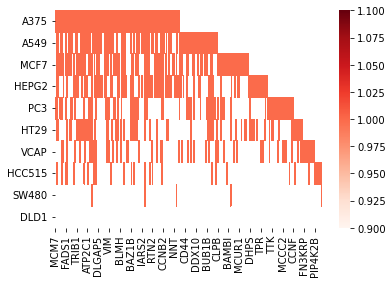

In [184]:
sns.heatmap(r_g_kd, cmap='Reds')
fig = plt.gcf()
fig.savefig(poseidon_home + 'panels/FigS3/shRNA_KD_R_gene.pdf', transparent=True)

In [53]:
# knockdown matrix
s_g_kd = df(index=cl_order)
for cl in cl_order:
    tmp_cl = s_sig_targeting[cl]
    
    if 'sh_z_' + cl in s_sig_tar_shz.columns:
        # shRNA
        tmp_cl_kd = tmp_cl[tmp_cl['cmap_name'].isin(s_sig_tar_shz[s_sig_tar_shz['sh_z_' + cl] < 0].index)]
        print(cl, s_sig_tar_shz['sh_z_' + cl].dropna(axis=0, how='any').shape[0], tmp_cl_kd['cmap_name'].unique().shape)

        for g in tmp_cl_kd['cmap_name'].unique():
            s_g_kd.at[cl, g] = 1

A375 23 (14,)
A549 22 (12,)
MCF7 18 (13,)
HEPG2 16 (11,)
PC3 19 (12,)
HT29 10 (7,)
VCAP 16 (11,)
HCC515 6 (4,)
SW480 3 (2,)


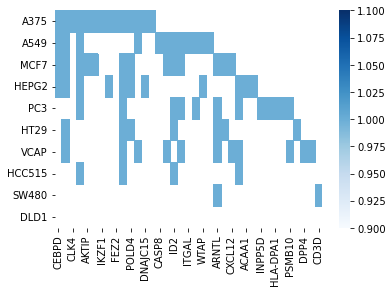

In [185]:
sns.heatmap(s_g_kd, cmap='Blues')
fig = plt.gcf()
fig.savefig(poseidon_home + 'panels/FigS3/shRNA_KD_S_gene.pdf', transparent=True)

In [55]:
r_g_kd.to_csv('/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/Tables/TableS3/shR_KDavailable.csv', sep=',')

In [56]:
s_g_kd.to_csv('/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/Tables/TableS3/shS_KDavailable.csv', sep=',')

In [172]:
tmp_list = []
for cl in s_sig_targeting.keys():
    if 'sh_z_' + cl in s_sig_tar_shz.columns:
        tmp_cl = s_sig_targeting[cl]
        tmp_cl_nr_down = tmp_cl[tmp_cl['REC_profile'] < 0]
        tmp_cl_nr_r = tmp_cl_nr_down[tmp_cl_nr_down['NREC_profile'] > 0]

        # shRNA
        tmp_cl_nr_r = tmp_cl_nr_r[tmp_cl_nr_r['cmap_name'].isin(s_sig_tar_shz[s_sig_tar_shz['sh_z_' + cl] < 0].index)]
        print(cl)
        print(stats.ttest_rel(tmp_cl_nr_r['NREC_profile'], tmp_cl_nr_r['REC_profile'])[1])
        print(s_sig_tar_shz[s_sig_tar_shz['sh_z_' + cl] < 0].shape)
        print(tmp_cl_nr_r['cmap_name'].unique().shape)
        p = stats.ttest_rel(tmp_cl_nr_down['NREC_profile'], tmp_cl_nr_down['REC_profile'])[1]
        tmp_list.extend(tmp_cl_nr_r['cmap_name'].unique())
        
        
        if tmp_cl_nr_down.shape[0] > 0:
            tmp_cl_nr_down = tmp_cl_nr_down[tmp_cl_nr_down['cmap_name'].isin(s_sig_tar_shz[s_sig_tar_shz['sh_z_' + cl] < 0].index)]
            tmp_cl_nr_down = tmp_cl_nr_down.rename(columns={'NREC_profile': 'R sig', 'REC_profile': 'S sig'})
            plt.figure(figsize=(3, 3))
            sns.violinplot(x='variable', y='value',
                           inner='quartile',
                           data=pd.melt(tmp_cl_nr_down.loc[tmp_cl_nr_down.index, ['R sig', 'S sig']]),
                           order=['S sig', 'R sig'],
                           palette={'R sig': 'crimson', 'S sig': 'royalblue'})

            plt.scatter(np.zeros(len(tmp_cl_nr_down.index)), tmp_cl_nr_down.loc[tmp_cl_nr_down.index, 'S sig'], s=5, c='k')
            plt.scatter(np.ones(len(tmp_cl_nr_down.index)), tmp_cl_nr_down.loc[tmp_cl_nr_down.index, 'R sig'], s=5, c='k')
            for i in tmp_cl_nr_down.index:
                plt.plot([0, 1], [tmp_cl_nr_down.loc[i, 'S sig'], tmp_cl_nr_down.loc[i, 'R sig']], c='k', linewidth=0.2)

            plt.axhline(y=0., c='k', ls='--')
            plt.ylabel('Enrichment score', fontsize=14)
            plt.xlabel('')
            plt.yticks(rotation=90, fontsize=14)
            plt.xticks(fontsize=14)
            plt.title(cl + ', p=' + str('{:.2e}'.format(p)), fontsize=14)
            plt.tight_layout()
            fig = plt.gcf()
            fig.savefig(poseidon_home + 'panels/FigS3/violin_S/' + cl + '.pdf', transparent=True)
            plt.close()
            tmp_list.extend(tmp_cl_nr_r['cmap_name'].unique())

MCF7
0.16613047053914057
(13, 9)
(2,)
SW480
0.0006827434981764981
(2, 9)
(1,)
HT29
nan
(7, 9)
(0,)
HEPG2
0.009868826538489063
(11, 9)
(3,)
A549
5.398248983095589e-05
(12, 9)
(2,)
HCC515
nan
(4, 9)
(1,)


/home/dyang-server/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dyang-server/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dyang-server/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dyang-server/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


PC3
0.015189160806619636
(12, 9)
(2,)
VCAP
9.679250433780551e-08
(11, 9)
(5,)
A375
1.36964291909336e-12
(14, 9)
(7,)


In [51]:
len(set(tmp_list))

16

In [73]:
# R targeting stat
r_targeting_merged = df(index=cl_order, columns=['r_targeted', 'r_KD',
                                                               'r_KD_down', 'r_KD_down_s_up'])
for cl in r_sig_targeting.keys():
    tmp_cl = r_sig_targeting[cl]
    r_targeting_merged.at[cl, 'r_targeted'] = tmp_cl['cmap_name'].unique().shape[0]
    
    tmp_cl_sh_z = tmp_cl[tmp_cl['cmap_name'].isin(r_sig_tar_shz[r_sig_tar_shz['sh_z_' + cl] < 0].index)]
    r_targeting_merged.at[cl, 'r_KD'] = tmp_cl_sh_z['cmap_name'].unique().shape[0]
    
    tmp_cl_nr_down = tmp_cl_sh_z[tmp_cl_sh_z['NREC_profile'] < 0]
    r_targeting_merged.at[cl, 'r_KD_down'] = tmp_cl_nr_down['cmap_name'].unique().shape[0]
    
    tmp_cl_nr_r = tmp_cl_nr_down[tmp_cl_nr_down['REC_profile'] > 0]
    r_targeting_merged.at[cl, 'r_KD_down_s_up'] = tmp_cl_nr_r['cmap_name'].unique().shape[0]

In [86]:
r_targeting_merged

r_targeted r_KD r_KD_down r_KD_down_s_up
A375          213  161       141            125
A549          186  125       110            100
MCF7          159  120       110             95
HEPG2         154  107        79             66
PC3           142   87        72             61
HT29          111   70        63             43
VCAP          104   62        46             44
HCC515         50   32        25             23
SW480           6    5         3              3
DLD1            2    0         0              0

In [74]:
# S targeting stat
s_targeting_merged = df(index=cl_order, columns=['s_targeted', 's_KD',
                                                 's_KD_down', 's_KD_down_r_up'])
for cl in s_sig_targeting.keys():
    if 'sh_z_' + cl in s_sig_tar_shz.columns: 
        tmp_cl = s_sig_targeting[cl]
        s_targeting_merged.at[cl, 's_targeted'] = tmp_cl['cmap_name'].unique().shape[0]

        tmp_cl_sh_z = tmp_cl[tmp_cl['cmap_name'].isin(s_sig_tar_shz[s_sig_tar_shz['sh_z_' + cl] < 0].index)]
        s_targeting_merged.at[cl, 's_KD'] = tmp_cl_sh_z['cmap_name'].unique().shape[0]

        tmp_cl_r_down = tmp_cl_sh_z[tmp_cl_sh_z['REC_profile'] < 0]
        s_targeting_merged.at[cl, 's_KD_down'] = tmp_cl_r_down['cmap_name'].unique().shape[0]

        tmp_cl_r_nr = tmp_cl_r_down[tmp_cl_r_down['NREC_profile'] > 0]
        s_targeting_merged.at[cl, 's_KD_down_r_up'] = tmp_cl_r_nr['cmap_name'].unique().shape[0]
s_targeting_merged = s_targeting_merged.fillna(0)

In [95]:
s_targeting_merged

s_targeted  s_KD  s_KD_down  s_KD_down_r_up
A375            23    14          9               7
A549            22    12          5               2
MCF7            18    13          5               2
HEPG2           16    11          4               3
PC3             19    12          2               2
HT29            10     7          5               0
VCAP            16    11          6               5
HCC515           6     4          1               1
SW480            3     2          1               1
DLD1             0     0          0               0

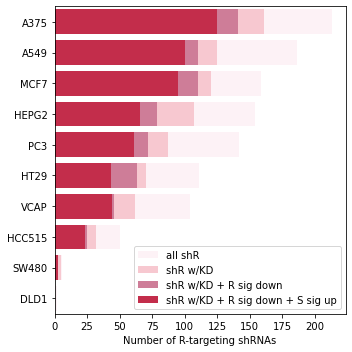

In [127]:
plt.figure(figsize=(5, 5))
sns.barplot(y=r_targeting_merged.index, x=r_targeting_merged['r_targeted'], color='lavenderblush', label='all shR')
sns.barplot(y=r_targeting_merged.index, x=r_targeting_merged['r_KD'], color='pink', label='shR w/KD')
sns.barplot(y=r_targeting_merged.index, x=r_targeting_merged['r_KD_down'], color='palevioletred', label='shR w/KD + R sig down')
sns.barplot(y=r_targeting_merged.index, x=r_targeting_merged['r_KD_down_s_up'], color='crimson', label='shR w/KD + R sig down + S sig up')
plt.legend()
plt.xlabel('Number of R-targeting shRNAs')
plt.tight_layout()
fig = plt.gcf()
fig.savefig(poseidon_home + 'panels/FigS3/shRNA_KD_Rsig_stat_merged.pdf', transparent=True)

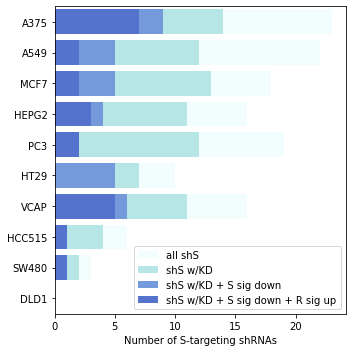

In [128]:
plt.figure(figsize=(5, 5))
sns.barplot(y=s_targeting_merged.index, x=s_targeting_merged['s_targeted'], color='azure', label='all shS')
sns.barplot(y=s_targeting_merged.index, x=s_targeting_merged['s_KD'], color='paleturquoise', label='shS w/KD')
sns.barplot(y=s_targeting_merged.index, x=s_targeting_merged['s_KD_down'], color='cornflowerblue', label='shS w/KD + S sig down')
sns.barplot(y=s_targeting_merged.index, x=s_targeting_merged['s_KD_down_r_up'], color='royalblue', label='shS w/KD + S sig down + R sig up')
plt.legend()
plt.xlabel('Number of S-targeting shRNAs')
plt.tight_layout()
fig = plt.gcf()
fig.savefig(poseidon_home + 'panels/FigS3/shRNA_KD_Ssig_stat_merged.pdf', transparent=True)

In [46]:
# knock down efficiency (z < 0, stat)
r_sig_tar_shz_count = r_sig_tar_shz[r_sig_tar_shz < 0].fillna(0)
r_sig_tar_shz_count = df(r_sig_tar_shz_count[r_sig_tar_shz_count == 0].fillna(1).sum(axis=1))
r_sig_tar_shz_count = r_sig_tar_shz_count.sort_values(by=0, ascending=False)

In [52]:
# knock down efficiency (z < 0, stat)
s_sig_tar_shz_count = s_sig_tar_shz[s_sig_tar_shz < 0].fillna(0)
s_sig_tar_shz_count = df(s_sig_tar_shz_count[s_sig_tar_shz_count == 0].fillna(1).sum(axis=1))
s_sig_tar_shz_count = s_sig_tar_shz_count.sort_values(by=0, ascending=False)

In [53]:
r_sig_tar_shz_success = r_sig_tar_shz_count[r_sig_tar_shz_count[0] >= 1]

In [54]:
r_sig_nrec_suppressed[r_sig_nrec_suppressed.index.isin(r_sig_tar_shz_success.index)]

shRsig_MCF7  shRsig_SW480  shRsig_HT29  shRsig_DLD1  shRsig_HEPG2  \
ABCF1     -0.397239           NaN          NaN          NaN           NaN   
ACBD3     -0.340315           NaN    -0.206626          NaN           NaN   
ACLY      -0.313942           NaN          NaN          NaN     -0.301091   
ACO2      -0.297754           NaN    -0.312764          NaN           NaN   
AKT3      -0.218056           NaN    -0.230584          NaN           NaN   
...             ...           ...          ...          ...           ...   
PAICS           NaN           NaN          NaN          NaN           NaN   
SLC5A6          NaN           NaN          NaN          NaN           NaN   
STXBP1          NaN           NaN          NaN          NaN           NaN   
TCEB3           NaN           NaN          NaN          NaN           NaN   
UTP14A          NaN           NaN          NaN          NaN           NaN   

        shRsig_A549  shRsig_HCC515  shRsig_PC3  shRsig_VCAP  shRsig_A375  
ABCF1     -0.291982            NaN         NaN          NaN    -0.347905  
ACBD3           NaN      -0.290869         NaN          NaN    -0.279924  
ACLY            NaN            NaN         NaN          NaN    -0.245198  
ACO2      -0.220629            NaN         NaN    -0.300224          NaN  
AKT3      -0.317802            NaN   -0.247128          NaN          NaN  
...             ...            ...         ...          ...          ...  
PAICS           NaN            NaN         NaN          NaN    -0.229508  
SLC5A6          NaN            NaN         NaN          NaN    -0.024438  
STXBP1          NaN            NaN         NaN          NaN    -0.261555  
TCEB3           NaN            NaN         NaN          NaN    -0.318343  
UTP14A          NaN            NaN         NaN          NaN    -0.228460  

[319 rows x 10 columns]

In [18]:
319/346

0.9219653179190751

In [55]:
s_sig_tar_shz_count[s_sig_tar_shz_count[0] >= 1].shape

(37, 1)

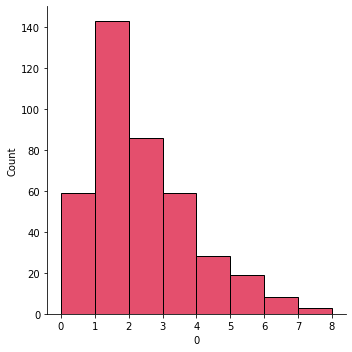

In [699]:
sns.displot(r_sig_tar_shz_count[0], bins=8, color='crimson')
fig = plt.gcf()
fig.savefig(poseidon_home + 'panels/FigS3/shRNA_KD_Rsig_dis.pdf', transparent=True)

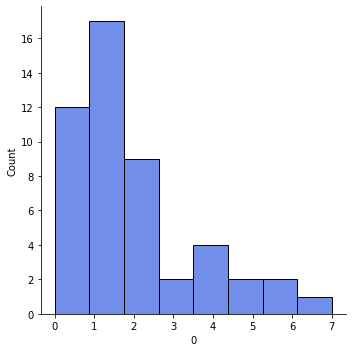

In [700]:
sns.displot(s_sig_tar_shz_count[0], bins=8, color='royalblue')
fig = plt.gcf()
fig.savefig(poseidon_home + 'panels/FigS3/shRNA_KD_Ssig_dis.pdf', transparent=True)

In [56]:
s_sig_tar_shz.shape

(49, 9)

<AxesSubplot:>

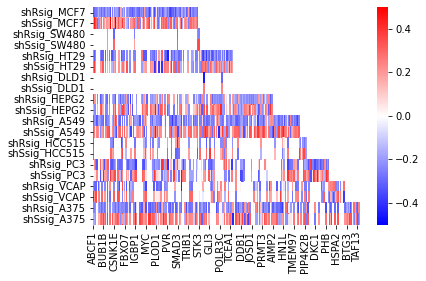

In [401]:
sns.heatmap(r_sig_tar_gene.T, cmap='bwr', vmin=-.5, vmax=.5)

<AxesSubplot:>

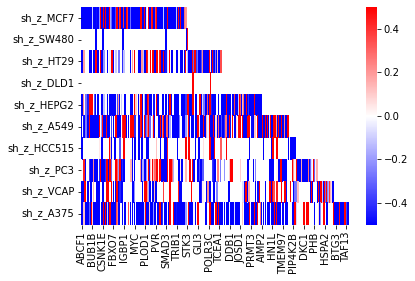

In [402]:
sns.heatmap(r_sig_tar_shz.T, cmap='bwr', vmin=-.5, vmax=.5)

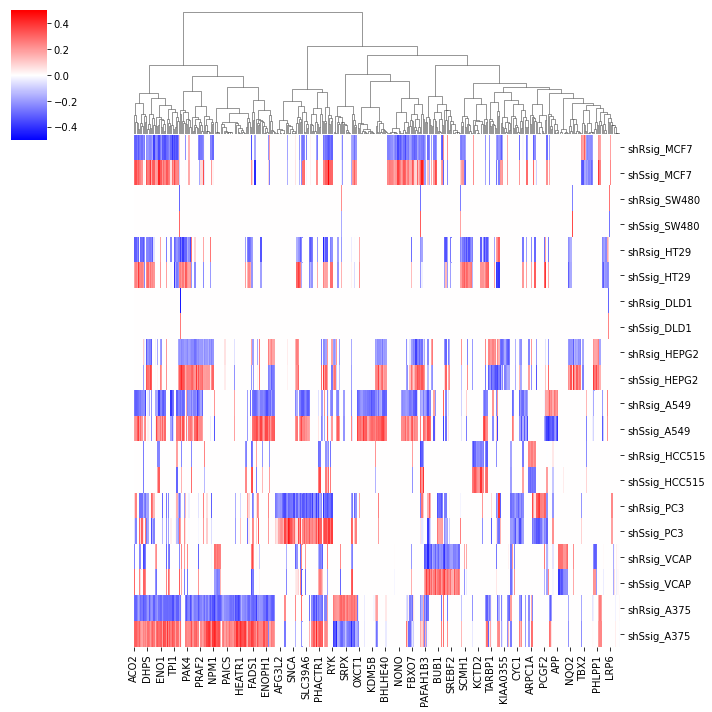

In [404]:
sns.clustermap(r_sig_tar_gene.T.fillna(0),
               method='ward', row_cluster=False,
               cmap='bwr', vmin=-.5, vmax=.5)

In [57]:
# sort the cell line by total number of available experiments
for cl in r_sig_targeting.keys():
    print(cl)
    print(r_sig_tar_gene['shRsig_' + cl].dropna(axis=0).shape)

MCF7
(159,)
SW480
(6,)
HT29
(111,)
DLD1
(2,)
HEPG2
(154,)
A549
(186,)
HCC515
(50,)
PC3
(142,)
VCAP
(104,)
A375
(213,)


In [51]:
cl_order = ['A375', 'A549', 'MCF7', 'HEPG2', 'PC3', 'HT29', 'VCAP', 'HCC515', 'SW480', 'DLD1']

In [59]:
cl_order_sig = []
for cl in cl_order:
    cl_order_sig.append('shRsig_' + cl)
    cl_order_sig.append('shSsig_' + cl)

In [60]:
cl_order_sig_alt = []
for cl in cl_order:
    cl_order_sig_alt.append('shRsig_' + cl)
for cl in cl_order:
    cl_order_sig_alt.append('shSsig_' + cl)

In [61]:
r_sig_tar_gene_order = []
for c in cl_order:
    tmp_c_r = r_sig_tar_gene['shRsig_' + c].dropna(axis=0, how='any')
    tmp_c_s = r_sig_tar_gene['shSsig_' + c].dropna(axis=0, how='any')
    tmp_c_shift = tmp_c_s - tmp_c_r
    tmp_c_shift = df(tmp_c_shift).sort_values(by=0, ascending=False)
    
    tmp_append = tmp_c_shift[~tmp_c_shift.index.isin(r_sig_tar_gene_order)]
    r_sig_tar_gene_order.extend(tmp_append.index)

<AxesSubplot:>

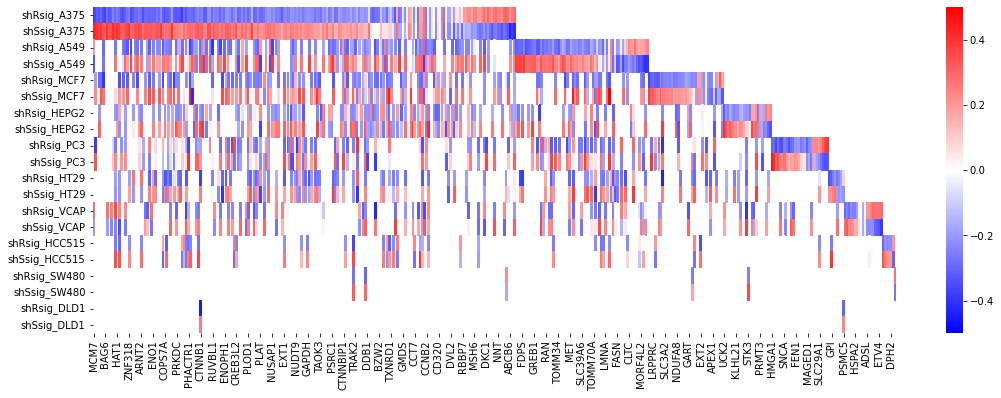

In [62]:
plt.figure(figsize=(18, 6))
sns.heatmap(r_sig_tar_gene[cl_order_sig].T[r_sig_tar_gene_order],
            cmap='bwr', vmin=-.5, vmax=.5)

In [63]:
r_sig_tar_shz[['sh_z_' + cl for cl in cl_order]].T[r_sig_tar_gene_order]

MCM7      ILF2   TCEB3      NPM1     NOLC1     ABCF1    BAG6  \
sh_z_A375   -0.931999 -0.738915 -0.3681 -2.568150 -4.708304 -2.477883  0.6812   
sh_z_A549    1.145850       NaN     NaN       NaN       NaN -2.021850     NaN   
sh_z_MCF7         NaN  0.539202     NaN -0.777547 -4.053295 -1.567650     NaN   
sh_z_HEPG2        NaN       NaN     NaN  0.043800       NaN       NaN     NaN   
sh_z_PC3          NaN -1.565100     NaN       NaN       NaN       NaN     NaN   
sh_z_HT29         NaN       NaN     NaN       NaN       NaN       NaN     NaN   
sh_z_VCAP    0.336992       NaN     NaN       NaN       NaN       NaN     NaN   
sh_z_HCC515       NaN       NaN     NaN       NaN       NaN       NaN     NaN   
sh_z_SW480        NaN       NaN     NaN       NaN       NaN       NaN     NaN   
sh_z_DLD1         NaN       NaN     NaN       NaN       NaN       NaN     NaN   

                BRCA1    HEATR1      MITF  ...     SPRY4      ETV4     TOP2A  \
sh_z_A375   -0.213000 -4.439226 -2.160660  ...       NaN       NaN       NaN   
sh_z_A549         NaN       NaN       NaN  ...       NaN       NaN       NaN   
sh_z_MCF7         NaN       NaN       NaN  ...       NaN       NaN       NaN   
sh_z_HEPG2        NaN       NaN       NaN  ...       NaN       NaN       NaN   
sh_z_PC3          NaN       NaN       NaN  ...       NaN       NaN       NaN   
sh_z_HT29         NaN       NaN       NaN  ...       NaN       NaN       NaN   
sh_z_VCAP   -1.720323       NaN  0.517981  ...  0.063535 -0.106704 -2.151486   
sh_z_HCC515       NaN       NaN       NaN  ...       NaN       NaN       NaN   
sh_z_SW480        NaN       NaN       NaN  ...       NaN       NaN       NaN   
sh_z_DLD1         NaN       NaN       NaN  ...       NaN       NaN       NaN   

              PIP4K2B   SLC25A1     KCTD2     LSM2      DPH2    ARPC1A  \
sh_z_A375         NaN       NaN       NaN      NaN       NaN       NaN   
sh_z_A549         NaN       NaN       NaN      NaN       NaN       NaN   
sh_z_MCF7         NaN       NaN       NaN      NaN       NaN       NaN   
sh_z_HEPG2        NaN       NaN       NaN      NaN       NaN       NaN   
sh_z_PC3          NaN       NaN       NaN      NaN       NaN       NaN   
sh_z_HT29         NaN       NaN       NaN      NaN       NaN       NaN   
sh_z_VCAP         NaN       NaN       NaN      NaN       NaN       NaN   
sh_z_HCC515 -4.292742 -0.629218 -0.501319 -0.54201 -3.004338 -0.538688   
sh_z_SW480        NaN       NaN       NaN      NaN       NaN       NaN   
sh_z_DLD1         NaN       NaN       NaN      NaN       NaN       NaN   

                LRP6  
sh_z_A375        NaN  
sh_z_A549        NaN  
sh_z_MCF7        NaN  
sh_z_HEPG2       NaN  
sh_z_PC3         NaN  
sh_z_HT29        NaN  
sh_z_VCAP        NaN  
sh_z_HCC515      NaN  
sh_z_SW480  -1.72283  
sh_z_DLD1        NaN  

[10 rows x 405 columns]

In [64]:
# genes tested in at least five cell lines
r_sig_tar_tested = r_sig_tar_shz[r_sig_tar_shz != np.nan].fillna(0)
r_sig_tar_tested = r_sig_tar_tested[r_sig_tar_tested == 0].fillna(1)
r_sig_tar_tested = df(r_sig_tar_tested.sum(axis=1)).rename(columns={0: 'tested_count'})
r_sig_tar_tested = r_sig_tar_tested.sort_values(by='tested_count', ascending=False)
print(r_sig_tar_tested)

        tested_count
CSNK1E           8.0
FADS1            8.0
MYC              8.0
MOK              8.0
SMAD3            8.0
...              ...
CLPTM1           1.0
GREB1            1.0
GGH              1.0
GIPC1            1.0
ZNF74            1.0

[405 rows x 1 columns]


In [65]:
r_sig_tar_tested[r_sig_tar_tested['tested_count'] >= 5]

tested_count
CSNK1E           8.0
FADS1            8.0
MYC              8.0
MOK              8.0
SMAD3            8.0
...              ...
ENO1             5.0
PAPD7            5.0
CCDC86           5.0
HDAC2            5.0
VAT1             5.0

[66 rows x 1 columns]

In [66]:
r_sig_tar_tested.loc['PAK4', :]

tested_count    4.0
Name: PAK4, dtype: float64

<AxesSubplot:>

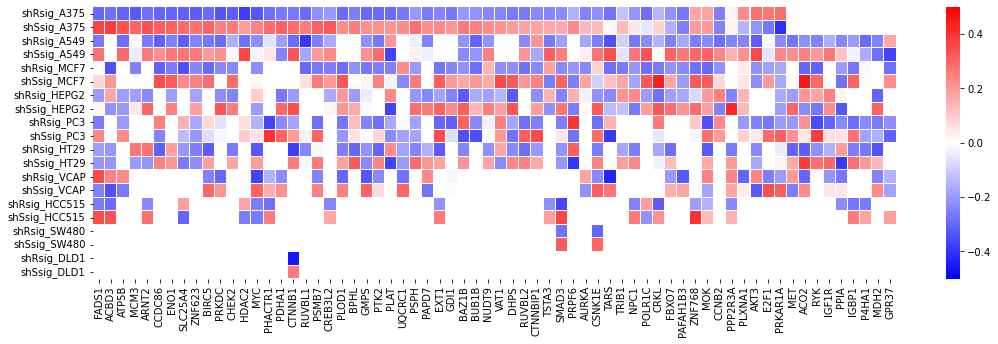

In [67]:
tmp_matrix = r_sig_tar_gene.loc[r_sig_tar_gene_order, cl_order_sig]
plt.figure(figsize=(18, 5))
sns.heatmap(tmp_matrix[tmp_matrix.index.isin(r_sig_tar_tested[r_sig_tar_tested['tested_count'] >= 5].index)].T,
            cmap='bwr', vmin=-.5, vmax=.5, linecolor='w', linewidths=.01)

In [48]:
# concat on gene level (average for multi-hits)
tmp_list = []
tmp_sh_list = []
for c in s_sig_targeting.keys():
    try:
        tmp_c = s_sig_targeting[c]
        tmp_c = tmp_c.groupby('cmap_name').mean()
        tmp_list.append(tmp_c[['NREC_profile', 'REC_profile']].rename(columns={'NREC_profile': 'shRsig_' + c,
                                                                       'REC_profile': 'shSsig_' + c}))
        tmp_sh_list.append(df(tmp_c['sh_z_score']).rename(columns={'sh_z_score': 'sh_z_' + c}))
    except KeyError:
        pass

s_sig_tar_gene = pd.concat(tmp_list, axis=1).dropna(axis=0, how='all')
print(s_sig_tar_gene.shape)
s_sig_tar_shz = pd.concat(tmp_sh_list, axis=1).dropna(axis=0, how='all')
print(s_sig_tar_shz.shape)

(49, 20)
(49, 9)


In [70]:
s_sig_tar_gene_order = []
for c in cl_order:
    tmp_c_r = s_sig_tar_gene['shRsig_' + c].dropna(axis=0, how='any')
    tmp_c_s = s_sig_tar_gene['shSsig_' + c].dropna(axis=0, how='any')
    tmp_c_shift = tmp_c_s - tmp_c_r
    tmp_c_shift = df(tmp_c_shift).sort_values(by=0, ascending=False)
    
    tmp_append = tmp_c_shift[~tmp_c_shift.index.isin(s_sig_tar_gene_order)]
    s_sig_tar_gene_order.extend(tmp_append.index)

In [70]:
s_sig_tar_shz

sh_z_MCF7  sh_z_SW480  sh_z_HT29  sh_z_HEPG2  sh_z_A549  \
AKTIP     -0.561636         NaN        NaN         NaN        NaN   
ARNTL     -1.209744   -0.728489  -0.884761    0.352300   0.067735   
BID       -1.479584         NaN        NaN   -1.255226  -2.555050   
C1S       -0.245084         NaN        NaN         NaN  -0.433027   
CEBPD     -0.596135         NaN        NaN   -1.685834  -0.034177   
CFLAR     -0.775462         NaN  -1.495219   -0.493055  -0.980218   
CXCL12    -0.257044         NaN        NaN         NaN        NaN   
DHRS3      0.947498         NaN        NaN         NaN        NaN   
FDX1      -1.327721         NaN        NaN         NaN   0.119513   
HLA-DMA   -0.833262         NaN        NaN         NaN  -0.627071   
HLA-DPA1   0.251461         NaN   1.300500    0.804150        NaN   
ID2       -1.170105         NaN  -0.276448         NaN  -2.577081   
IL2RB     -0.257916         NaN  -0.354500         NaN   0.902750   
INPP5D     0.859350         NaN        NaN         NaN   0.683395   
LCK        0.743773         NaN   0.863551         NaN   0.154525   
NMI        0.077466         NaN        NaN         NaN   0.121700   
POLD4     -4.265090         NaN  -3.715500   -3.078909        NaN   
RPS6KA1   -3.775850         NaN  -8.903545   -0.820017        NaN   
CD3D            NaN   -0.630650        NaN         NaN        NaN   
MYD88           NaN    1.184448        NaN         NaN  -1.897219   
EVL             NaN         NaN   0.192412         NaN        NaN   
TRADD           NaN         NaN  -0.864302         NaN        NaN   
ACAA1           NaN         NaN        NaN   -2.601876        NaN   
CORO1A          NaN         NaN        NaN    1.512750        NaN   
DNAJC15         NaN         NaN        NaN   -2.879382        NaN   
FLI1            NaN         NaN        NaN    1.100439        NaN   
GCA             NaN         NaN        NaN   -0.097100        NaN   
LSP1            NaN         NaN        NaN   -0.380728        NaN   
LYRM1           NaN         NaN        NaN   -3.661741        NaN   
PTPN22          NaN         NaN        NaN    1.115397   2.217942   
WTAP            NaN         NaN        NaN   -0.573416  -0.661554   
APBB1IP         NaN         NaN        NaN         NaN   0.366953   
BIRC3           NaN         NaN        NaN         NaN  -0.384975   
CASP8           NaN         NaN        NaN         NaN  -0.141514   
DPYD            NaN         NaN        NaN         NaN   0.809389   
FBP1            NaN         NaN        NaN         NaN   1.591250   
GLRX            NaN         NaN        NaN         NaN  -4.281957   
ITGAL           NaN         NaN        NaN         NaN  -0.563863   
CIITA           NaN         NaN        NaN         NaN        NaN   
FTL             NaN         NaN        NaN         NaN        NaN   
LGALS2          NaN         NaN        NaN         NaN        NaN   
PSMB10          NaN         NaN        NaN         NaN        NaN   
DPP4            NaN         NaN        NaN         NaN        NaN   
HHEX            NaN         NaN        NaN         NaN        NaN   
JAK3            NaN         NaN        NaN         NaN        NaN   
BLNK            NaN         NaN        NaN         NaN        NaN   
CLK4            NaN         NaN        NaN         NaN        NaN   
FEZ2            NaN         NaN        NaN         NaN        NaN   
IKZF1           NaN         NaN        NaN         NaN        NaN   

          sh_z_HCC515  sh_z_PC3  sh_z_VCAP  sh_z_A375  
AKTIP        0.927569       NaN   0.999940  -0.182141  
ARNTL             NaN -0.188259  -0.266136        NaN  
BID         -1.382441 -1.140100        NaN  -0.694284  
C1S               NaN -0.123477  -0.528207        NaN  
CEBPD             NaN       NaN        NaN  -1.985641  
CFLAR        0.793060  1.199162  -1.641011  -0.906546  
CXCL12            NaN  0.385058  -0.407412        NaN  
DHRS3             NaN       NaN        NaN        NaN  
FDX1              NaN       NaN        NaN  -0.519951  

In [71]:
# genes tested in at least five cell lines
s_sig_tar_tested = s_sig_tar_shz[s_sig_tar_shz != np.nan].fillna(0)
s_sig_tar_tested = s_sig_tar_tested[s_sig_tar_tested == 0].fillna(1)
s_sig_tar_tested = df(s_sig_tar_tested.sum(axis=1)).rename(columns={0: 'tested_count'})
s_sig_tar_tested = s_sig_tar_tested.sort_values(by='tested_count', ascending=False)
print(s_sig_tar_tested)

          tested_count
CFLAR              8.0
ARNTL              7.0
RPS6KA1            7.0
BID                6.0
LCK                6.0
ID2                6.0
AKTIP              4.0
HLA-DPA1           4.0
POLD4              4.0
IL2RB              4.0
INPP5D             4.0
CEBPD              4.0
C1S                4.0
GCA                4.0
HLA-DMA            3.0
FDX1               3.0
CXCL12             3.0
GLRX               3.0
MYD88              3.0
FBP1               3.0
CORO1A             3.0
LSP1               2.0
PSMB10             2.0
CIITA              2.0
WTAP               2.0
PTPN22             2.0
LYRM1              2.0
DNAJC15            2.0
FLI1               2.0
CD3D               2.0
ACAA1              2.0
NMI                2.0
TRADD              2.0
BIRC3              1.0
DHRS3              1.0
FEZ2               1.0
CLK4               1.0
BLNK               1.0
JAK3               1.0
HHEX               1.0
DPP4               1.0
LGALS2             1.0
CASP8      

<AxesSubplot:>

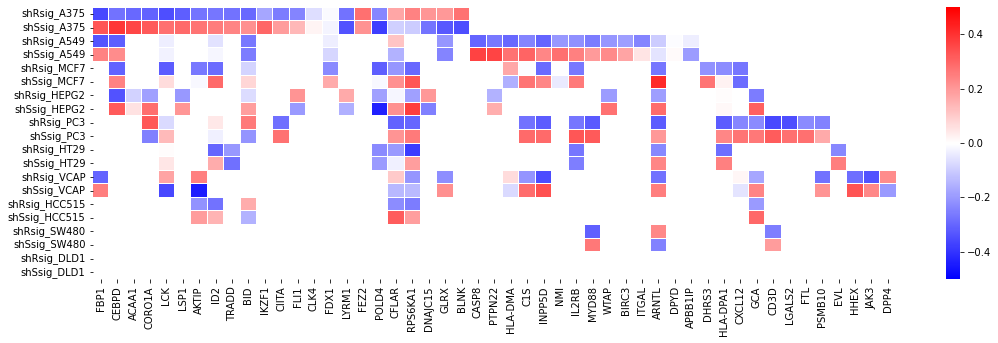

In [72]:
tmp_matrix = s_sig_tar_gene.loc[s_sig_tar_gene_order, cl_order_sig]
plt.figure(figsize=(18, 5))
sns.heatmap(tmp_matrix.T,
            cmap='bwr', vmin=-.5, vmax=.5, linecolor='w', linewidths=.01)

<AxesSubplot:>

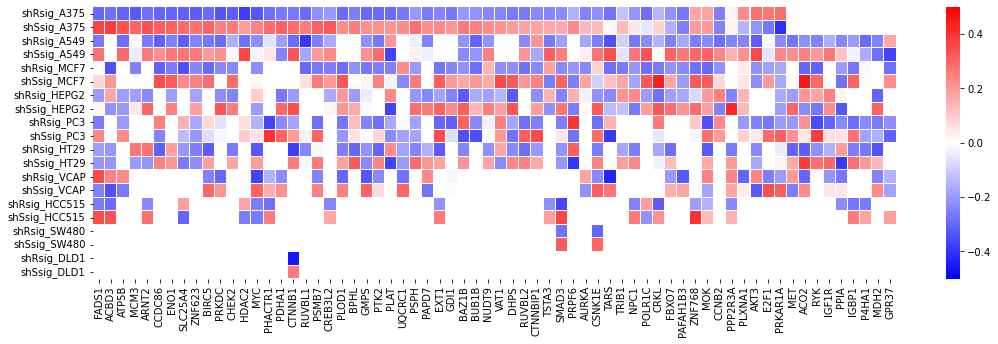

In [73]:
tmp_matrix = r_sig_tar_gene.loc[r_sig_tar_gene_order, cl_order_sig]
plt.figure(figsize=(18, 5))
sns.heatmap(tmp_matrix[tmp_matrix.index.isin(r_sig_tar_tested[r_sig_tar_tested['tested_count'] >= 5].index)].T,
            cmap='bwr', vmin=-.5, vmax=.5, linecolor='w', linewidths=.01)

In [74]:
# generate the visualization matrix
tmp_matrix = r_sig_tar_gene.loc[r_sig_tar_gene_order, cl_order_sig_alt]
r_visual = tmp_matrix[tmp_matrix.index.isin(r_sig_tar_tested[r_sig_tar_tested['tested_count'] >= 5].index)].T

tmp_matrix = s_sig_tar_gene.loc[s_sig_tar_gene_order, cl_order_sig_alt]
s_visual = tmp_matrix[tmp_matrix.index.isin(s_sig_tar_tested[s_sig_tar_tested['tested_count'] >= 1].index)].T

In [75]:
# mask insufficient KD efficiency: sh_z > 0
def to_mask(visual_matrix, sh_z_matrix):
    mask_matrix = df(index=visual_matrix.index, columns=visual_matrix.columns)
    for c in visual_matrix.index:
        tmp_cl = c.split('_')[-1]
        tmp_cl_sh = 'sh_z_' + tmp_cl
        if tmp_cl_sh in sh_z_matrix.columns:
            for g in visual_matrix.columns:
                if sh_z_matrix.loc[g, tmp_cl_sh] <= 0:
                    mask_matrix.at[c, g] = False
                else:
                    mask_matrix.at[c, g] = True
    return mask_matrix

In [76]:
r_mask = to_mask(visual_matrix=r_visual, sh_z_matrix=r_sig_tar_shz)
s_mask = to_mask(visual_matrix=s_visual, sh_z_matrix=s_sig_tar_shz)

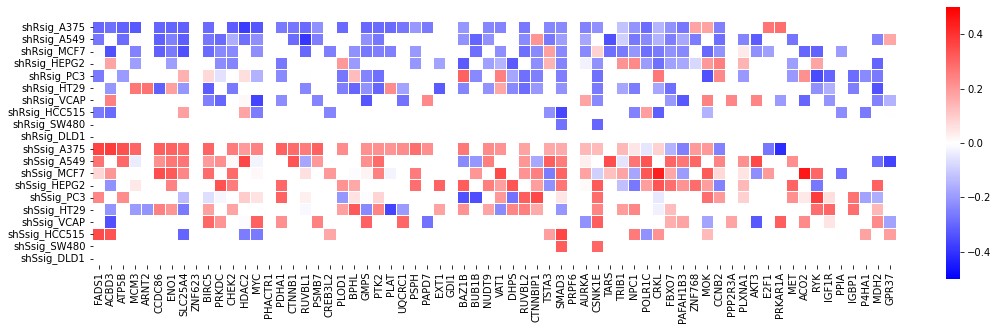

In [553]:
plt.figure(figsize=(18, 5))
sns.heatmap(r_visual, mask=r_mask, square=True,
            cmap='bwr', vmin=-.5, vmax=.5, linecolor='w', linewidths=.01)
fig = plt.gcf()
fig.savefig(panel_home + '/heatmap/Rsig_targeting_5cell_separate.pdf', transparent=True)

In [79]:
def to_bubble(visual_matrix, sh_z_matrix):
    mask_matrix = df(index=visual_matrix.index, columns=visual_matrix.columns)
    for c in visual_matrix.index:
        tmp_cl = c.split('_')[-1]
        tmp_cl_sh = 'sh_z_' + tmp_cl
        if tmp_cl_sh in sh_z_matrix.columns:
            for g in visual_matrix.columns:
                mask_matrix.at[c, g] = sh_z_matrix.loc[g, tmp_cl_sh]
    return mask_matrix

In [80]:
r_bubble = to_bubble(visual_matrix=r_visual, sh_z_matrix=r_sig_tar_shz)

In [81]:
r_bubble

FADS1    ACBD3       ATP5B     MCM3     ARNT2   CCDC86  \
shRsig_A375     -0.95495  -5.7135    -1.02525 -3.81551    1.0568 -4.12167   
shRsig_A549    -0.376731      NaN    -0.41145 -3.84592   1.46089 -2.05508   
shRsig_MCF7     -1.30554  -4.0583         NaN -2.83932       NaN -2.19748   
shRsig_HEPG2   0.0126355 -1.24637     1.12653 -1.33001  0.672022      NaN   
shRsig_PC3      -0.29352      NaN   -0.211122      NaN       NaN   0.2251   
shRsig_HT29     0.406667 -4.84916         NaN -5.58545 -0.539059 -4.40857   
shRsig_VCAP     0.950523 -1.64663  0.00222743      NaN       NaN      NaN   
shRsig_HCC515  -0.785224 -3.54756         NaN      NaN  0.666488      NaN   
shRsig_SW480         NaN      NaN         NaN      NaN       NaN      NaN   
shRsig_DLD1          NaN      NaN         NaN      NaN       NaN      NaN   
shSsig_A375     -0.95495  -5.7135    -1.02525 -3.81551    1.0568 -4.12167   
shSsig_A549    -0.376731      NaN    -0.41145 -3.84592   1.46089 -2.05508   
shSsig_MCF7     -1.30554  -4.0583         NaN -2.83932       NaN -2.19748   
shSsig_HEPG2   0.0126355 -1.24637     1.12653 -1.33001  0.672022      NaN   
shSsig_PC3      -0.29352      NaN   -0.211122      NaN       NaN   0.2251   
shSsig_HT29     0.406667 -4.84916         NaN -5.58545 -0.539059 -4.40857   
shSsig_VCAP     0.950523 -1.64663  0.00222743      NaN       NaN      NaN   
shSsig_HCC515  -0.785224 -3.54756         NaN      NaN  0.666488      NaN   
shSsig_SW480         NaN      NaN         NaN      NaN       NaN      NaN   
shSsig_DLD1          NaN      NaN         NaN      NaN       NaN      NaN   

                  ENO1  SLC25A4    ZNF623    BIRC5  ...    PRKAR1A        MET  \
shRsig_A375   -1.63715 -7.21128  0.971776 -2.85327  ...     -0.699        NaN   
shRsig_A549    -1.2984  -2.3813    1.4092 -3.87832  ...     1.3868  -0.988575   
shRsig_MCF7   -0.81878 -6.81902  0.668948 -4.25997  ...   0.497462        NaN   
shRsig_HEPG2  -0.83045      NaN    1.8902      NaN  ...    0.41075    -0.0728   
shRsig_PC3         NaN -2.92548   1.88335 -3.36413  ...   0.932984  -0.318769   
shRsig_HT29   -1.02172 -6.73043  0.478414 -5.82926  ...  0.0183786   0.227116   
shRsig_VCAP        NaN      NaN       NaN  -4.2319  ...  -0.158388  0.0287989   
shRsig_HCC515      NaN -7.73401       NaN      NaN  ...        NaN        NaN   
shRsig_SW480       NaN      NaN       NaN      NaN  ...        NaN        NaN   
shRsig_DLD1        NaN      NaN       NaN      NaN  ...        NaN        NaN   
shSsig_A375   -1.63715 -7.21128  0.971776 -2.85327  ...     -0.699        NaN   
shSsig_A549    -1.2984  -2.3813    1.4092 -3.87832  ...     1.3868  -0.988575   
shSsig_MCF7   -0.81878 -6.81902  0.668948 -4.25997  ...   0.497462        NaN   
shSsig_HEPG2  -0.83045      NaN    1.8902      NaN  ...    0.41075    -0.0728   
shSsig_PC3         NaN -2.92548   1.88335 -3.36413  ...   0.932984  -0.318769   
shSsig_HT29   -1.02172 -6.73043  0.478414 -5.82926  ...  0.0183786   0.227116   
shSsig_VCAP        NaN      NaN       NaN  -4.2319  ...  -0.158388  0.0287989   
shSsig_HCC515      NaN -7.73401       NaN      NaN  ...        NaN        NaN   
shSsig_SW480       NaN      NaN       NaN      NaN  ...        NaN        NaN   
shSsig_DLD1        NaN      NaN       NaN      NaN  ...        NaN        NaN   

                   ACO2       RYK      IGF1R       PPIA     IGBP1     P4HA1  \
shRsig_A375         NaN       NaN        NaN        NaN       NaN       NaN   
shRsig_A549     1.87895  0.284694  0.0409788   0.275717   1.12783   1.03624   
shRsig_MCF7   -0.463414 -0.601435        NaN          0  0.396117  0.482792   
shRsig_HEPG2   0.223134  -1.97929   0.715491   0.547191       NaN       NaN   
shRsig_PC3     -0.23759  -2.69308  -0.346808  0.0536919 -0.639954  -1.29592   
shRsig_HT29    0.529647   -1.1317   -1.37802   0.452946 -0.123915  0.206732   
shRsig_VCAP   -0.489503       NaN   -3.42521   0.204701       NaN       NaN   
shRsig_HCC515       NaN       NaN        NaN   -0.86625   1.18454 -

In [82]:
def boPlot_gsea(corr, fdr, mask, path):
    '''
    Visualize by bo plot for GSEA. Dot size indicate the significance, color indicate the correlation
    '''
    location = {}
    j = 1
    for ctype in fdr.columns:
        location[ctype] = df(index=fdr.index, columns=['x', 'y'])
        location[ctype]['fdr'] = fdr[ctype]
        location[ctype]['corr'] = corr[ctype]

        i = 1
        for t in location[ctype].index:
            location[ctype].at[t, 'y'] = i - .5
            location[ctype].at[t, 'x'] = j - .5
            i += 1
        j += 1

    # collapse all subframe to one
    mergeIndex = []
    for c in location.keys():
        mergeIndex.extend([c + '~' + x for x in location[c].index])
    mergeLoc = df(index=mergeIndex, columns=['x', 'y', 'fdr', 'corr'])
    for c in location.keys():
        for t in fdr.index:
            mergeLoc.at[c + '~' + t, 'x'] = location[c].loc[t, 'x']
            mergeLoc.at[c + '~' + t, 'y'] = location[c].loc[t, 'y']
            mergeLoc.at[c + '~' + t, 'fdr'] = location[c].loc[t, 'fdr']
            mergeLoc.at[c + '~' + t, 'corr'] = location[c].loc[t, 'corr']
    
    fig = plt.figure(figsize=(18, 5))
    ax = fig.add_subplot(111, aspect='equal')
    sns.heatmap(corr, mask=mask, 
                vmin=-.5, vmax=.5, cmap='bwr',
                square=True, linewidths=0.1,
                linecolor='w', xticklabels=True, yticklabels=True)

    # sns.scatterplot(x=mergeLoc['x'], y=mergeLoc['y'], size=mergeLoc['value'], color='k', linewidths=False)
    # negative KD
    tmp_mergeLoc = mergeLoc[mergeLoc['fdr'] <= 0]
    ax.scatter(
        x=tmp_mergeLoc['x'], y=tmp_mergeLoc['y'],
        s=-tmp_mergeLoc['fdr'].astype(float)*20,
        color='k', marker='v'
        )
    tmp_mergeLoc = mergeLoc[mergeLoc['fdr'] > 0]
    ax.scatter(
        x=tmp_mergeLoc['x'], y=tmp_mergeLoc['y'],
        s=tmp_mergeLoc['fdr'].astype(float)*20,
        color='k', marker='^'
        )
    plt.xticks(rotation=90, fontsize=14)
    plt.yticks(rotation=0, fontsize=14)
    
    plt.subplots_adjust(left=0.1)
    plt.tight_layout()
    fig = plt.gcf()
    fig.savefig(path, transparent=True)
    plt.show()

    return


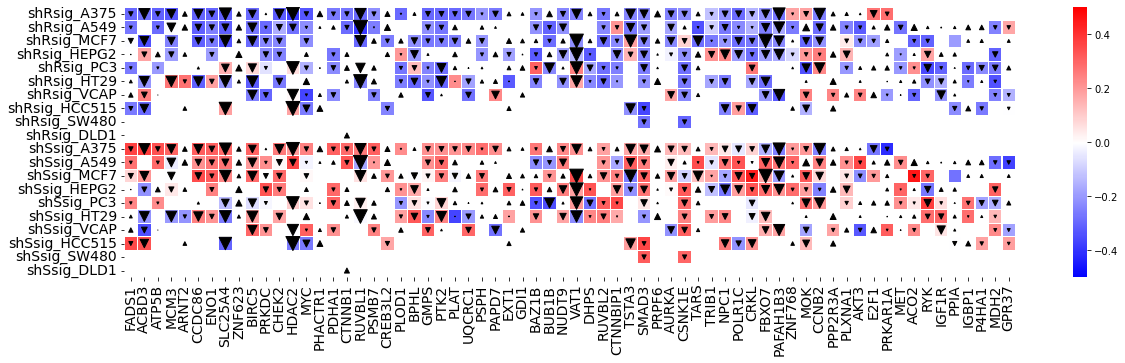

In [659]:
boPlot_gsea(corr=r_visual, fdr=r_bubble, mask=r_mask, path=panel_home + '/heatmap/bubbled_Rsig_targeting_5cell_separate.pdf')

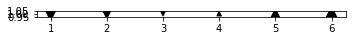

In [669]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, aspect='equal')
ax.scatter(x=[1, 2, 3], y=[1, 1, 1],
           s=[200, 100, 20],
           color='k', marker='v')
ax.scatter(x=[4, 5, 6], y=[1, 1, 1],
           s=[20, 100, 200],
           color='k', marker='^')
plt.tight_layout()
fig = plt.gcf()
fig.savefig(panel_home + '/heatmap/size_bubbled_Rsig_targeting_5cell_separate.pdf', transparent=True)

In [ ]:
plt.figure(figsize=(18, 5))
sns.heatmap(r_visual, mask=r_mask, square=True,
            cmap='bwr', vmin=-.5, vmax=.5, linecolor='w', linewidths=.01)
fig = plt.gcf()
fig.savefig(panel_home + '/heatmap/Rsig_targeting_5cell_merge.pdf', transparent=True)

<AxesSubplot:>

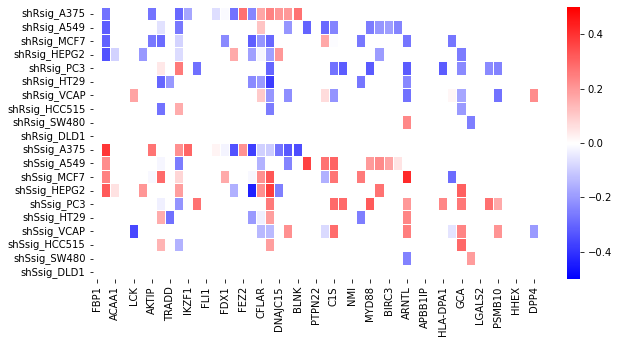

In [536]:
plt.figure(figsize=(10, 5))
sns.heatmap(s_visual, mask=s_mask,
            cmap='bwr', vmin=-.5, vmax=.5, linecolor='w', linewidths=.01)

# shRNA cases

In [75]:
# SMAD3, MYC
case_shRNA = sig_info[sig_info['cmap_name'].isin(['HDAC2','PAK4'])]
case_shRNA = case_shRNA[case_shRNA['cell_mfc_name'].isin(cl_order)]
case_shRNA = case_shRNA[case_shRNA['pert_type'] == 'trt_sh']
print(case_shRNA.shape)

(160, 36)


In [76]:
case_shRNA[case_shRNA['cmap_name'] == 'HDAC2'].shape

(100, 36)

In [77]:
case_shRNA[case_shRNA['cmap_name'] == 'PAK4'].shape

(60, 36)

In [576]:
for c in shRNA_cancer:
    cancer_path = c
    tmp_result = shRNA_result[cancer_path]
    for s in tmp_result.index:
        if tmp_result.loc[s, 'cmap_name'] in ['MYC', 'SMAD3']:
            tmp_dir = tmp_result.loc[s, 'cmap_name']
            p_rename = '__'.join(s.split(':'))
            rnk = pd.read_csv(gsea_home + cancer_path + '/trt_sh/' + p_rename + '.rnk', header=None, sep="\t")
            pre_res = gp.prerank(rnk=rnk, gene_sets=gsea_home + '/gene_sets/NREC_REC_91061.gmt',
                                 processes=1,
                                 permutation_num=10, # reduce number to speed up testing
                                 outdir=gsea_home + 'gsea_case/' + tmp_dir + '/' + s, format='pdf', seed=0, min_size=0, max_size=10000)

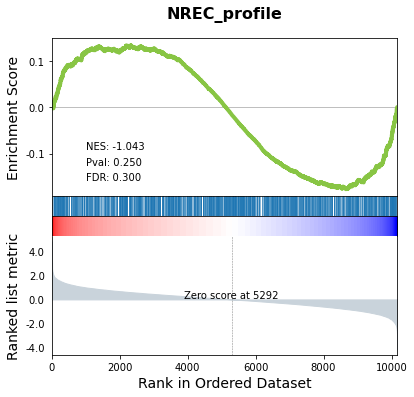

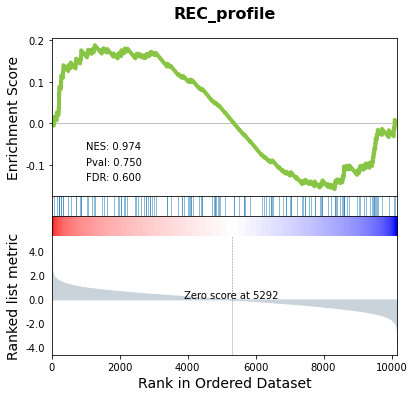

In [587]:
gp.gseaplot(rank_metric=pre_res.ranking, term='NREC_profile', **pre_res.results['NREC_profile'])
gp.gseaplot(rank_metric=pre_res.ranking, term='REC_profile', **pre_res.results['REC_profile'])

In [613]:
pre_res.results['NREC_profile']['RES']

array([-1.11308994e-04, -2.22617988e-04, -3.33926981e-04, ...,
        2.22617988e-04,  1.11308994e-04,  3.82853742e-14])

In [621]:
len(pre_res.results['NREC_profile']['RES'])

10174

In [622]:
len(pre_res.results['NREC_profile']['hit_indices'])

1190

In [624]:
tmp_res = []
for i in pre_res.results['NREC_profile']['hit_indices']:
    tmp_res.append(pre_res.results['NREC_profile']['RES'][i])

<AxesSubplot:>

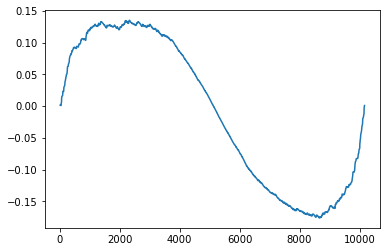

In [625]:
sns.lineplot(x=pre_res.results['NREC_profile']['hit_indices'], y=tmp_res)

In [635]:
res_dict = {'MYC': {}, 'SMAD3': {}}
for c in shRNA_cancer:
    cancer_path = c
    tmp_result = shRNA_result[cancer_path]
    for s in tmp_result.index:
        if tmp_result.loc[s, 'cmap_name'] in ['MYC', 'SMAD3']:
            tmp_dir = tmp_result.loc[s, 'cmap_name']
            p_rename = '__'.join(s.split(':'))
            rnk = pd.read_csv(gsea_home + cancer_path + '/trt_sh/' + p_rename + '.rnk', header=None, sep="\t")
            pre_res = gp.prerank(rnk=rnk, gene_sets=gsea_home + '/gene_sets/NREC_REC_91061.gmt',
                                 processes=1,
                                 permutation_num=1, # reduce number to speed up testing
                                 outdir=None, format='pdf', seed=0, min_size=0, max_size=10000)
            res_dict[tmp_dir][s] = {}
            res_dict[tmp_dir][s]['R_signature'] = {} 
            res_dict[tmp_dir][s]['S_signature'] = {}
            
            # save R sig
            res_dict[tmp_dir][s]['R_signature']['hit_indices'] = pre_res.results['NREC_profile']['hit_indices']
            tmp_res = []
            for i in pre_res.results['NREC_profile']['hit_indices']:
                tmp_res.append(pre_res.results['NREC_profile']['RES'][i])
            res_dict[tmp_dir][s]['R_signature']['RES'] = tmp_res
            
            # save S sig
            res_dict[tmp_dir][s]['S_signature']['hit_indices'] = pre_res.results['REC_profile']['hit_indices']
            tmp_res = []
            for i in pre_res.results['REC_profile']['hit_indices']:
                tmp_res.append(pre_res.results['REC_profile']['RES'][i])
            res_dict[tmp_dir][s]['S_signature']['RES'] = tmp_res

In [642]:
for g in res_dict.keys():
    plt.figure(figsize=(5, 5))
    for s in res_dict[g]:
        sns.lineplot(x=res_dict[g][s]['R_signature']['hit_indices'],
                     y=res_dict[g][s]['R_signature']['RES'],
                     color='crimson', alpha=.5)
        
        sns.lineplot(x=res_dict[g][s]['S_signature']['hit_indices'],
                     y=res_dict[g][s]['S_signature']['RES'],
                     color='royalblue', alpha=.5)
    plt.title(g)
    plt.xlim(0, 10174)
    plt.ylim(-0.5, 0.5)
    plt.yticks(rotation=90)
    plt.ylabel('Enrichment Score')
    plt.axhline(y=0., ls='--', c='k')
    plt.tight_layout()
    fig = plt.gcf()
    fig.savefig(panel_home + '/case_gsea/' + g + '.pdf', transparent=True)
    plt.close()

In [78]:
res_dict = {'HDAC2': {}, 'PAK4': {}}
for c in shRNA_cancer:
    cancer_path = c
    tmp_result = shRNA_result[cancer_path]
    for s in tmp_result.index:
        if tmp_result.loc[s, 'cmap_name'] in ['HDAC2', 'PAK4']:
            tmp_dir = tmp_result.loc[s, 'cmap_name']
            p_rename = '__'.join(s.split(':'))
            rnk = pd.read_csv(gsea_home + cancer_path + '/trt_sh/' + p_rename + '.rnk', header=None, sep="\t")
            pre_res = gp.prerank(rnk=rnk, gene_sets=gsea_home + '/gene_sets/NREC_REC_91061.gmt',
                                 processes=1,
                                 permutation_num=1, # reduce number to speed up testing
                                 outdir=None, format='pdf', seed=0, min_size=0, max_size=10000)
            res_dict[tmp_dir][s] = {}
            res_dict[tmp_dir][s]['R_signature'] = {} 
            res_dict[tmp_dir][s]['S_signature'] = {}
            
            # save R sig
            res_dict[tmp_dir][s]['R_signature']['hit_indices'] = pre_res.results['NREC_profile']['hit_indices']
            tmp_res = []
            for i in pre_res.results['NREC_profile']['hit_indices']:
                tmp_res.append(pre_res.results['NREC_profile']['RES'][i])
            res_dict[tmp_dir][s]['R_signature']['RES'] = tmp_res
            
            # save S sig
            res_dict[tmp_dir][s]['S_signature']['hit_indices'] = pre_res.results['REC_profile']['hit_indices']
            tmp_res = []
            for i in pre_res.results['REC_profile']['hit_indices']:
                tmp_res.append(pre_res.results['REC_profile']['RES'][i])
            res_dict[tmp_dir][s]['S_signature']['RES'] = tmp_res

In [79]:
for g in res_dict.keys():
    plt.figure(figsize=(5, 5))
    for s in res_dict[g]:
        sns.lineplot(x=res_dict[g][s]['R_signature']['hit_indices'],
                     y=res_dict[g][s]['R_signature']['RES'],
                     color='crimson', alpha=.5)
        
        sns.lineplot(x=res_dict[g][s]['S_signature']['hit_indices'],
                     y=res_dict[g][s]['S_signature']['RES'],
                     color='royalblue', alpha=.5)
    plt.title(g)
    plt.xlim(0, 10174)
    plt.ylim(-0.5, 0.5)
    plt.yticks(rotation=90)
    plt.ylabel('Enrichment Score')
    plt.axhline(y=0., ls='--', c='k')
    plt.tight_layout()
    fig = plt.gcf()
    fig.savefig(panel_home + '/case_gsea/' + g + '.pdf', transparent=True)
    plt.close()

In [592]:
case_shRNA_lv5_tmp = []
for c in shRNA_cancer:
    cancer_path = c
    tmp_result = shRNA_result[cancer_path]
    for s in tmp_result.index:
        if tmp_result.loc[s, 'cmap_name'] in ['MYC', 'SMAD3']:
            tmp_dir = tmp_result.loc[s, 'cmap_name']
            p_rename = '__'.join(s.split(':'))
            rnk = pd.read_csv(gsea_home + cancer_path + '/trt_sh/' + p_rename + '.rnk',
                              index_col=0, header=None, sep="\t").rename(columns={1: s})
            case_shRNA_lv5_tmp.append(rnk)

In [594]:
case_shRNA_lv5 = pd.concat(case_shRNA_lv5_tmp, axis=1)

In [598]:
myc_shRNA_lv5 = case_shRNA_lv5.T[case_shRNA_lv5.columns.isin(case_shRNA[case_shRNA['cmap_name'] == 'MYC'].index)].T

In [599]:
smad3_shRNA_lv5 = case_shRNA_lv5.T[case_shRNA_lv5.columns.isin(case_shRNA[case_shRNA['cmap_name'] == 'SMAD3'].index)].T

In [601]:
myc_shRNA_sig = myc_shRNA_lv5[myc_shRNA_lv5.index.isin(gene_sets['NREC_profile'] + gene_sets['REC_profile'])]
smad3_shRNA_sig = smad3_shRNA_lv5[myc_shRNA_lv5.index.isin(gene_sets['NREC_profile'] + gene_sets['REC_profile'])]

In [603]:
myc_g_order = df(myc_shRNA_sig.mean(axis=1)).sort_values(by=0, ascending=False)
smad3_g_order = df(smad3_shRNA_sig.mean(axis=1)).sort_values(by=0, ascending=False)

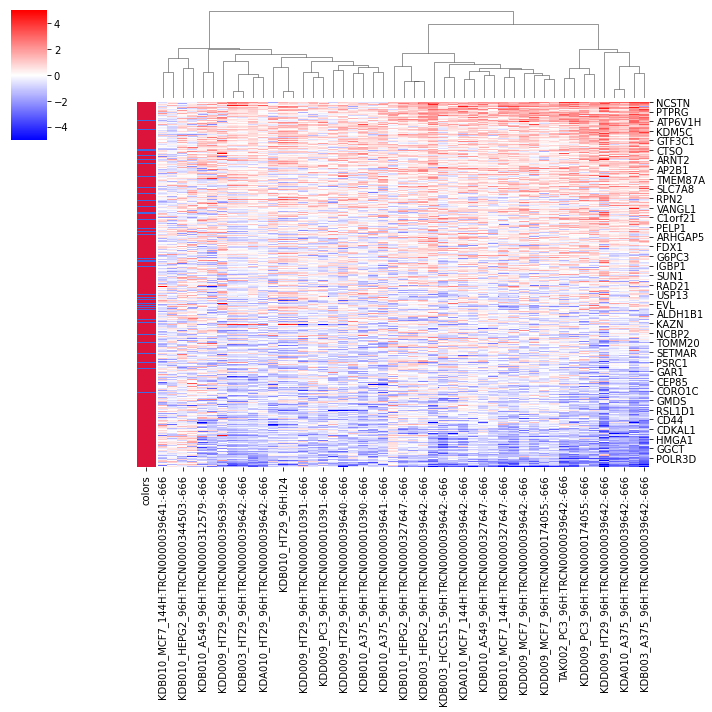

In [607]:
sns.clustermap(myc_shRNA_lv5.loc[myc_g_order.index, :],
               row_cluster=False, row_colors=ec_color,
               col_cluster=True,
               method='ward', cmap='bwr',
               vmin=-5, vmax=5)
fig = plt.gcf()

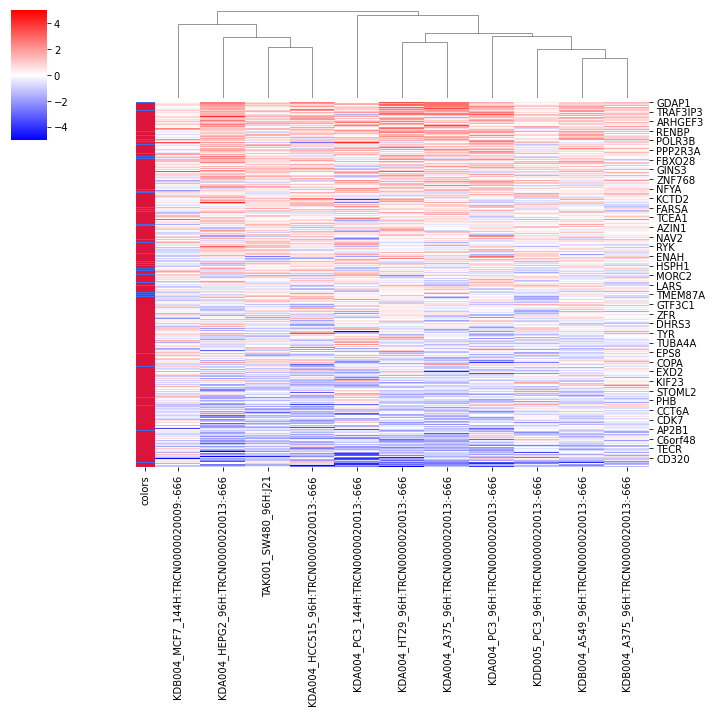

In [608]:
sns.clustermap(smad3_shRNA_lv5.loc[smad3_g_order.index, :],
               row_cluster=False, row_colors=ec_color,
               col_cluster=True,
               method='ward', cmap='bwr',
               vmin=-5, vmax=5)
fig = plt.gcf()